### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [2]:
is_log_target = True
is_per_area_target = True
is_embedding = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

# cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


### Columns

In [3]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

cols_num = [c for c in cols_num if c not in cols_feats_rm]
cols_bin = [c for c in cols_bin if c not in cols_feats_rm]
cols_cat = [c for c in cols_cat if c not in cols_feats_rm]
#cols_feats_add = [c for c in cols_feats_add if c not in cols_feats_rm]

#cols_feats = cols_num + cols_cat + cols_bin + cols_feats_add

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

# For Stratified train test split
cols_stratified = ['town', 'village']

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Num: 155 Bin: 49 Cat: 7
Add: 1 0 1


### Read data

In [4]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,9,1,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,88,1,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,113,1,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,23,1,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,75,1,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061


shape = (60000, 235)


### Preprocessing

In [5]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # label for stratified train test split
    #df['stratified'] = 
    
    return df

In [6]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [7]:
dfp = pre_processing(df, cols_num, cols_cat, cols_bin)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', cols_feats)

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat]
print('\nTarget mean encoded columns:', cols_tar_encoded)

# Compute skew columns
cols_right_skew = [c for c in cols_num if dfp[c].skew() > 2.2]
print('\nRight skew columns:', cols_right_skew)

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_

#### Check

In [27]:
dfp[cols_feats].check()

,txn_dt,total_floor,building_complete_dt,parking_area,parking_price,txn_floor,land_area,building_area,lat,lon,...,XII_index_500,XII_index_1000,XIII_index_50,XIII_index_500,XIII_index_1000,XIII_index_5000,XIII_index_10000,XIV_index_50,XIV_index_500,XIV_index_1000
0,18674.0,4.0,6271.0,NaN,NaN,3.0,18.144461,3.418175,-39.139999,117.080002,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,18800.0,5.0,7885.0,NaN,NaN,5.0,11.387227,4.041309,-37.660000,119.279999,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,19289.0,4.0,6028.0,NaN,NaN,1.0,21.426802,5.584279,-37.669998,119.290001,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
3,20385.0,24.0,18325.0,NaN,81138.890625,13.0,11.387227,13.563030,-39.130001,117.089996,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,20657.0,2.0,6880.0,NaN,NaN,NaN,61.306522,4.688108,-39.240002,117.190002,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
59995,19040.0,2.0,9193.0,NaN,NaN,NaN,50.917366,6.754059,-39.220001,117.269997,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
59996,19706.0,14.0,17168.0,3.738412,133729.234375,7.0,4.181031,5.356788,-37.650002,119.370003,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
59997,19901.0,11.0,13729.0,NaN,61488.570312,6.0,11.387227,8.223644,-37.669998,119.309998,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
59998,19975.0,5.0,7063.0,NaN,NaN,3.0,23.049440,8.728287,-37.639999,119.379997,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
59999,20385.0,5.0,8310.0,NaN,NaN,4.0,16.482126,5.356788,-37.669998,119.300003,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


shape = (60000, 213)


#### Null check

In [10]:
cols_null = [c for c in cols_feats if df[c].isnull().any()]
for c in cols_null:
    print(c, dfp[c].isnull().sum(), df[c].isnull().sum())

parking_area 56897 56897
parking_price 46065 46065
txn_floor 15902 15902
village_income_median 1142 1142


In [22]:
cols_not_finite = [c for c in cols_feats if not np.isfinite(dfp[c]).all()]
for c in cols_not_finite:
    print(c, (~np.isfinite(dfp[c])).sum())

parking_area 56897
parking_price 46065
txn_floor 15902
village_income_median 1142


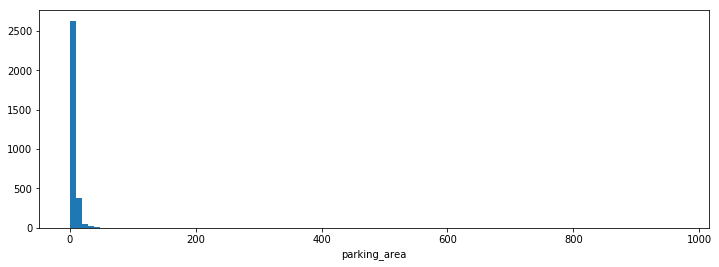

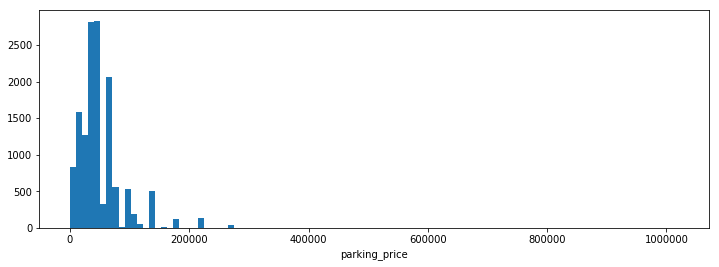

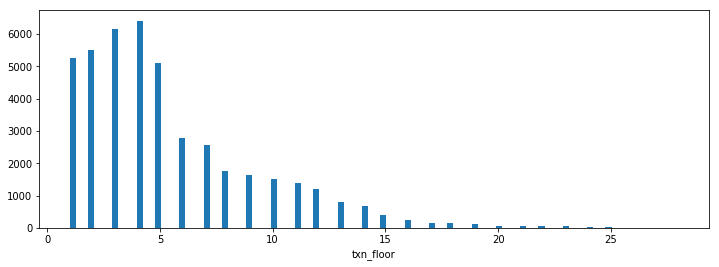

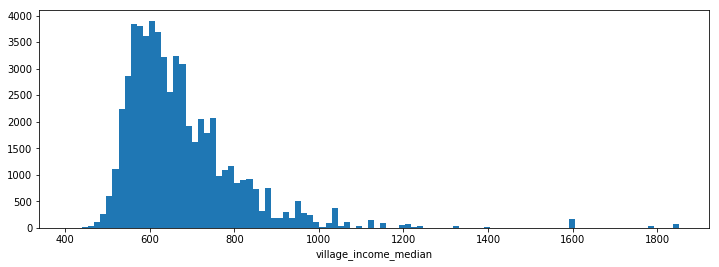

In [13]:
for c in cols_null:
    plt.figure(figsize=(12, 4))
    sq = dfp[c]
    sq = sq[np.isfinite(sq)]
    plt.hist(sq, bins=100)
    plt.xlabel(c)
    plt.show()

In [14]:
for c in cols_null:
    print(c)
    dfp.loc[dfp[c].isnull(), ['log_per_area_total_price']+cols_feats].check()

parking_area


,log_per_area_total_price,txn_dt,total_floor,building_complete_dt,parking_area,parking_price,txn_floor,land_area,building_area,lat,...,XIII_index_50,XIII_index_500,XIII_index_1000,XIII_index_5000,XIII_index_10000,XIV_index_50,XIV_index_500,XIV_index_1000,encoded_latlon,building_per_land_area
0,12.151933,18674.0,4.0,6271.0,NaN,NaN,3.0,18.144461,3.418175,-39.139999,...,0,1,1,1,1,1,1,1,1,0.188387
1,13.619346,18800.0,5.0,7885.0,NaN,NaN,5.0,11.387227,4.041309,-37.660000,...,1,1,1,1,1,1,1,1,0,0.354898
2,14.354281,19289.0,4.0,6028.0,NaN,NaN,1.0,21.426802,5.584279,-37.669998,...,0,1,1,1,1,0,1,1,0,0.260621
3,13.862462,20385.0,24.0,18325.0,NaN,81138.890625,13.0,11.387227,13.563030,-39.130001,...,0,0,0,1,1,0,1,1,1,1.191074
4,11.999613,20657.0,2.0,6880.0,NaN,NaN,NaN,61.306522,4.688108,-39.240002,...,0,0,0,1,1,0,1,1,1,0.076470
59994,13.989460,18359.0,4.0,4414.0,NaN,NaN,2.0,21.426802,4.908649,-37.660000,...,0,1,1,1,1,0,1,1,0,0.229089
59995,11.892310,19040.0,2.0,9193.0,NaN,NaN,NaN,50.917366,6.754059,-39.220001,...,0,0,1,1,1,0,1,1,1,0.132647
59997,14.177902,19901.0,11.0,13729.0,NaN,61488.570312,6.0,11.387227,8.223644,-37.669998,...,0,1,1,1,1,0,1,1,0,0.722181
59998,14.544024,19975.0,5.0,7063.0,NaN,NaN,3.0,23.049440,8.728287,-37.639999,...,1,1,1,1,1,1,1,1,0,0.378677
59999,14.278423,20385.0,5.0,8310.0,NaN,NaN,4.0,16.482126,5.356788,-37.669998,...,0,1,1,1,1,1,1,1,0,0.325006


shape = (56897, 214)
parking_price


,log_per_area_total_price,txn_dt,total_floor,building_complete_dt,parking_area,parking_price,txn_floor,land_area,building_area,lat,...,XIII_index_50,XIII_index_500,XIII_index_1000,XIII_index_5000,XIII_index_10000,XIV_index_50,XIV_index_500,XIV_index_1000,encoded_latlon,building_per_land_area
0,12.151933,18674.0,4.0,6271.0,NaN,NaN,3.0,18.144461,3.418175,-39.139999,...,0,1,1,1,1,1,1,1,1,0.188387
1,13.619346,18800.0,5.0,7885.0,NaN,NaN,5.0,11.387227,4.041309,-37.660000,...,1,1,1,1,1,1,1,1,0,0.354898
2,14.354281,19289.0,4.0,6028.0,NaN,NaN,1.0,21.426802,5.584279,-37.669998,...,0,1,1,1,1,0,1,1,0,0.260621
4,11.999613,20657.0,2.0,6880.0,NaN,NaN,NaN,61.306522,4.688108,-39.240002,...,0,0,0,1,1,0,1,1,1,0.076470
5,11.602981,18394.0,5.0,6576.0,NaN,NaN,4.0,14.803422,3.623132,-39.139999,...,0,0,1,1,1,0,1,1,1,0.244750
59993,14.568701,18715.0,4.0,6971.0,NaN,NaN,1.0,16.482126,4.254375,-37.700001,...,0,1,1,1,1,0,1,1,0,0.258120
59994,13.989460,18359.0,4.0,4414.0,NaN,NaN,2.0,21.426802,4.908649,-37.660000,...,0,1,1,1,1,0,1,1,0,0.229089
59995,11.892310,19040.0,2.0,9193.0,NaN,NaN,NaN,50.917366,6.754059,-39.220001,...,0,0,1,1,1,0,1,1,1,0.132647
59998,14.544024,19975.0,5.0,7063.0,NaN,NaN,3.0,23.049440,8.728287,-37.639999,...,1,1,1,1,1,1,1,1,0,0.378677
59999,14.278423,20385.0,5.0,8310.0,NaN,NaN,4.0,16.482126,5.356788,-37.669998,...,0,1,1,1,1,1,1,1,0,0.325006


shape = (46065, 214)
txn_floor


,log_per_area_total_price,txn_dt,total_floor,building_complete_dt,parking_area,parking_price,txn_floor,land_area,building_area,lat,...,XIII_index_50,XIII_index_500,XIII_index_1000,XIII_index_5000,XIII_index_10000,XIV_index_50,XIV_index_500,XIV_index_1000,encoded_latlon,building_per_land_area
4,11.999613,20657.0,2.0,6880.0,NaN,NaN,NaN,61.306522,4.688108,-39.240002,...,0,0,0,1,1,0,1,1,1,0.076470
10,13.327872,18333.0,2.0,7763.0,NaN,NaN,NaN,109.807320,12.446199,-37.709999,...,0,0,0,1,1,0,1,1,0,0.113346
11,13.347915,18184.0,5.0,15556.0,NaN,NaN,NaN,46.403652,17.941740,-39.130001,...,0,0,1,1,1,0,1,1,1,0.386645
15,13.050904,19011.0,4.0,15342.0,NaN,NaN,NaN,59.833447,22.590887,-37.660000,...,0,0,0,1,1,1,1,1,3,0.377563
21,14.100337,19114.0,2.0,3654.0,NaN,NaN,NaN,31.013628,4.041309,-37.590000,...,0,1,1,1,1,1,1,1,5,0.130308
59981,13.961881,19671.0,3.0,8463.0,NaN,NaN,NaN,72.975853,10.814888,-37.570000,...,0,0,1,1,1,0,1,1,5,0.148198
59985,13.493060,20384.0,4.0,15707.0,NaN,NaN,NaN,43.371033,17.941740,-37.980000,...,0,0,0,1,1,1,1,1,2,0.413680
59988,12.326890,19692.0,4.0,6821.0,NaN,NaN,NaN,34.141563,12.170581,-38.779999,...,0,1,1,1,1,0,1,1,4,0.356474
59989,14.589276,19348.0,3.0,6363.0,NaN,NaN,NaN,70.076576,17.341492,-37.590000,...,0,1,1,1,1,0,1,1,5,0.247465
59995,11.892310,19040.0,2.0,9193.0,NaN,NaN,NaN,50.917366,6.754059,-39.220001,...,0,0,1,1,1,0,1,1,1,0.132647


shape = (15902, 214)
village_income_median


,log_per_area_total_price,txn_dt,total_floor,building_complete_dt,parking_area,parking_price,txn_floor,land_area,building_area,lat,...,XIII_index_50,XIII_index_500,XIII_index_1000,XIII_index_5000,XIII_index_10000,XIV_index_50,XIV_index_500,XIV_index_1000,encoded_latlon,building_per_land_area
116,13.885221,19702.0,5.0,8463.0,NaN,NaN,5.0,11.387227,3.418175,-37.700001,...,1,1,1,1,1,0,1,1,0,0.300176
249,13.273368,20010.0,13.0,16164.0,NaN,43791.945312,13.0,9.642834,9.239933,-37.599998,...,0,1,1,1,1,0,1,1,5,0.958218
343,12.625048,20480.0,4.0,8371.0,NaN,NaN,NaN,34.141563,8.983248,-38.779999,...,0,1,1,1,1,0,1,1,4,0.263118
428,11.958098,20659.0,3.0,11142.0,NaN,NaN,NaN,55.392738,14.990195,-38.639999,...,0,0,1,1,1,1,1,1,4,0.270617
433,12.962326,19768.0,4.0,16225.0,NaN,NaN,NaN,41.847099,11.082977,-38.790001,...,0,0,1,1,1,1,1,1,4,0.264845
59858,13.538457,18579.0,2.0,2527.0,NaN,NaN,NaN,109.807320,7.726227,-38.799999,...,0,0,1,1,1,1,1,1,4,0.070362
59886,13.154260,20416.0,4.0,15587.0,NaN,NaN,NaN,49.417259,13.563030,-38.790001,...,0,0,1,1,1,0,1,1,4,0.274459
59958,12.153495,19692.0,9.0,11962.0,NaN,NaN,8.0,11.387227,7.726227,-38.799999,...,0,1,1,1,1,0,1,1,4,0.678499
59965,13.495023,18249.0,15.0,18051.0,NaN,52383.828125,3.0,32.581219,33.279190,-37.599998,...,0,1,1,1,1,0,1,1,5,1.021423
59988,12.326890,19692.0,4.0,6821.0,NaN,NaN,NaN,34.141563,12.170581,-38.779999,...,0,1,1,1,1,0,1,1,4,0.356474


shape = (1142, 214)


In [15]:
for c in cols_null:
    print(c, (dfp[c] == 0).sum()) # some data have parking area = 0, let's use -1 for null

parking_area 6
parking_price 18
txn_floor 0
village_income_median 0


In [16]:
dfp.loc[dfp['parking_area']==0, ['parking_price', 'log_per_area_total_price', 'txn_floor']]

,parking_price,log_per_area_total_price,txn_floor
7540,28272.384766,14.335921,8.0
9821,9851.351562,12.856297,4.0
20916,33186.355469,14.446233,11.0
37213,49461.515625,15.470232,14.0
39031,33186.355469,14.638136,15.0
45969,74382.773438,15.314025,10.0


In [17]:
dfp.loc[dfp['village_income_median'].isnull(), ['village', 'town']].check()

,village,town
116,1131,84
249,881,188
343,3114,50
428,523,32
433,2001,206
59858,3277,61
59886,2001,206
59958,493,206
59965,2436,188
59988,828,50


shape = (1142, 2)


In [18]:
dfp.loc[dfp['village_income_median'].notnull(), 'village'].check()

0        3132
1         921
2        1544
3        3350
4          63
59995    1988
59996    1370
59997    1988
59998    1584
59999    1521
Name: village, dtype: int32

shape = (58858,)


In [19]:
dfp.loc[dfp['village']==1544, ['village_income_median', 'txn_dt']].check()

,village_income_median,txn_dt
2,625.0,19289.0
283,618.0,19803.0
308,618.0,18360.0
413,666.0,18929.0
646,537.0,18501.0
56618,566.0,20108.0
56850,566.0,20608.0
57053,618.0,19321.0
57993,625.0,20364.0
58530,618.0,18442.0


shape = (138, 2)


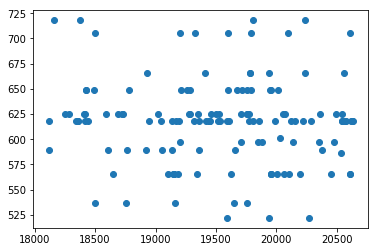

In [20]:
df_temp = dfp.loc[dfp['village']==1544, ['village_income_median', 'txn_dt']]
df_temp = df_temp.loc[df_temp['village_income_median'].notnull()]
plt.scatter(df_temp['txn_dt'], df_temp['village_income_median'])
plt.show()

642.0


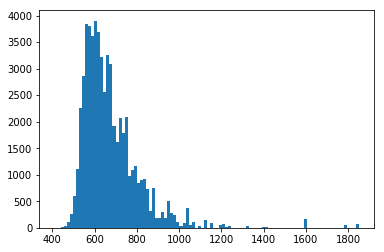

In [9]:
sq = dfp['village_income_median']
sq = sq[np.isfinite(sq)]
print(np.median(sq))
plt.hist(sq, bins=100); plt.show()

In [21]:
len('village_income_median')

21

#### Skew check

parking_area 38.44056


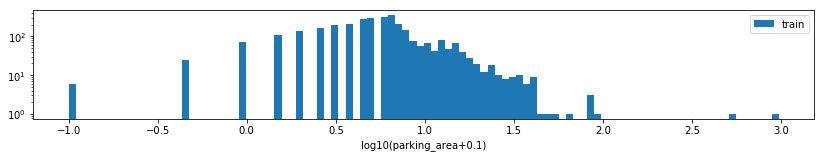

parking_price 3.9744008


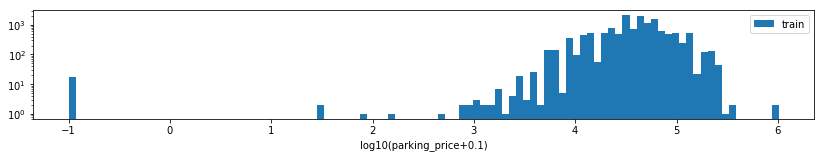

land_area 43.667255


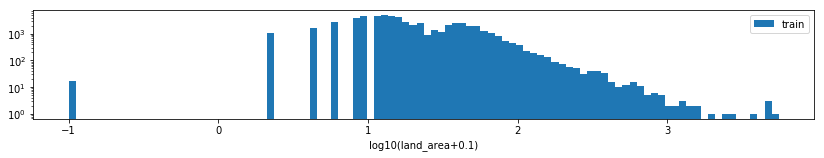

building_area 83.71063


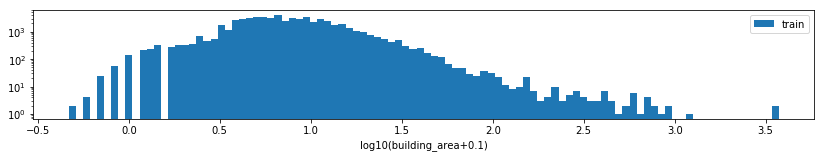

village_income_median 2.8121378


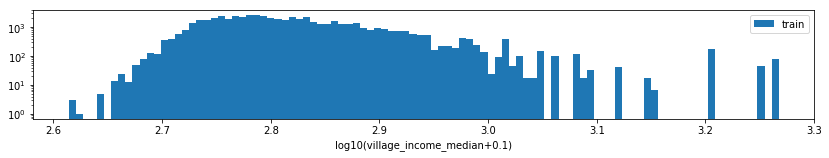

I_10 15.562963


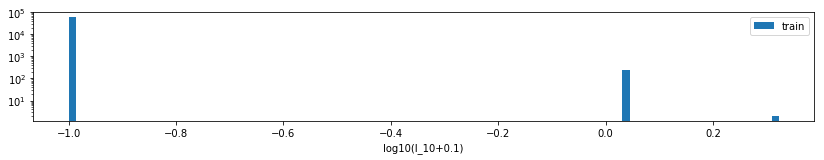

I_50 4.59847


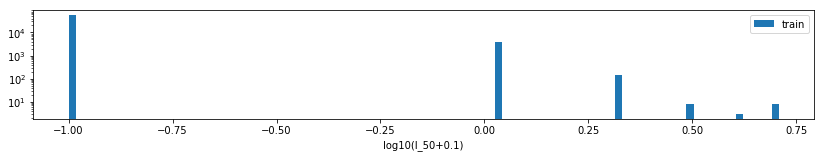

I_100 3.0459154


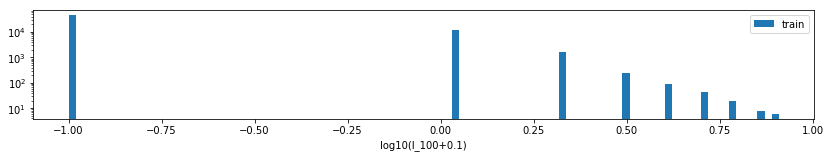

I_MIN 2.7619326


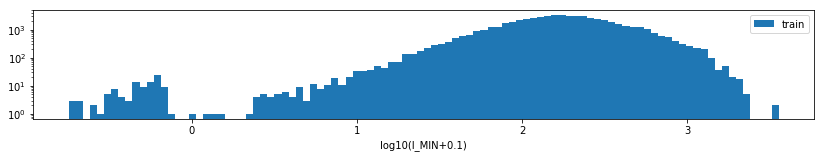

II_10 6.9647446


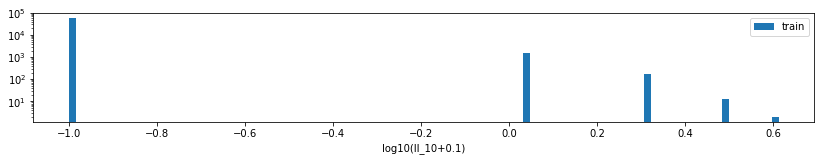

II_50 3.9079301


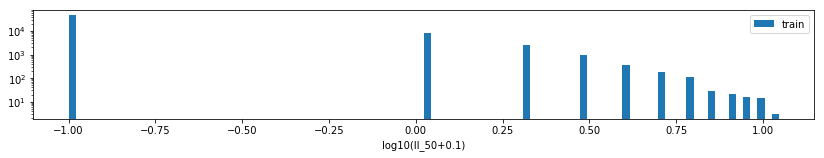

II_100 2.9132206


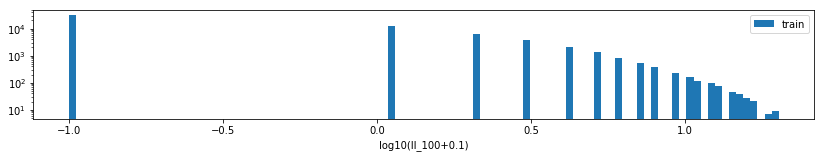

II_MIN 4.077665


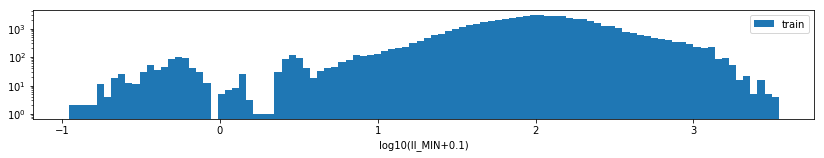

III_10 6.9982715


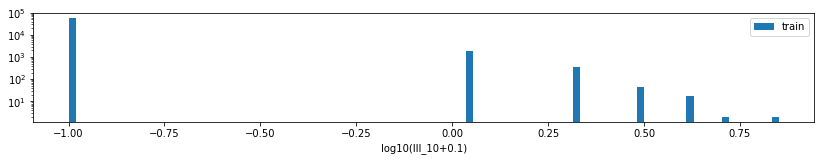

III_50 3.0506077


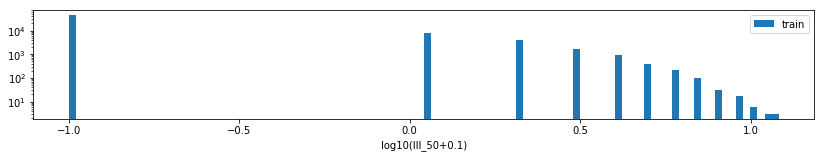

III_MIN 4.3727026


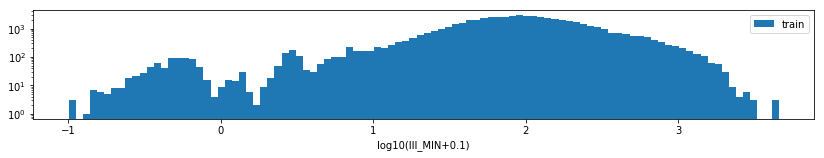

IV_10 17.977915


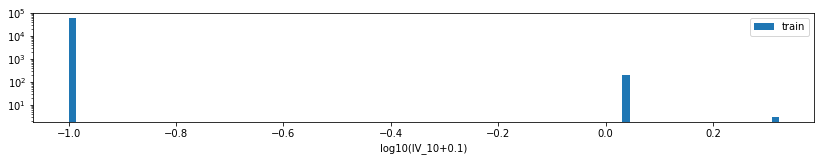

IV_50 10.386395


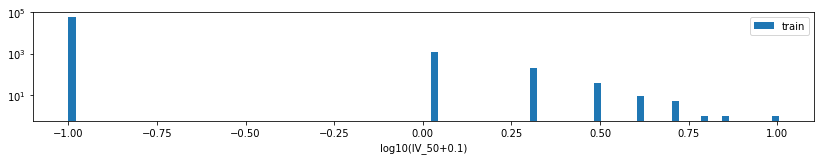

IV_100 8.617198


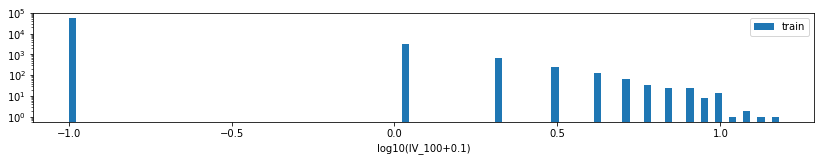

IV_250 7.7754474


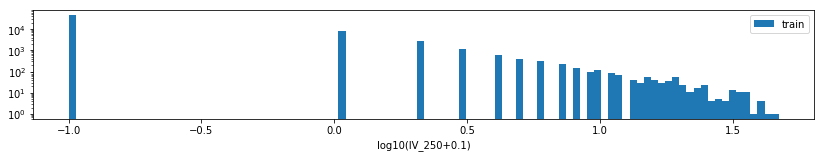

IV_500 6.389957


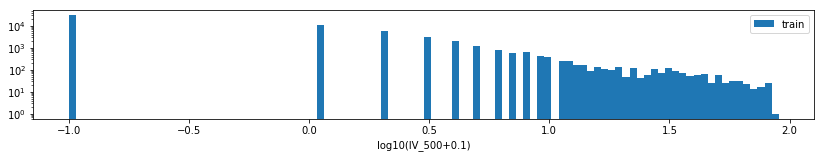

IV_1000 4.698029


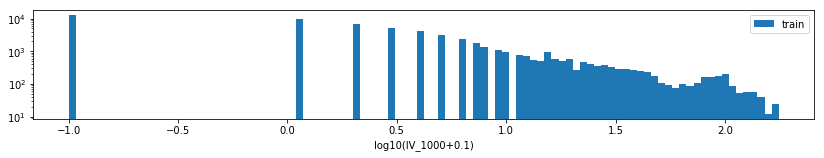

IV_MIN 2.4282353


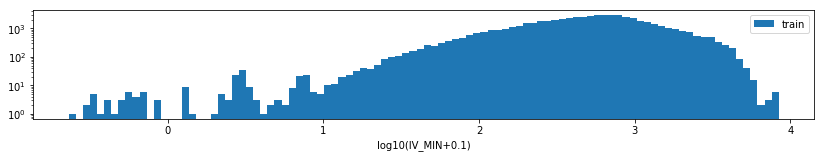

V_10 8.827745


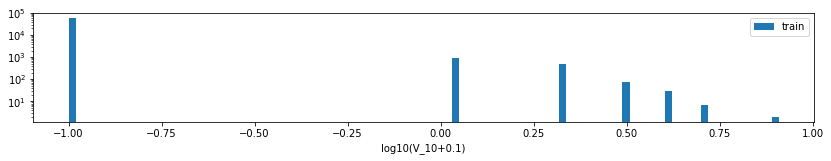

V_50 4.2386923


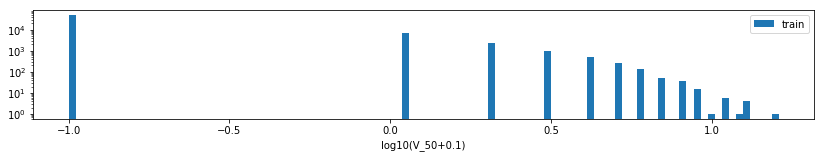

V_100 2.9428067


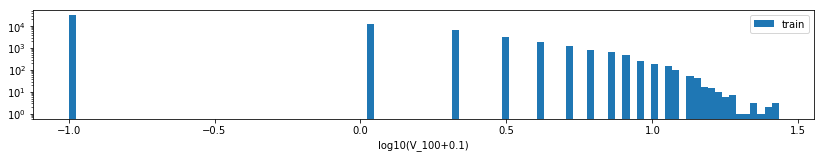

V_250 2.3122835


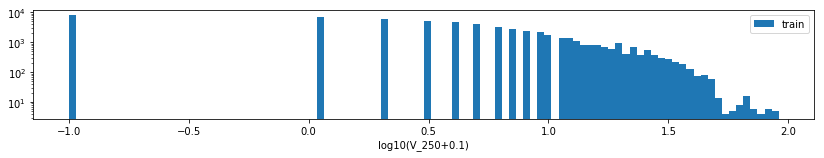

V_MIN 5.753089


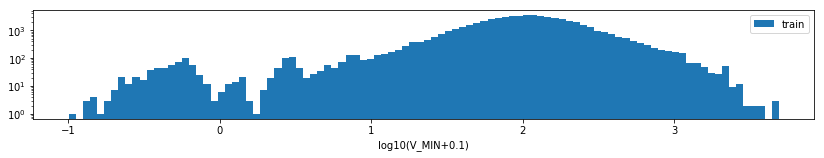

VI_50 7.9816914


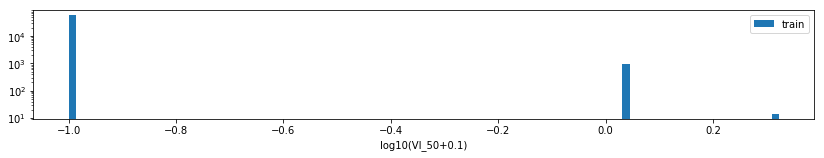

VI_100 4.481978


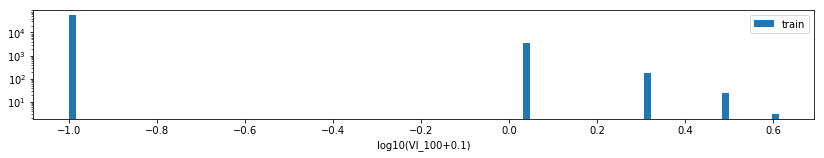

VI_250 3.3660257


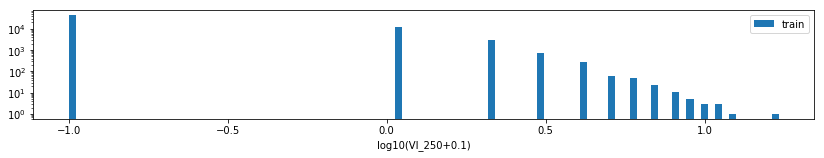

VI_500 3.9736202


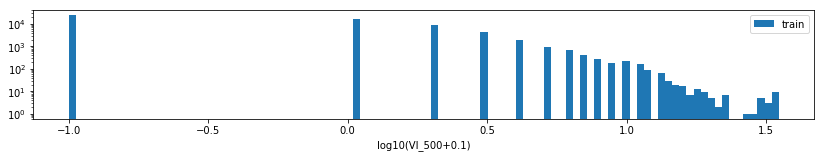

VI_1000 3.7657459


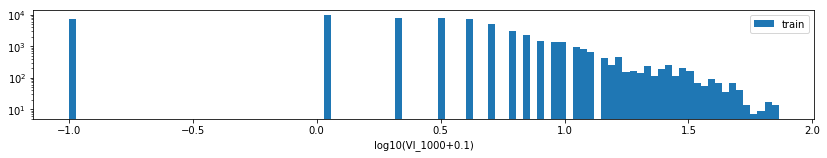

VI_MIN 2.2578814


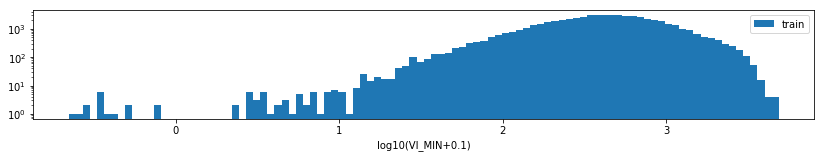

VII_10 5.941517


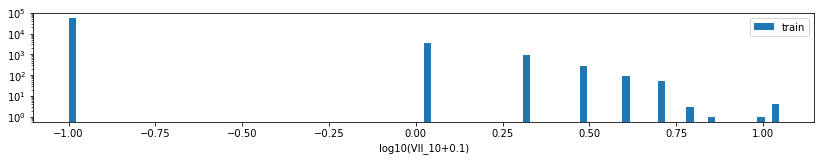

VII_50 3.9886582


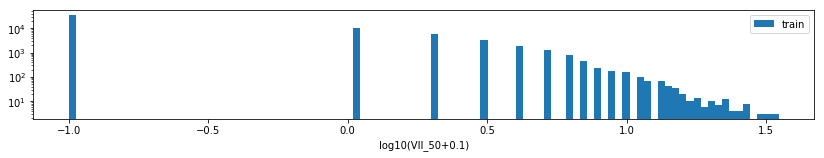

VII_100 4.1016526


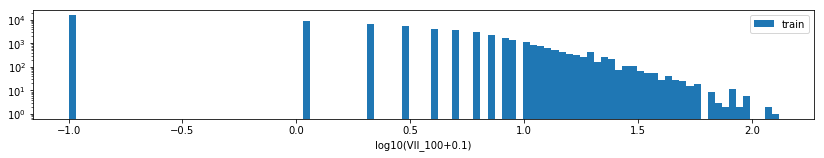

VII_250 3.6328163


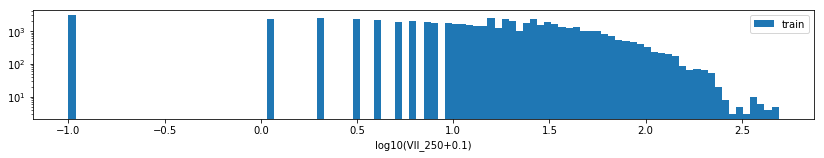

VII_500 2.77274


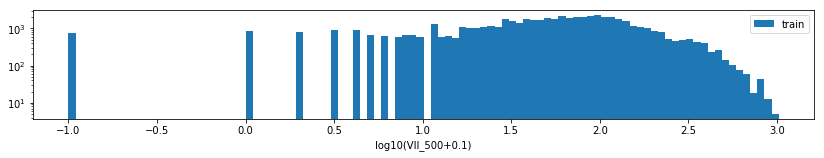

VII_1000 2.438202


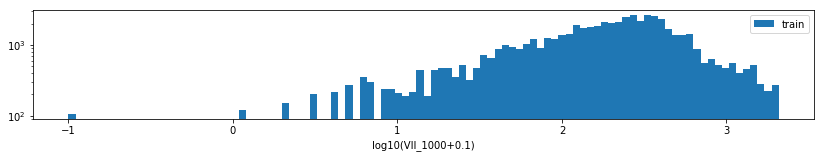

VII_MIN 4.6321354


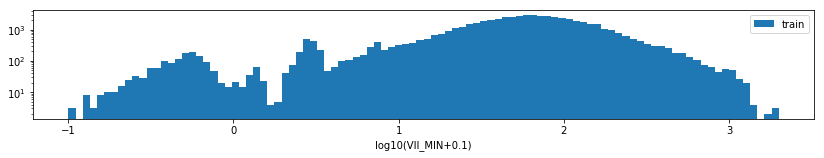

VIII_10 9.726184


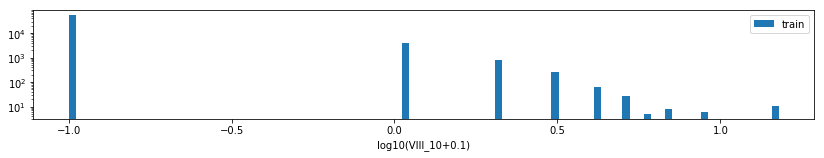

VIII_50 10.752237


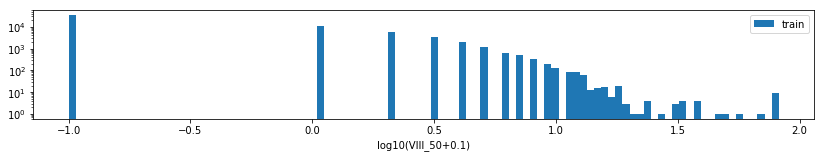

VIII_100 5.0303516


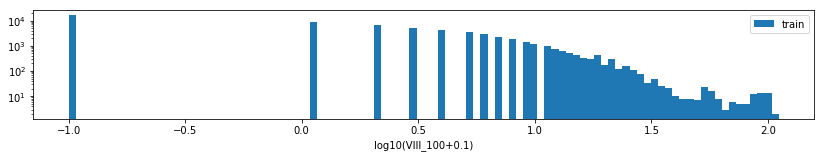

VIII_250 2.3620713


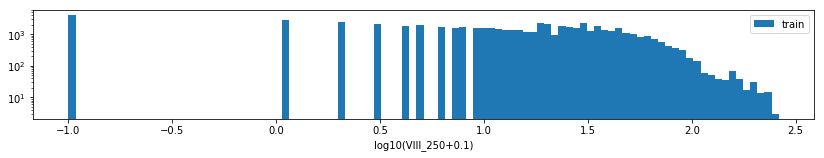

VIII_MIN 8.002373


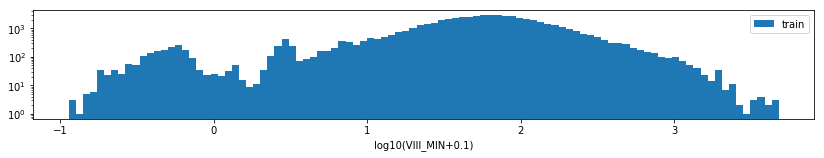

IX_10 7.972574


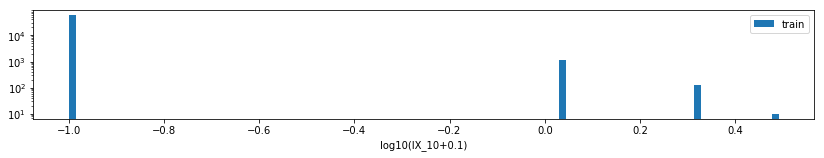

IX_50 4.423249


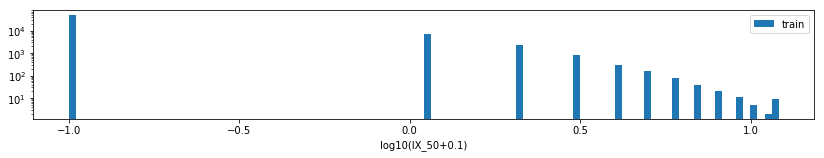

IX_100 3.3713365


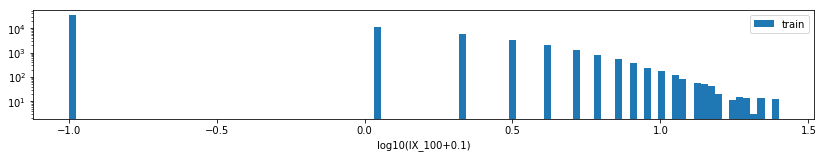

IX_250 2.5531566


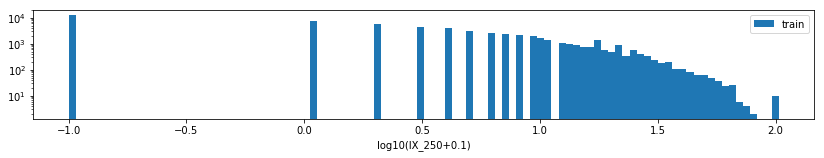

IX_MIN 5.401486


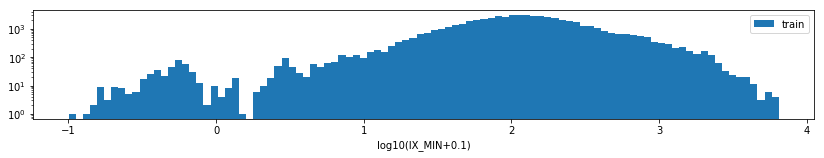

X_10 17.327974


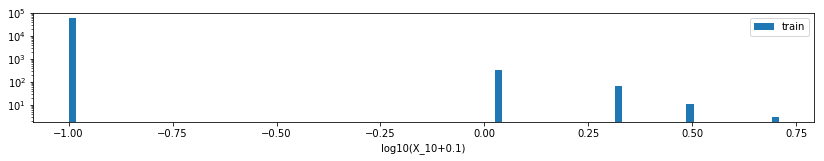

X_50 4.7664347


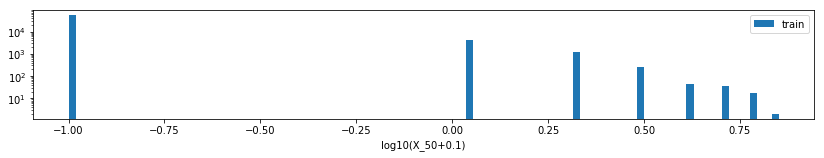

X_100 2.640059


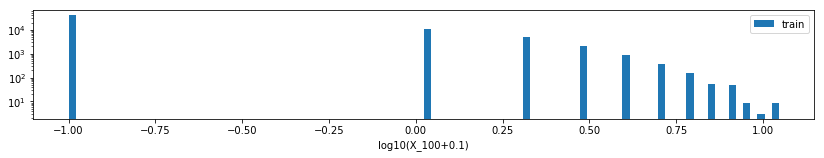

X_MIN 4.719582


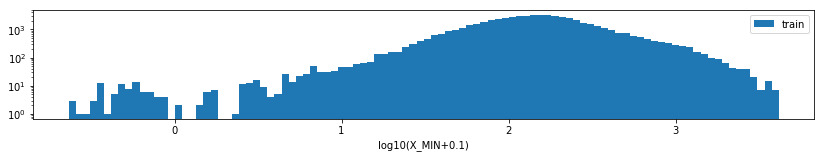

XI_10 14.460102


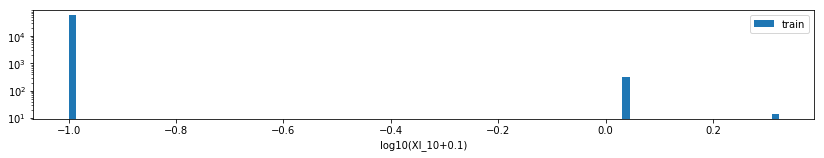

XI_50 3.9838955


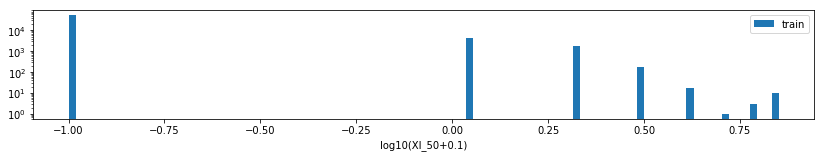

XI_MIN 7.0882425


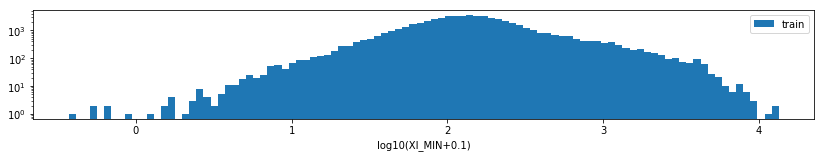

XII_10 3.9807894


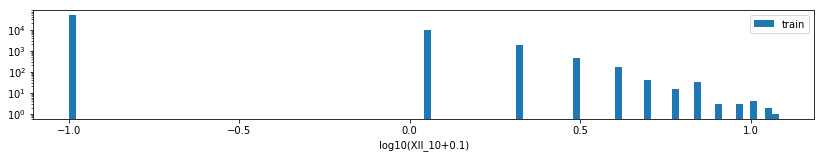

XII_50 4.328934


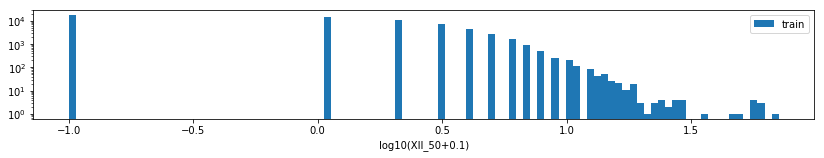

XII_100 2.8269734


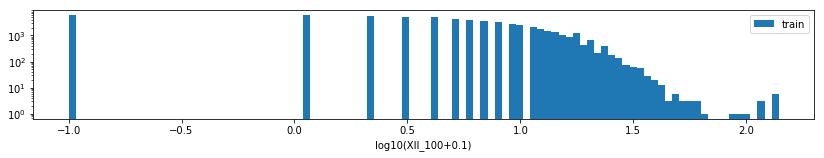

XII_MIN 7.2301226


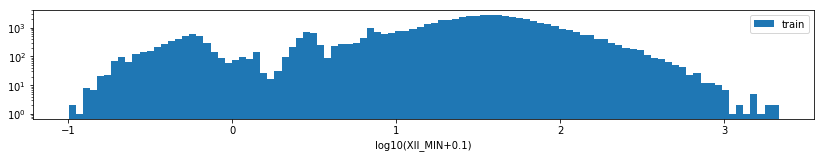

XIII_10 27.698206


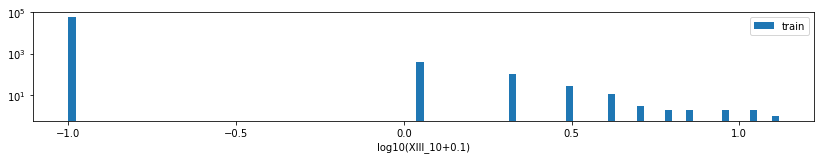

XIII_50 18.247444


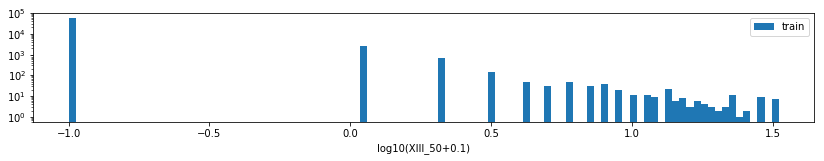

XIII_100 16.26816


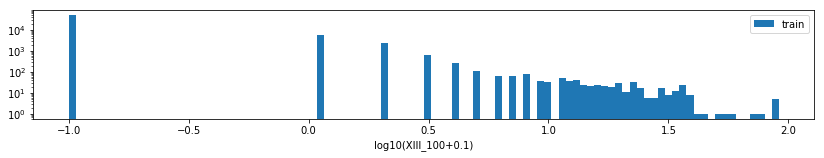

XIII_250 11.758964


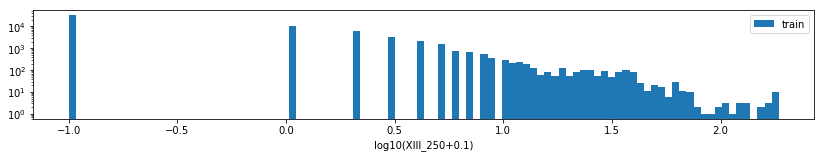

XIII_500 6.4615135


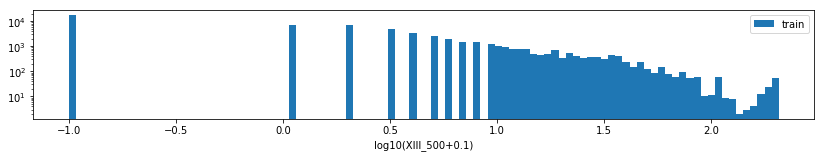

XIII_1000 2.453587


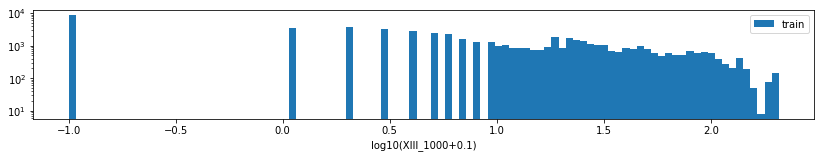

XIII_MIN 7.6069636


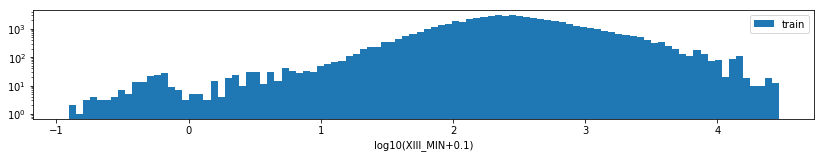

XIV_10 8.467


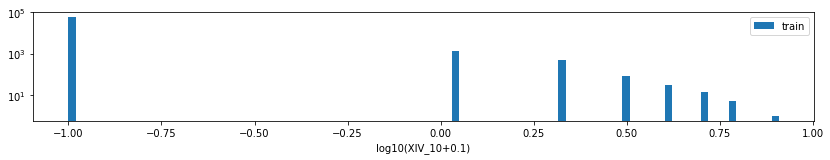

XIV_50 9.9951105


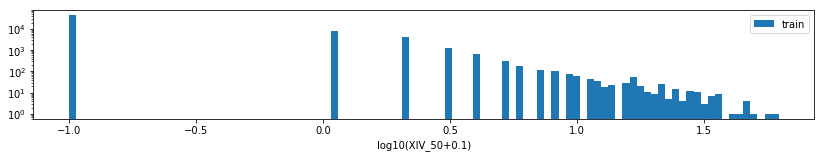

XIV_100 9.850256


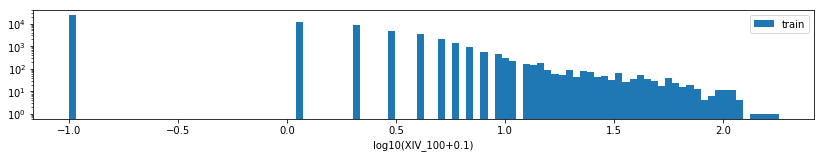

XIV_250 7.352517


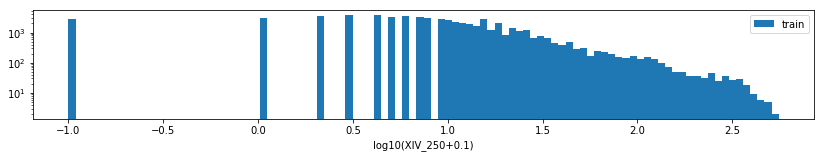

XIV_500 5.094125


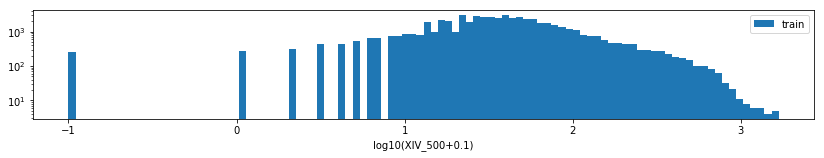

XIV_1000 3.6360552


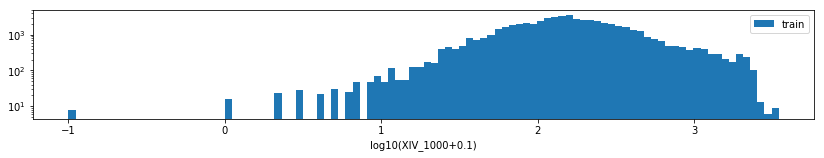

XIV_MIN 2.680964


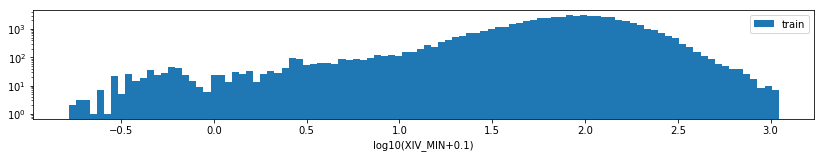

land_per_building_area 19.513025


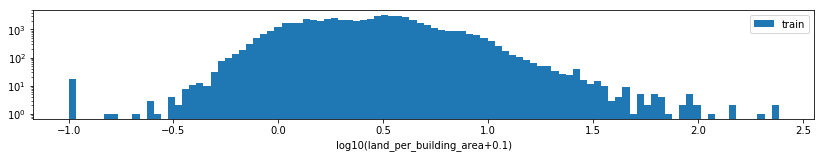

In [25]:
# skew check
for c in cols_right_skew:
    sq = df[c].astype('float32')
    print(c, sq.skew())
    plt.figure(figsize=(14, 2))
    sq = np.log10(sq[np.isfinite(sq)]+0.1)
    plt.hist(sq, bins=100, label='train', alpha=1)
    plt.legend(); plt.xlabel('log10('+c+'+0.1)'); plt.yscale('log')
    plt.show()

parking_area 38.44056


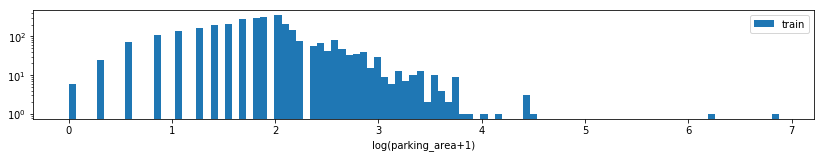

parking_price 3.9744008


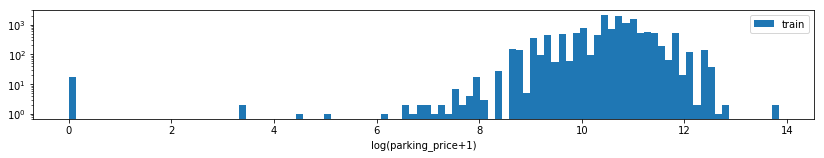

land_area 43.667255


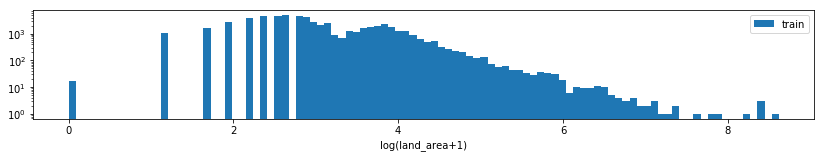

building_area 83.71063


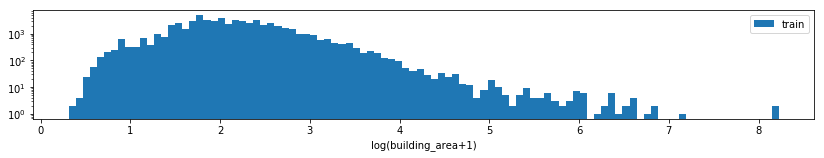

village_income_median 2.8121378


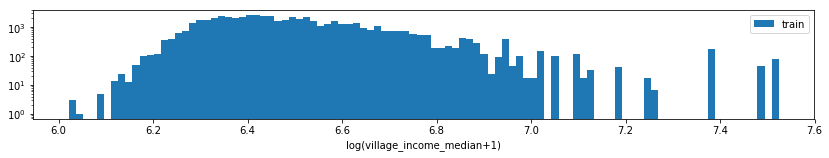

I_10 15.562963


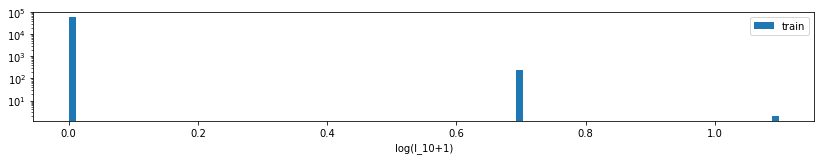

I_50 4.59847


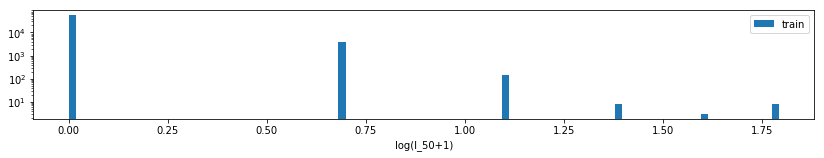

I_100 3.0459154


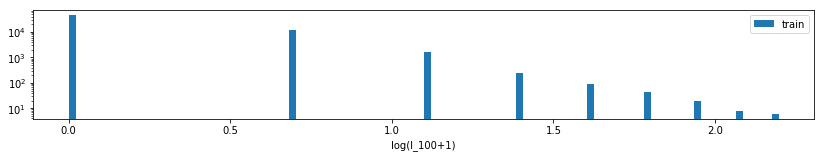

I_MIN 2.7619326


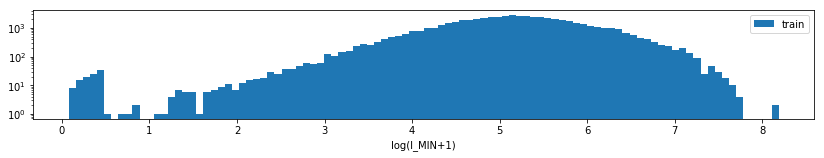

II_10 6.9647446


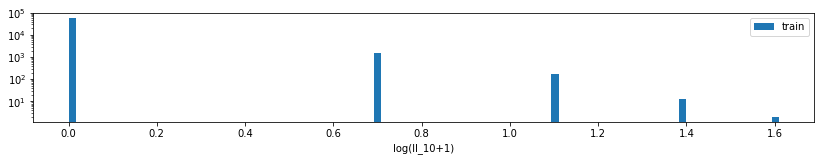

II_50 3.9079301


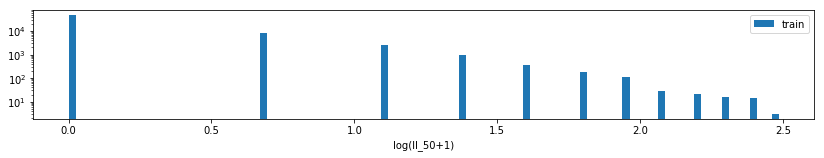

II_100 2.9132206


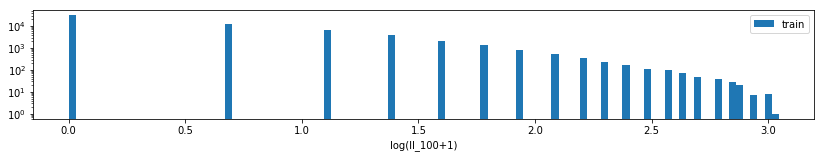

II_MIN 4.077665


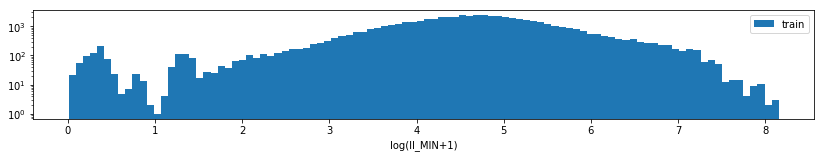

III_10 6.9982715


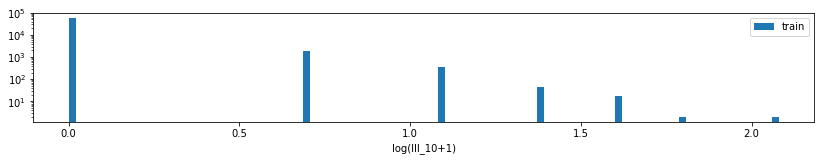

III_50 3.0506077


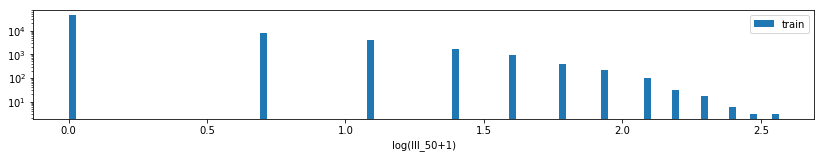

III_MIN 4.3727026


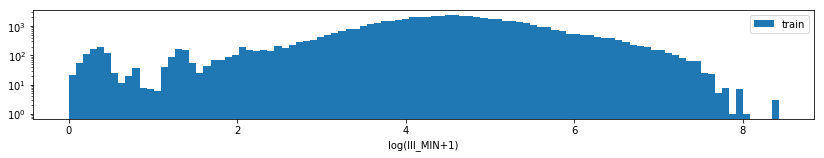

IV_10 17.977915


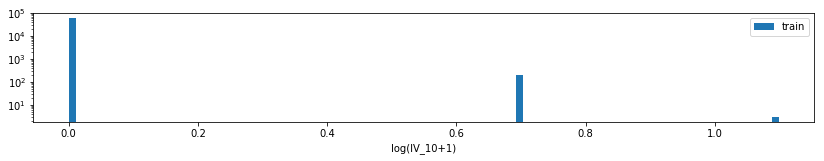

IV_50 10.386395


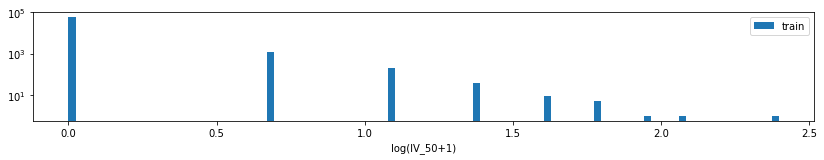

IV_100 8.617198


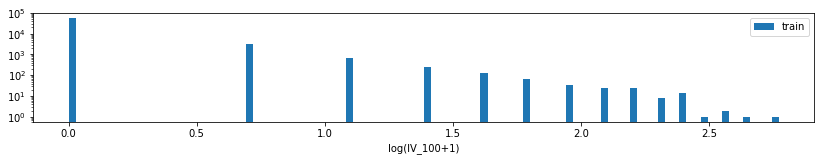

IV_250 7.7754474


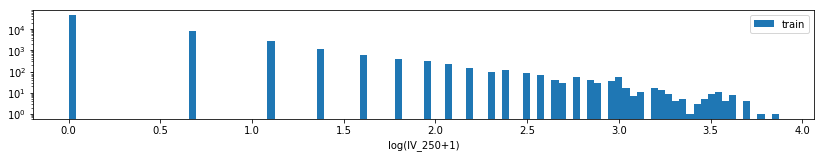

IV_500 6.389957


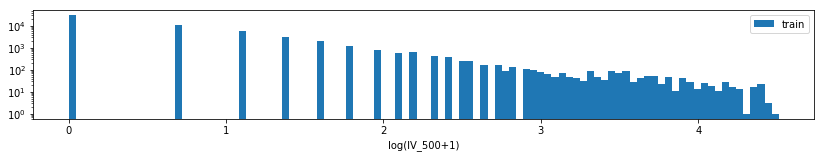

IV_1000 4.698029


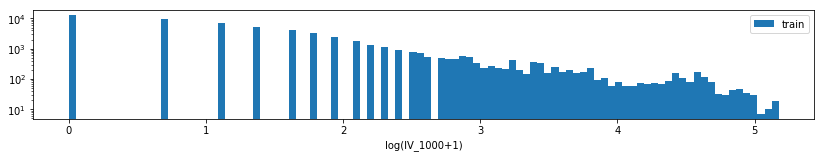

IV_MIN 2.4282353


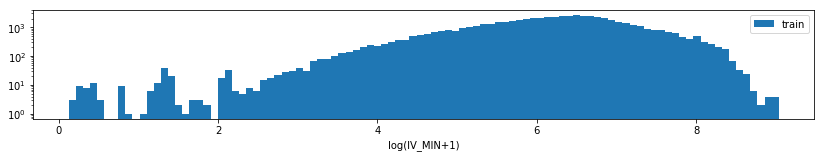

V_10 8.827745


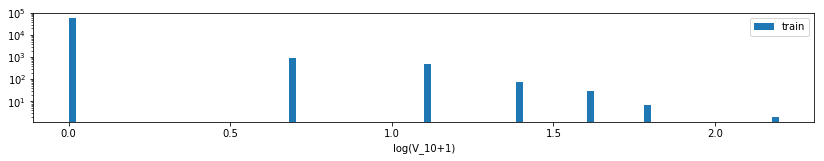

V_50 4.2386923


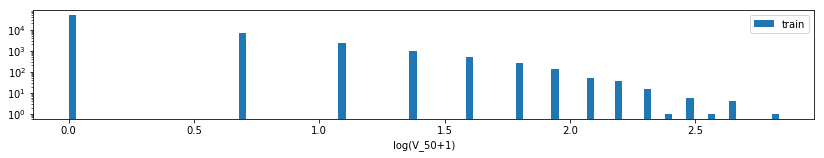

V_100 2.9428067


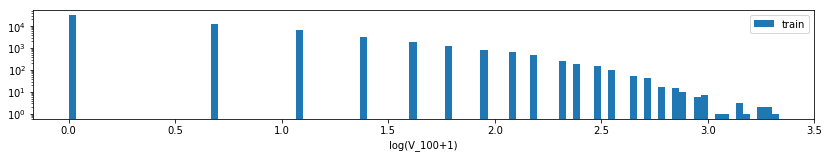

V_250 2.3122835


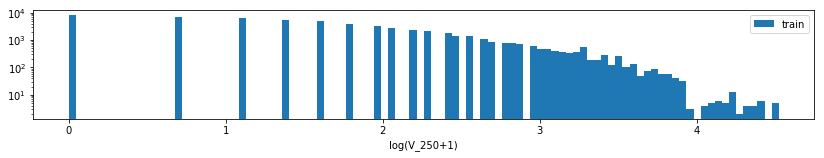

V_MIN 5.753089


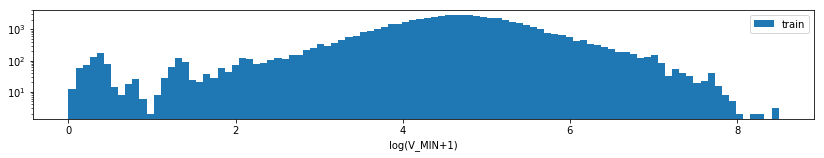

VI_50 7.9816914


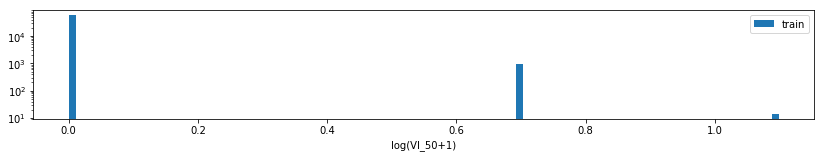

VI_100 4.481978


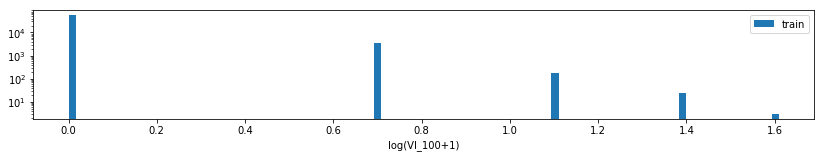

VI_250 3.3660257


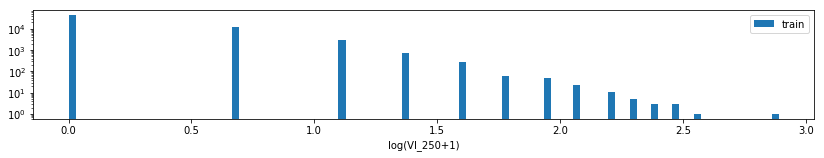

VI_500 3.9736202


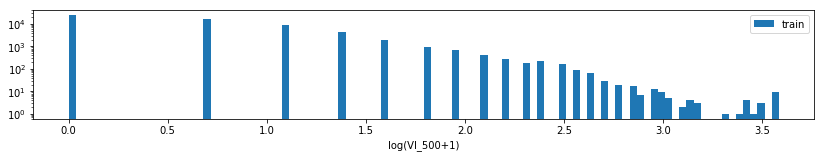

VI_1000 3.7657459


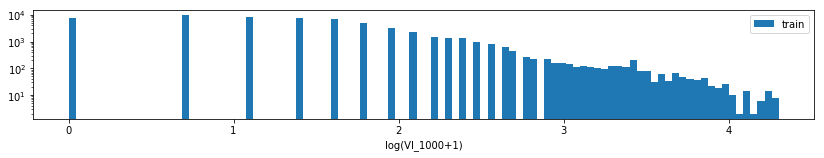

VI_MIN 2.2578814


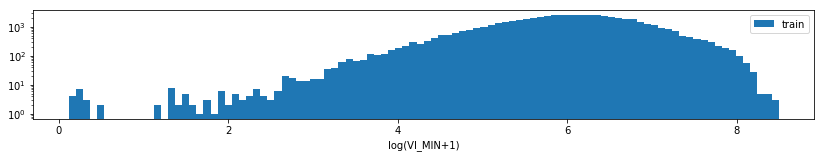

VII_10 5.941517


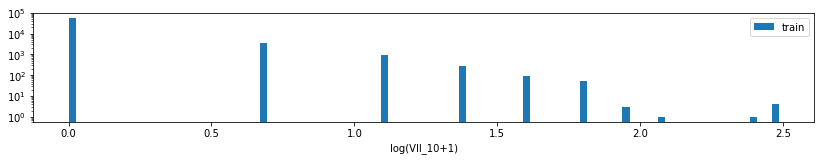

VII_50 3.9886582


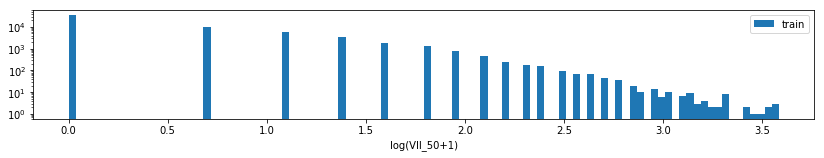

VII_100 4.1016526


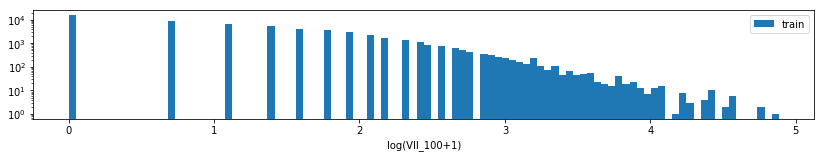

VII_250 3.6328163


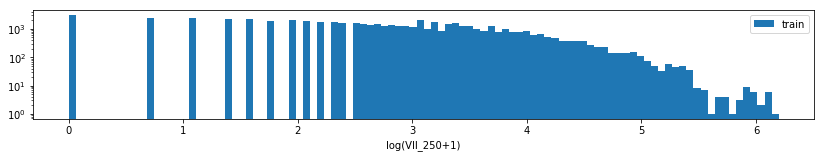

VII_500 2.77274


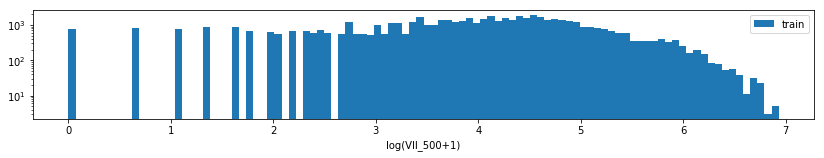

VII_1000 2.438202


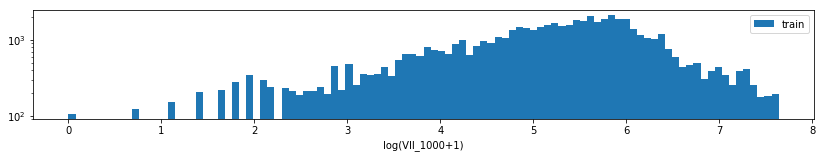

VII_MIN 4.6321354


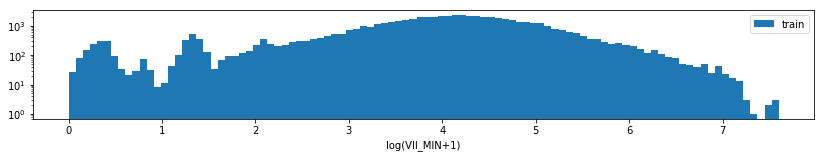

VIII_10 9.726184


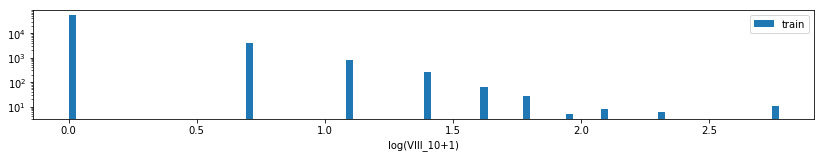

VIII_50 10.752237


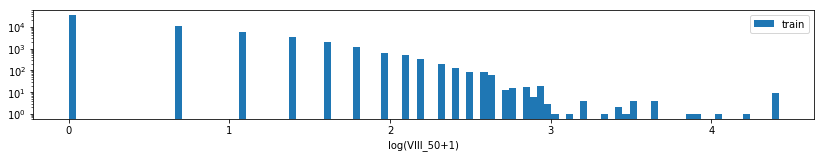

VIII_100 5.0303516


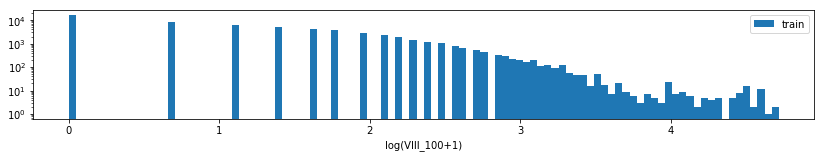

VIII_250 2.3620713


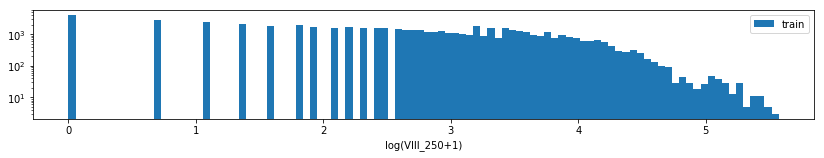

VIII_MIN 8.002373


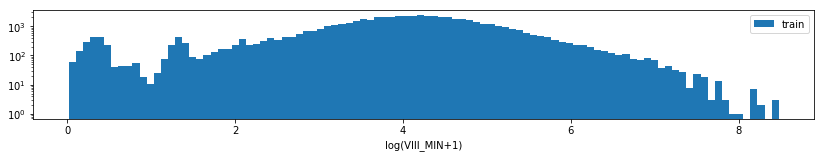

IX_10 7.972574


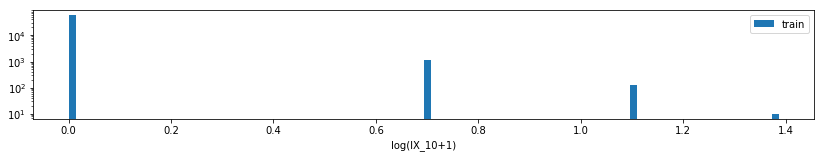

IX_50 4.423249


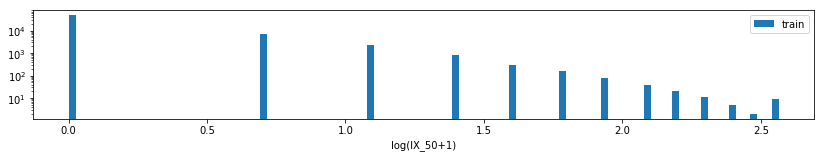

IX_100 3.3713365


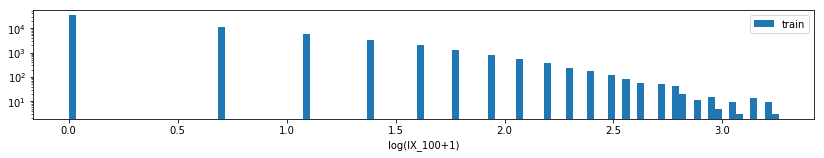

IX_250 2.5531566


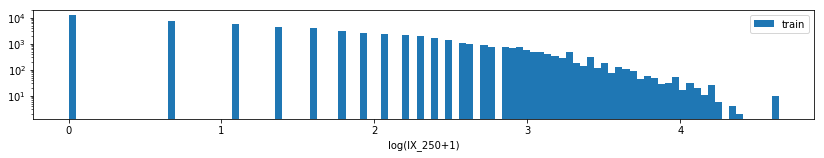

IX_MIN 5.401486


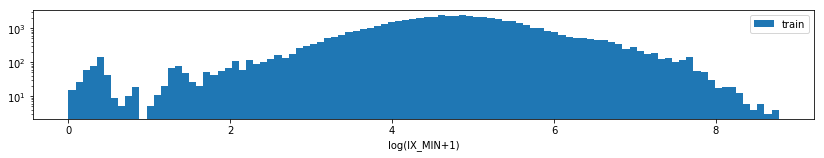

X_10 17.327974


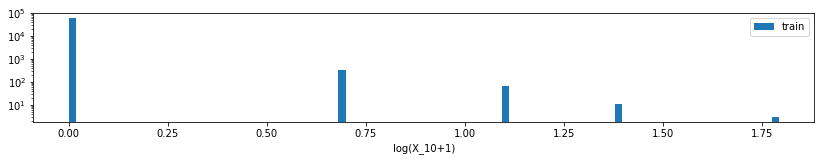

X_50 4.7664347


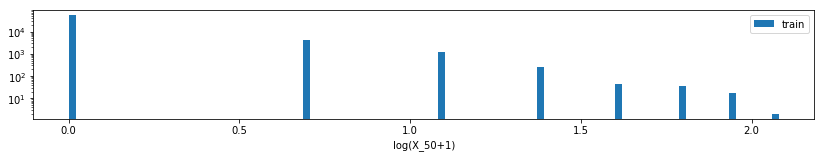

X_100 2.640059


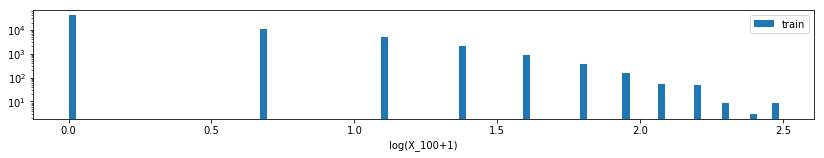

X_MIN 4.719582


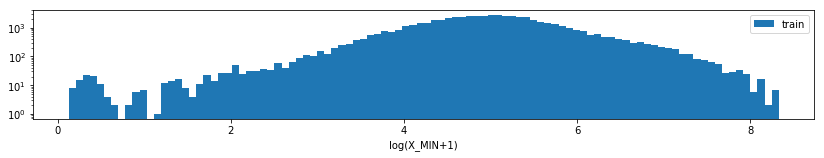

XI_10 14.460102


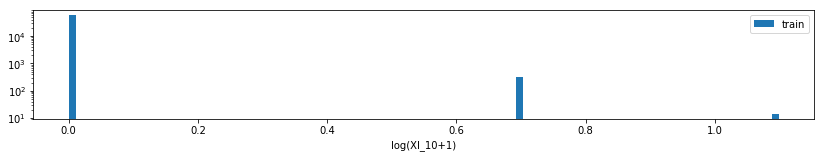

XI_50 3.9838955


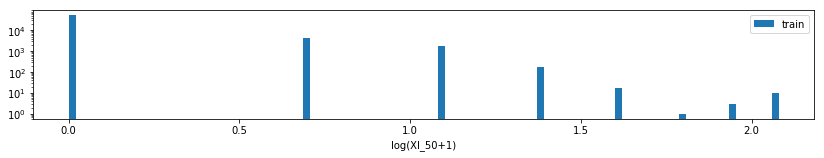

XI_MIN 7.0882425


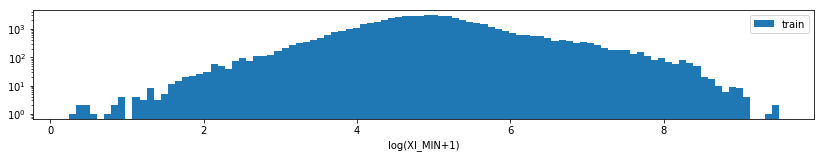

XII_10 3.9807894


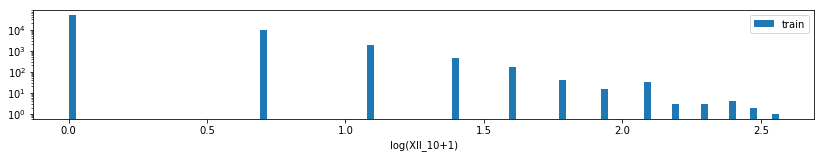

XII_50 4.328934


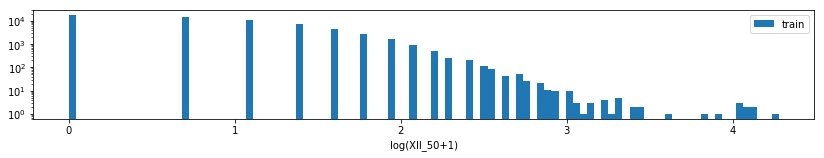

XII_100 2.8269734


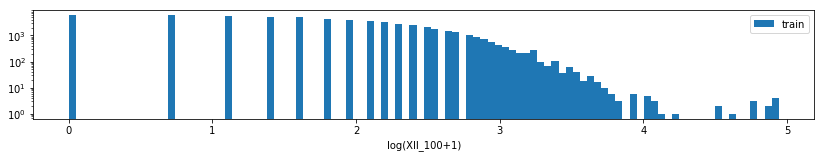

XII_MIN 7.2301226


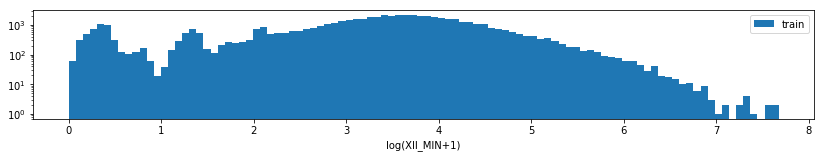

XIII_10 27.698206


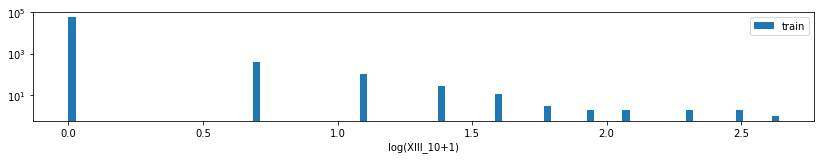

XIII_50 18.247444


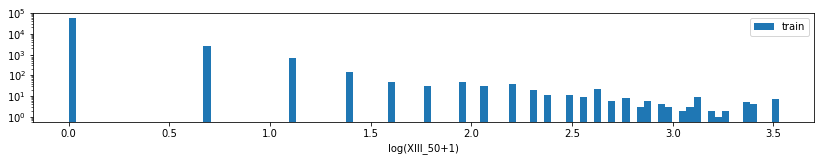

XIII_100 16.26816


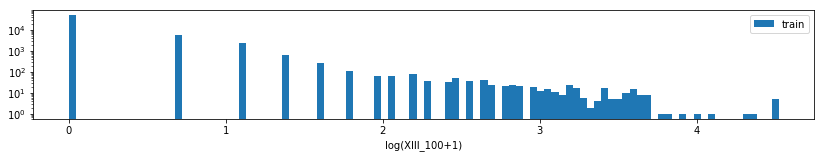

XIII_250 11.758964


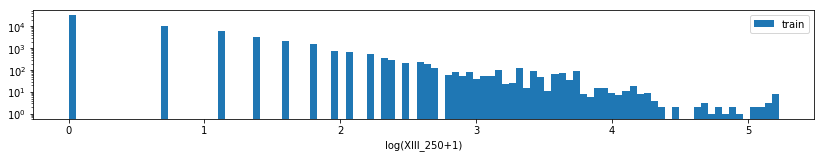

XIII_500 6.4615135


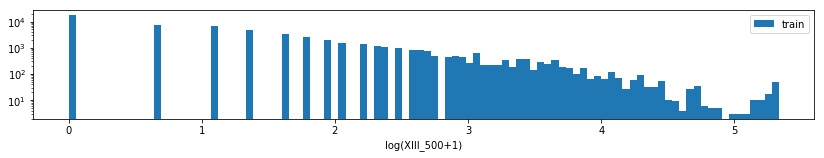

XIII_1000 2.453587


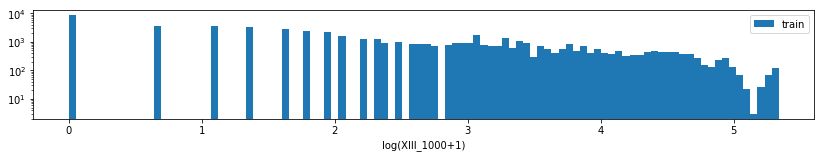

XIII_MIN 7.6069636


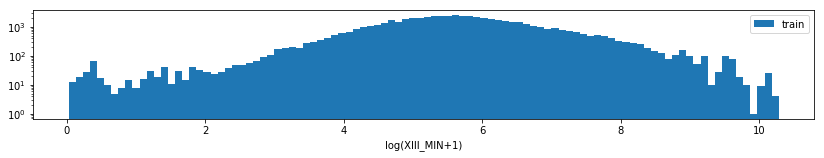

XIV_10 8.467


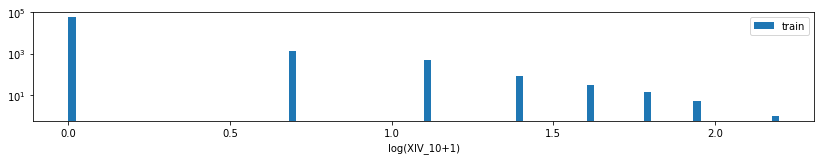

XIV_50 9.9951105


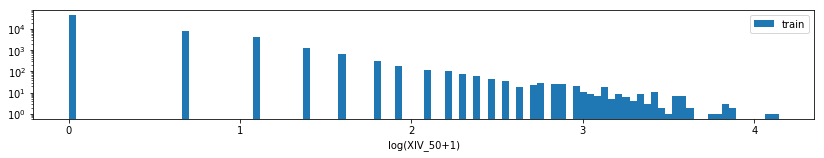

XIV_100 9.850256


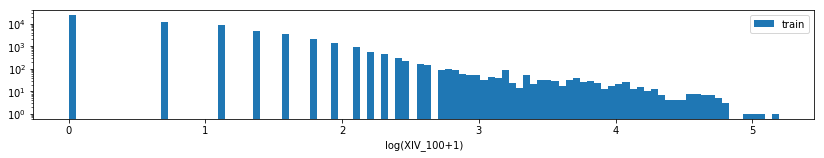

XIV_250 7.352517


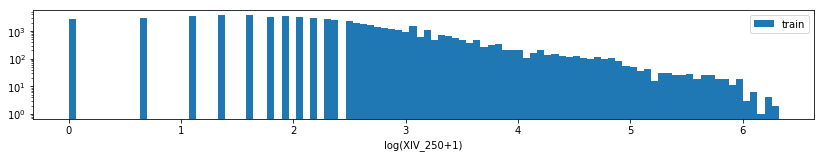

XIV_500 5.094125


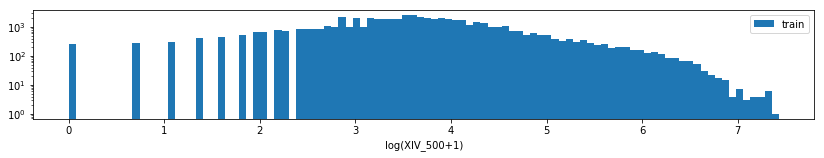

XIV_1000 3.6360552


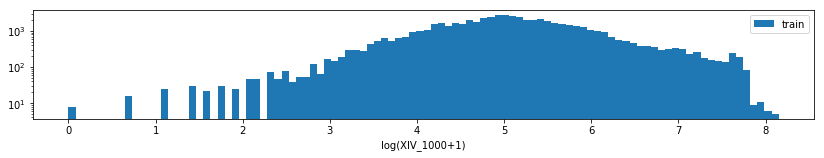

XIV_MIN 2.680964


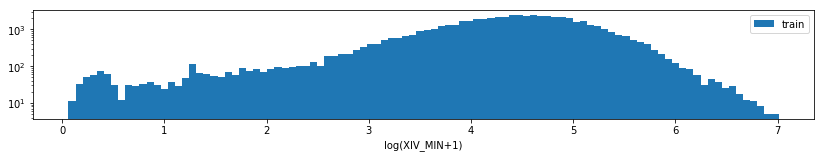

land_per_building_area 19.513025


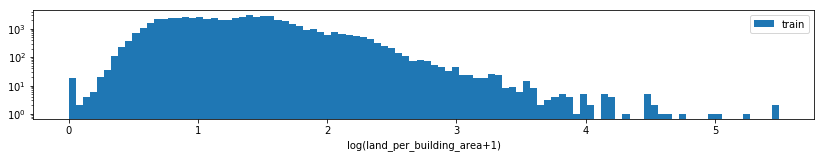

In [28]:
# skew check
for c in cols_right_skew:
    sq = df[c].astype('float32')
    print(c, sq.skew())
    plt.figure(figsize=(14, 2))
    sq = np.log1p(sq[np.isfinite(sq)])
    plt.hist(sq, bins=100, label='train', alpha=1)
    plt.legend(); plt.xlabel('log('+c+'+1)'); plt.yscale('log')
    plt.show()

In [29]:
for c in cols_right_skew:
    sq = df[c].astype('float32')
    print('% 21s'%c, '%6.3f'%sq.skew(), sq.min(), sq.max(), np.isfinite(sq).mean(), sq.isnull().mean())

         parking_area 38.441 0.0 967.37085 0.05171666666666667 0.9482833333333334
        parking_price  3.974 0.0 1020404.0 0.23225 0.76775
            land_area 43.667 0.0 5533.305 1.0 0.0
        building_area 83.711 0.36636943 3730.9832 1.0 0.0
village_income_median  2.812 411.0 1851.0 0.9809666666666667 0.019033333333333333
                 I_10 15.563 0.0 2.0 1.0 0.0
                 I_50  4.598 0.0 5.0 1.0 0.0
                I_100  3.046 0.0 8.0 1.0 0.0
                I_MIN  2.762 0.07943324 3591.2175 1.0 0.0
                II_10  6.965 0.0 4.0 1.0 0.0
                II_50  3.908 0.0 11.0 1.0 0.0
               II_100  2.913 0.0 20.0 1.0 0.0
               II_MIN  4.078 0.0098 3474.5273 1.0 0.0
               III_10  6.998 0.0 7.0 1.0 0.0
               III_50  3.051 0.0 12.0 1.0 0.0
              III_MIN  4.373 0.00020000013 4574.5405 1.0 0.0
                IV_10 17.978 0.0 2.0 1.0 0.0
                IV_50 10.386 0.0 10.0 1.0 0.0
               IV_100  8.617 0.0 15.0 1.0 

In [18]:
skew_results = []
for c in cols_num:
    if dfp[c].nunique() > 10 and dfp[c].max() > 20 and dfp[c].skew() > 2.2:
        skew_results.append(['%22s'%c, '%6.3f'%dfp[c].skew(), dfp[c].max(), dfp[c].median(), dfp[c].min()])
skew_results.sort(key= lambda x: x[1], reverse=True)
for row in skew_results:
    print(*row)

         building_area 83.711 3730.9832 6.9941854 0.36636943
             land_area 43.667 5533.305 16.482126 0.0
          parking_area 38.441 967.37085 5.7580233 0.0
land_per_building_area 19.513 242.05939 2.6272259 0.0
               XIII_50 18.247 33.0 0.0 0.0
              XIII_100 16.268 91.0 0.0 0.0
              XIII_250 11.759 185.0 0.0 0.0
               VIII_50 10.752 82.0 0.0 0.0
                XIV_50  9.995 62.0 0.0 0.0
               XIV_100  9.850 179.0 1.0 0.0
              VIII_MIN  8.002 4811.83 58.873146 0.01313965
                IV_250  7.775 47.0 0.0 0.0
              XIII_MIN  7.607 29131.598 276.12094 0.02349553
               XIV_250  7.353 555.0 9.0 0.0
               XII_MIN  7.230 2154.7197 31.320211 0.00020000013
                XI_MIN  7.088 13372.077 137.00848 0.2694137
              XIII_500  6.462 206.0 2.0 0.0
                IV_500  6.390 90.0 0.0 0.0
                 V_MIN  5.753 4901.133 104.86012 0.00020000013
                IX_MIN  5.401 6468.70

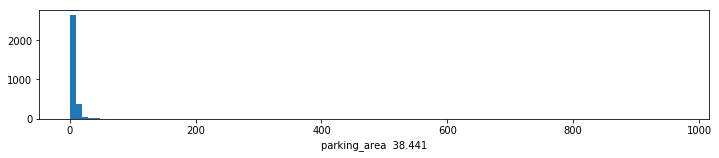

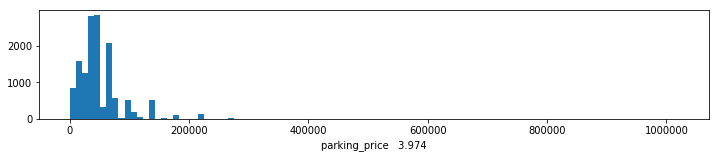

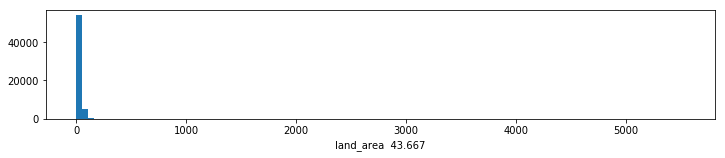

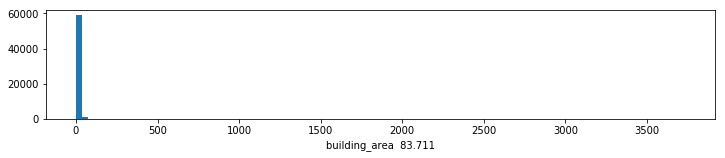

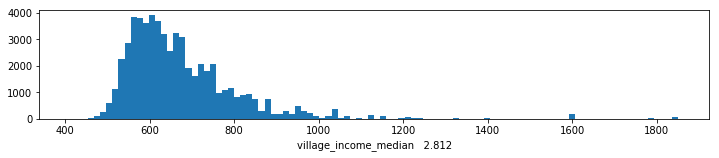

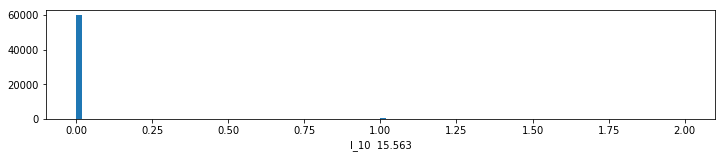

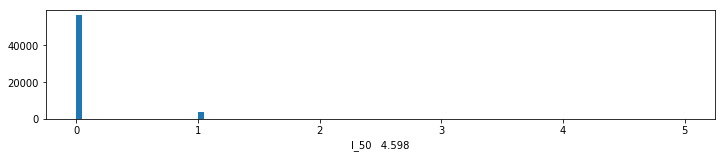

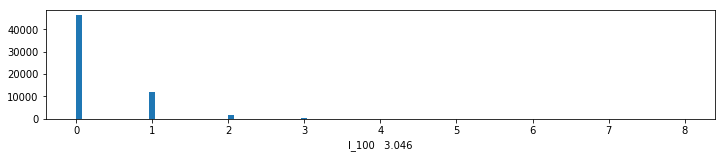

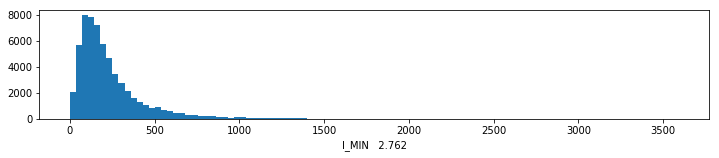

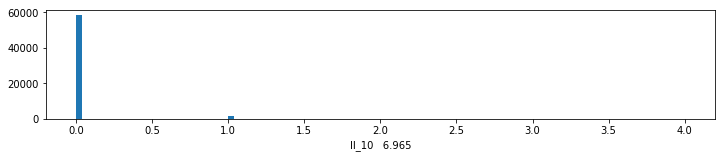

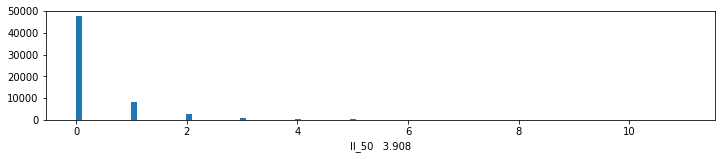

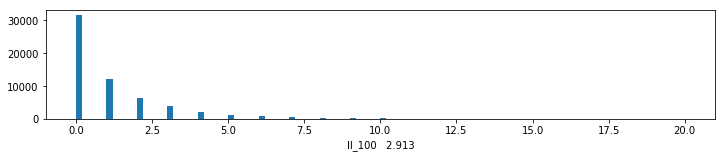

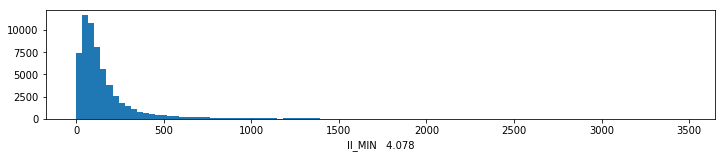

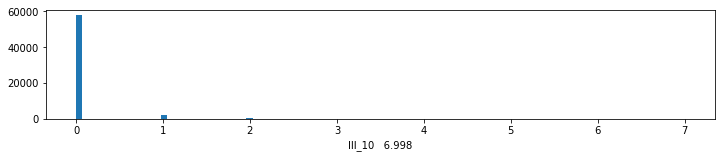

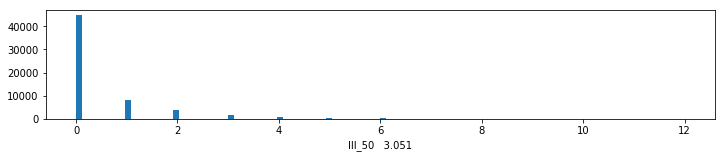

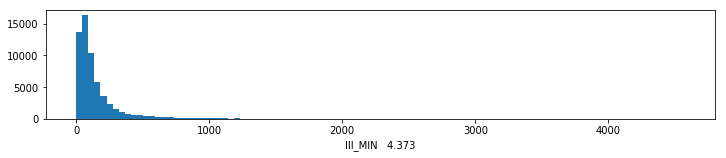

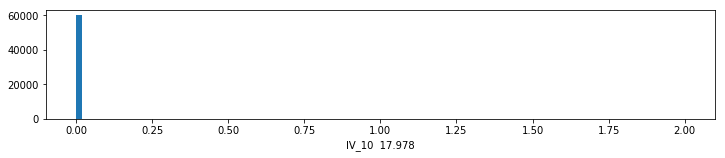

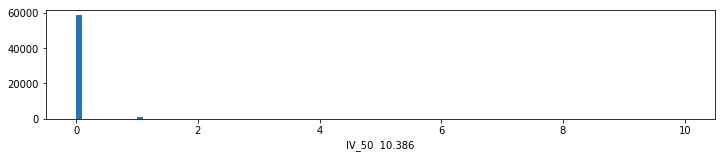

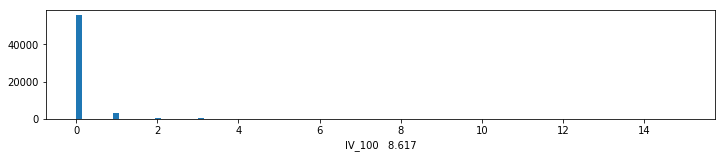

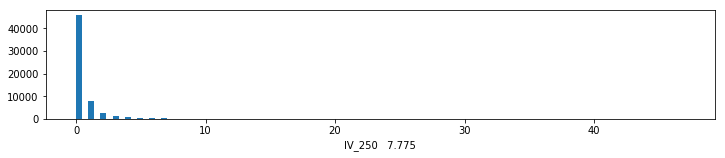

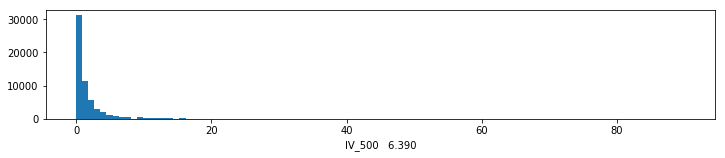

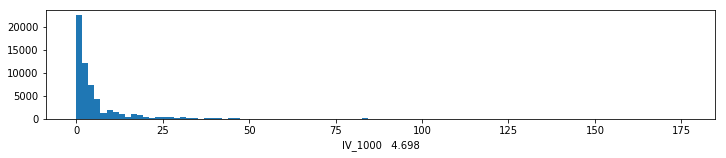

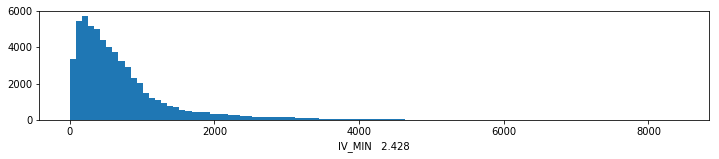

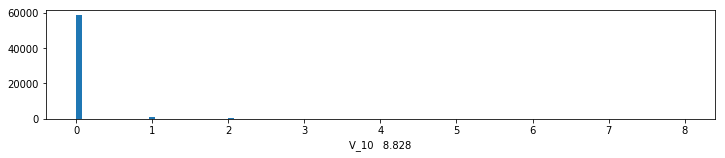

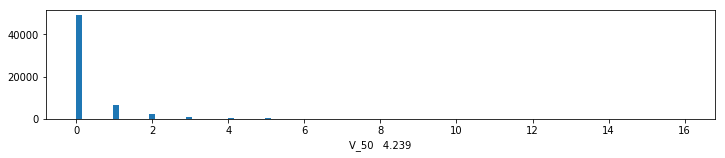

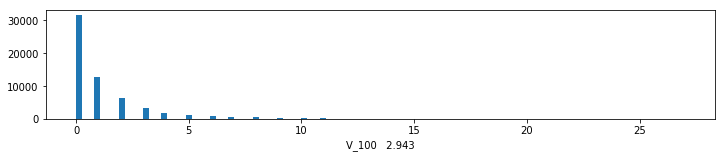

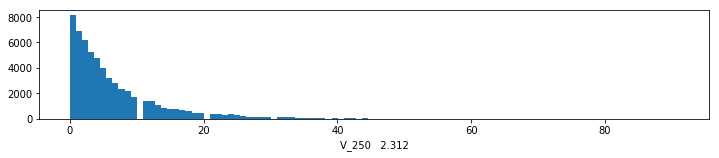

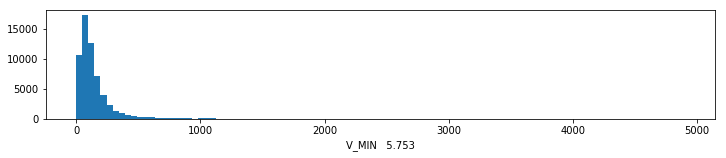

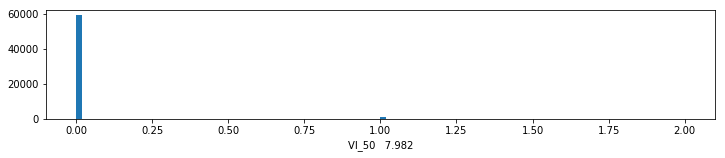

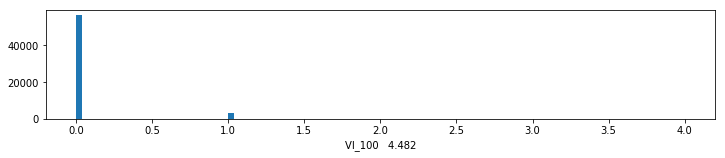

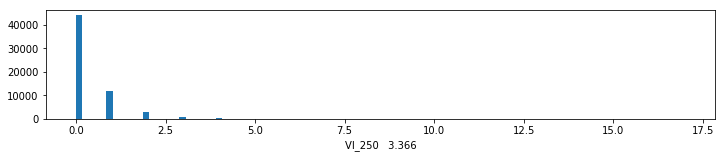

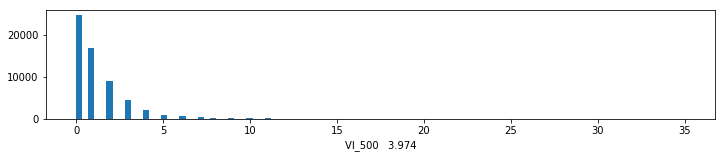

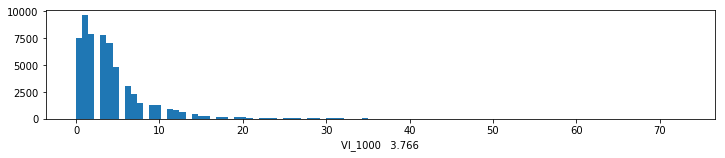

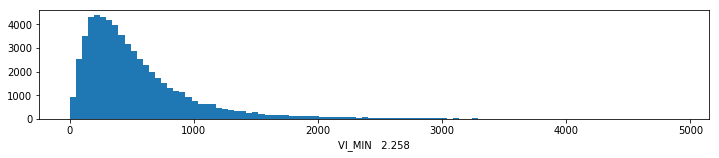

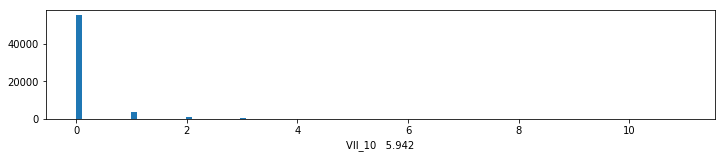

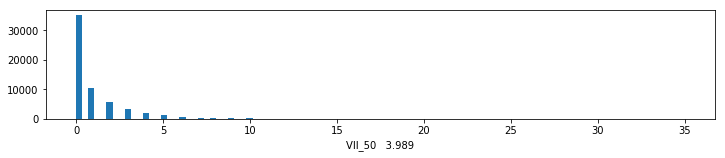

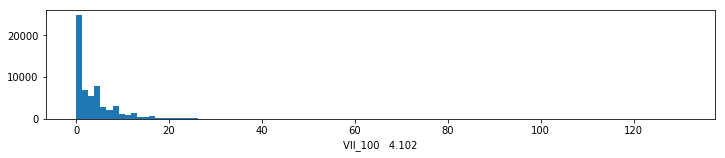

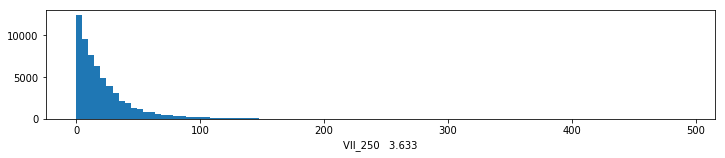

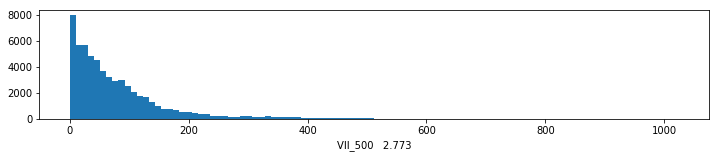

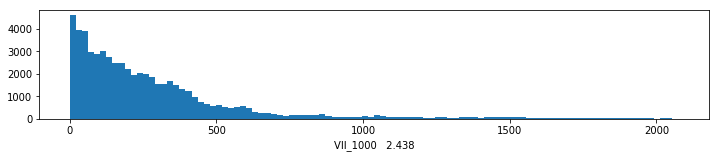

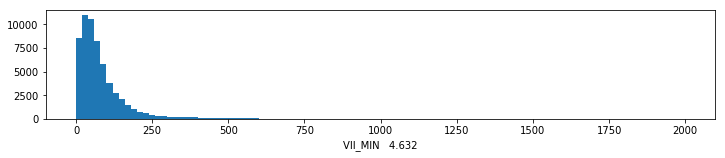

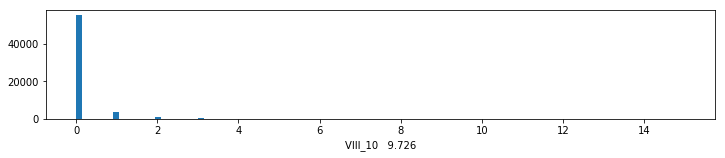

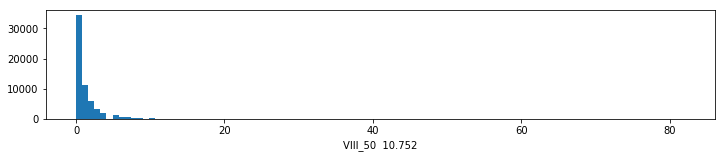

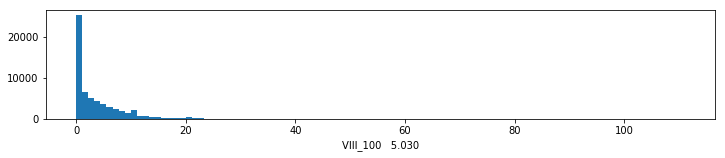

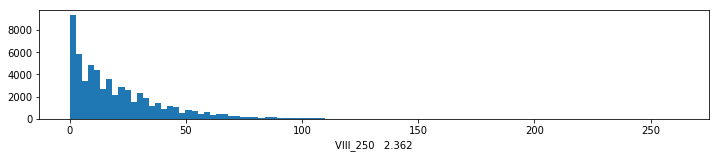

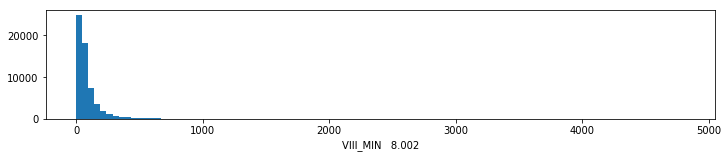

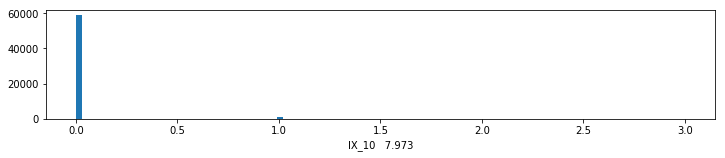

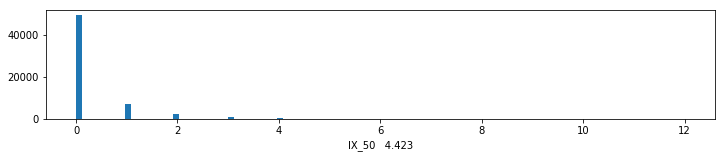

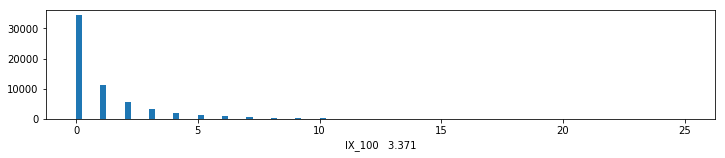

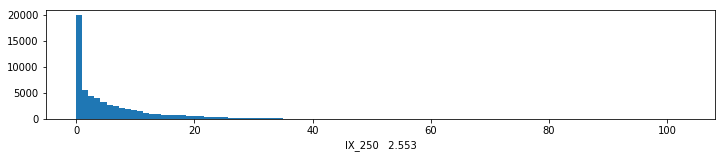

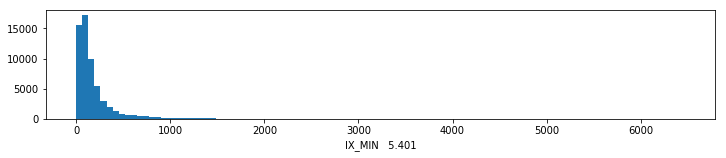

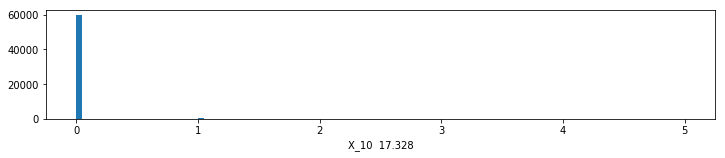

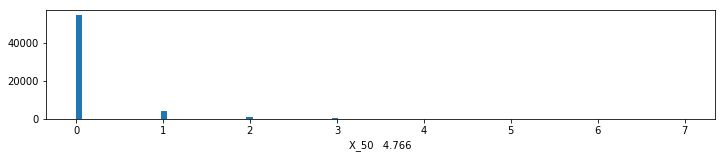

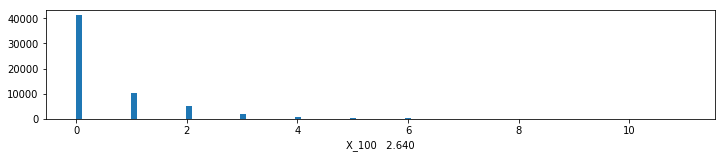

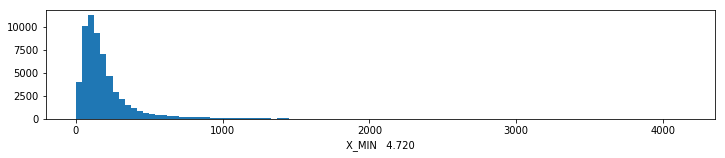

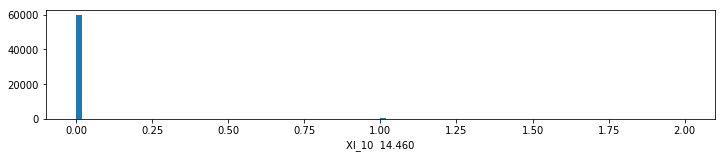

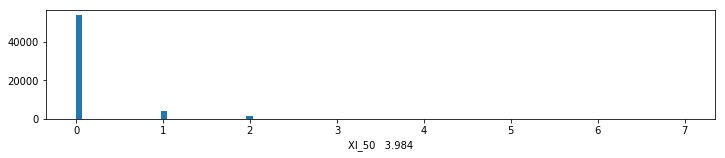

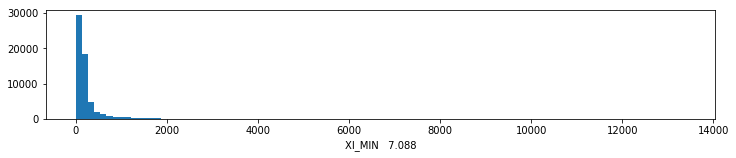

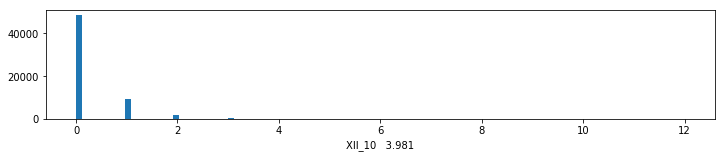

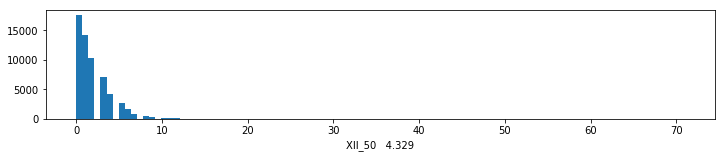

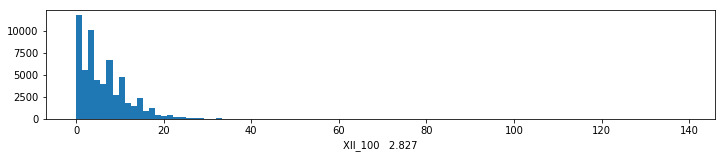

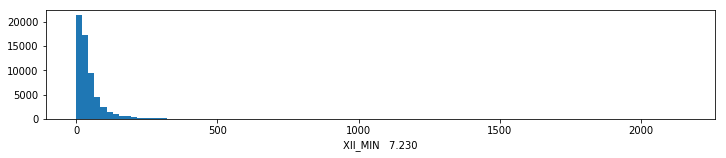

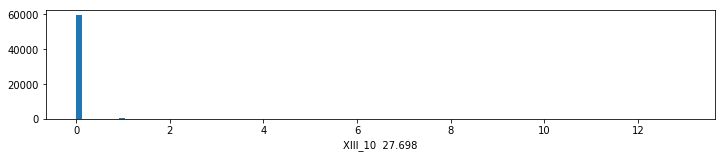

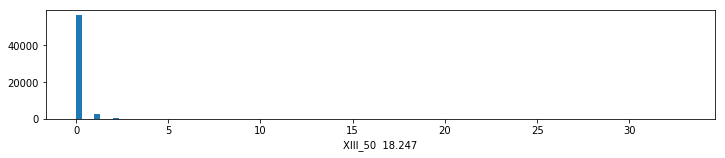

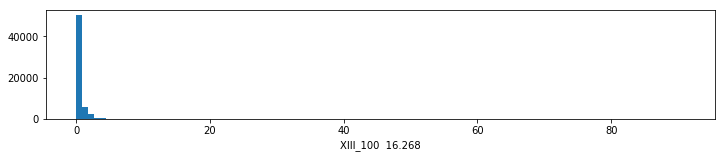

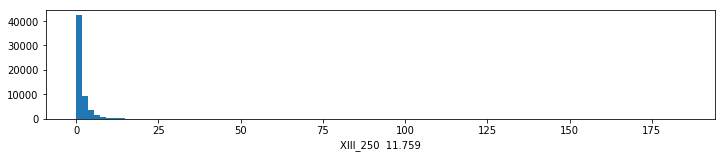

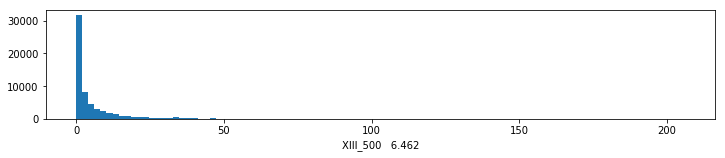

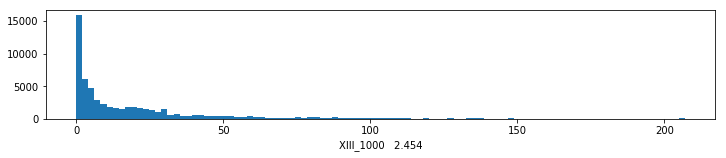

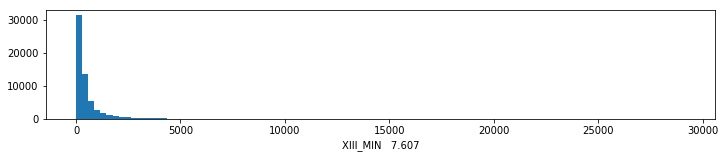

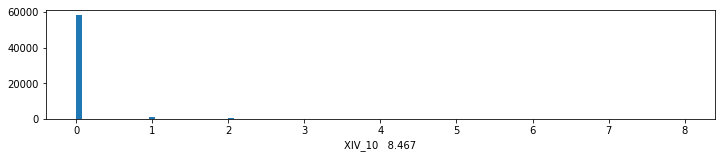

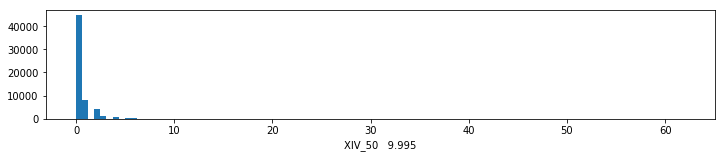

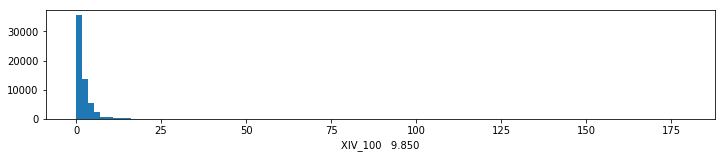

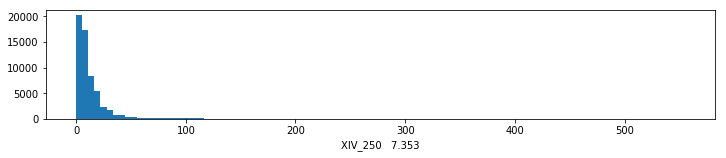

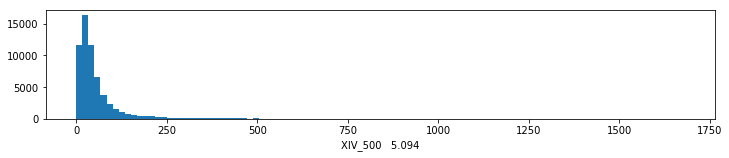

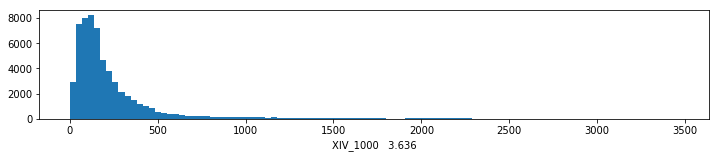

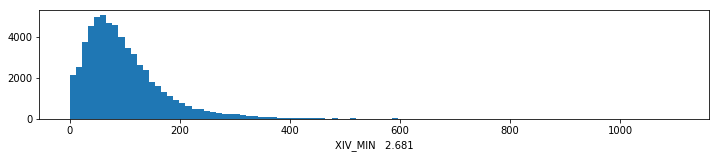

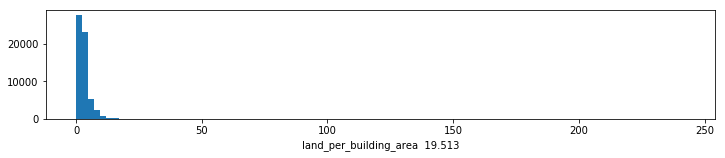

In [30]:
for c in cols_num:
    skew_c = dfp[c].skew()
    if skew_c > 2.2:
        sq = dfp[c]
        sq = sq[np.isfinite(sq)]
        plt.figure(figsize=(12, 2))
        plt.hist(sq, bins=100)
        plt.xlabel(c+'  %6.3f'%skew_c); plt.show()

#### VIllage and Town

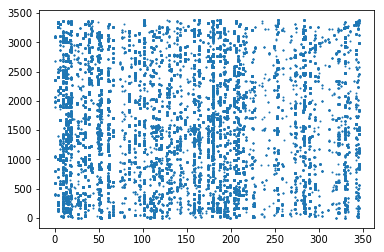

In [31]:
plt.scatter(dfp['town'], dfp['village'], s=1)
plt.show()

In [36]:
(dfp['village'].value_counts() == 1).sum()

288

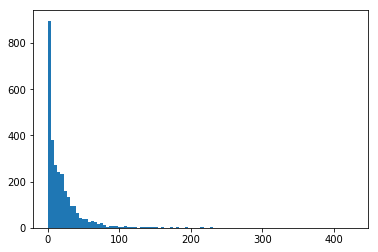

In [35]:
plt.hist(dfp['village'].value_counts(), bins=400)
plt.show()

### Feature engineering
Include cat encoding, fillna, scaling

In [9]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [10]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False,
                 n_ran_encode=4):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Cat encoders
        self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras')
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df):
        df = df.copy()    
        # Cat encoders
        df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
        self.cols_tar_encoded = [c for c in df_tar_encoded]
        for c in df_tar_encoded:
            df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
        for c in df_tar_encoded:
            df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

#### Debug

In [12]:
# for debug only
feat_eng_t = FeatureEngineering(cols_num, cols_cat, cols_bin, col_target,
                                fillna_values, cols_right_skew, is_embedding=is_embedding)

In [13]:
dfp2 = feat_eng_t.fit_transform(dfp)

In [14]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 253 entries, building_id to land_per_building_area
dtypes: float32(212), int32(8), int64(10), object(23)
memory usage: 65.5+ MB


In [15]:
dfp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 262 entries, building_id to log_per_area_total_price_scaled
dtypes: float32(221), int32(8), int64(10), object(23)
memory usage: 67.5+ MB


In [16]:
dfp2['building_area_ori'].check()

0         3.418175
1         4.041309
2         5.584279
3        13.563030
4         4.688108
59995     6.754059
59996     5.356788
59997     8.223644
59998     8.728287
59999     5.356788
Name: building_area_ori, dtype: float32

shape = (60000,)


In [17]:
dfp2.loc[:, cols_right_skew].check()

,parking_area,parking_price,land_area,building_area,village_income_median,I_10,I_50,I_100,I_MIN,II_10,...,XIII_1000,XIII_MIN,XIV_10,XIV_50,XIV_100,XIV_250,XIV_500,XIV_1000,XIV_MIN,land_per_building_area
0,-0.231141,-0.548478,-0.034321,-1.083755,-0.832583,-0.065183,-0.263001,1.703675,-0.832046,-0.171635,...,0.145465,-0.749270,-0.180916,1.286209,0.868860,0.785981,0.462953,-0.006479,-0.815420,1.077574
1,-0.231141,-0.548478,-0.585236,-0.850874,-1.054259,-0.065183,-0.263001,1.703675,-0.821228,-0.171635,...,0.378751,-1.739329,-0.180916,1.286209,0.259084,-0.011966,-0.217229,-0.333009,-0.653663,0.146355
2,-0.231141,-0.548478,0.162689,-0.398604,-0.331743,-0.065183,-0.263001,1.703675,-0.861084,-0.171635,...,0.766046,-0.398741,-0.180916,-0.568642,0.639647,0.969325,0.739957,0.308603,-0.324044,0.598467
3,-0.231141,1.949962,-0.585236,0.853831,2.034907,-0.065183,-0.263001,-0.544676,1.450282,-0.171635,...,-1.986968,1.164134,-0.180916,-0.568642,0.259084,-0.904404,-0.530962,-0.245559,0.325351,-1.563488
4,-0.231141,-0.548478,1.410950,-0.643622,-1.199987,-0.065183,-0.263001,-0.544676,1.476255,-0.171635,...,-1.986968,1.440665,-0.180916,-0.568642,-1.152160,-0.904404,-0.629102,-1.270909,0.561897,2.421389
59995,-0.231141,-0.548478,1.190228,-0.131352,-0.638337,-0.065183,-0.263001,-0.544676,0.909380,-0.171635,...,-0.823375,0.891123,-0.180916,-0.568642,-1.152160,-0.254354,-1.272990,-1.145050,0.731163,1.598644
59996,3.912365,2.041708,-1.760647,-0.456933,0.622895,-0.065183,-0.263001,1.703675,-1.076028,-0.171635,...,1.117989,-1.999798,-0.180916,2.611255,1.356574,1.021490,0.852773,0.727418,-1.464716,-1.661464
59997,-0.231141,1.899042,-0.585236,0.146071,-0.277742,-0.065183,-0.263001,-0.544676,-0.444238,-0.171635,...,0.674563,0.063775,-0.180916,-0.568642,0.259084,0.540864,1.086681,0.828638,0.271905,-0.873087
59998,-0.231141,-0.548478,0.249229,0.230130,0.086478,-0.065183,3.735125,1.703675,-1.818665,-0.171635,...,0.632523,-1.414836,-0.180916,2.087661,1.033406,-0.011966,-0.400700,-0.111814,-0.858804,0.051958
59999,-0.231141,-0.548478,-0.148090,-0.456933,-0.006669,-0.065183,-0.263001,1.703675,-1.144050,-0.171635,...,0.766046,-0.394989,-0.180916,1.286209,0.639647,0.169854,0.703279,0.477385,-0.470801,0.274764


shape = (60000, 77)


In [18]:
feat_eng_t.col_target

'log_per_area_total_price'

In [19]:
dfp2.loc[:, ['log_per_area_total_price', 'log_per_area_total_price_scaled']].check()

,log_per_area_total_price,log_per_area_total_price_scaled
0,12.151933,-1.414603
1,13.619346,0.103992
2,14.354281,0.864561
3,13.862462,0.355588
4,11.999613,-1.572236
59995,11.892310,-1.683281
59996,14.892412,1.421462
59997,14.177902,0.682030
59998,14.544024,1.060923
59999,14.278423,0.786057


shape = (60000, 2)


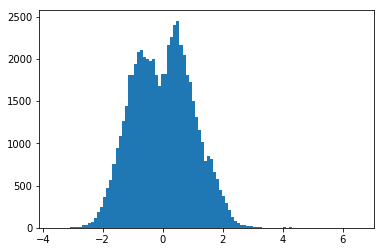

In [20]:
plt.hist(dfp2['log_per_area_total_price_scaled'], bins=100); plt.show()

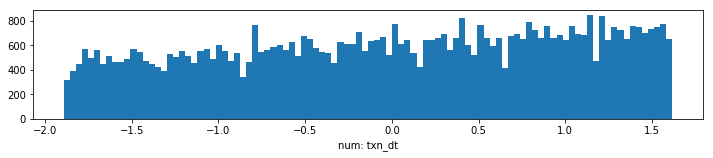

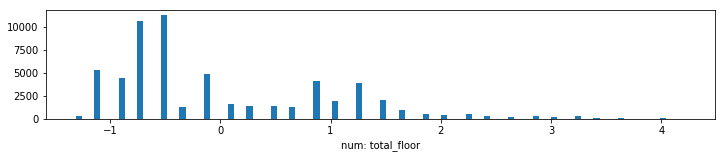

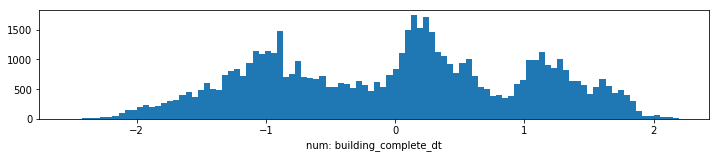

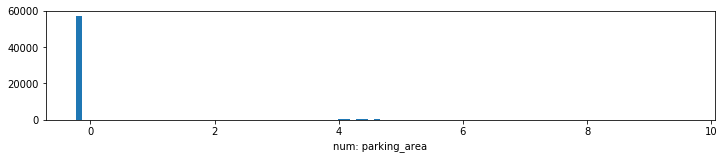

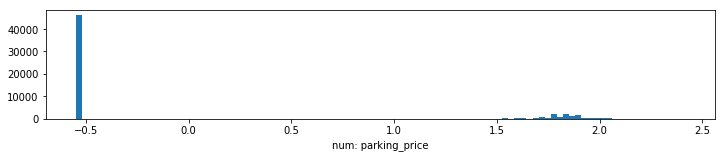

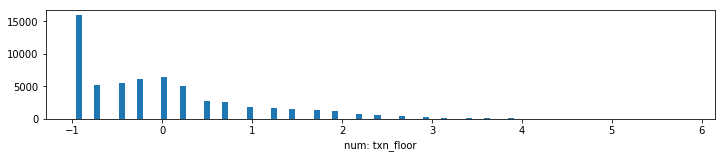

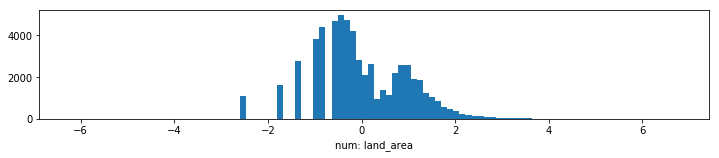

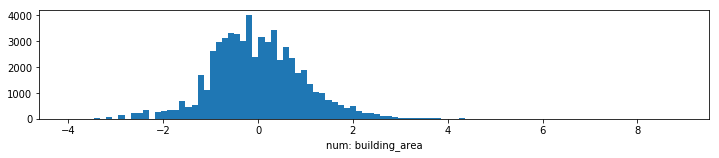

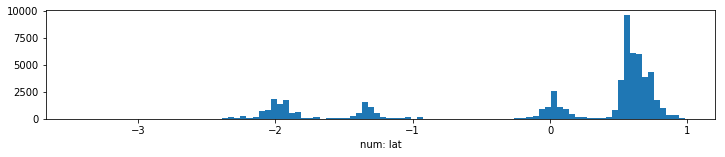

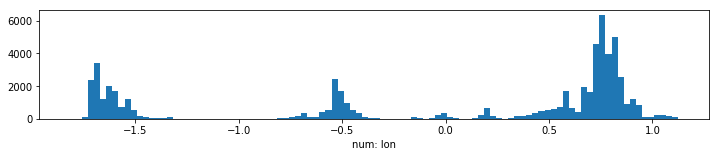

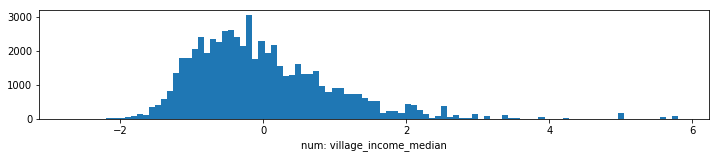

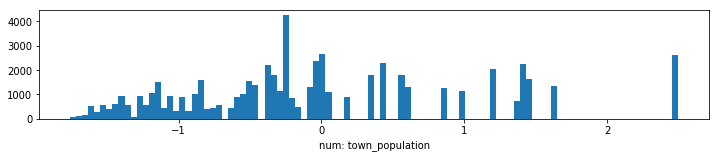

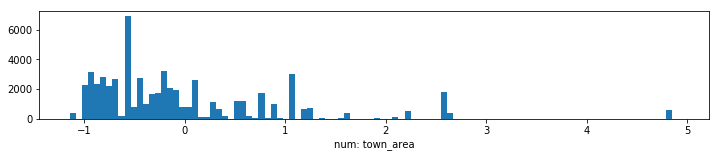

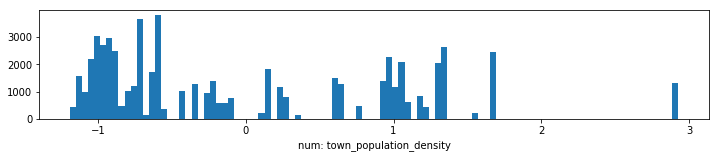

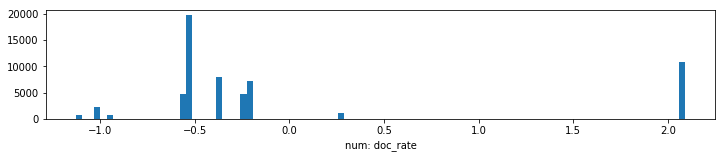

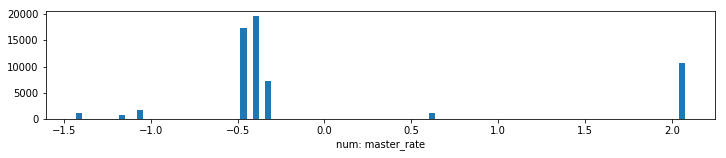

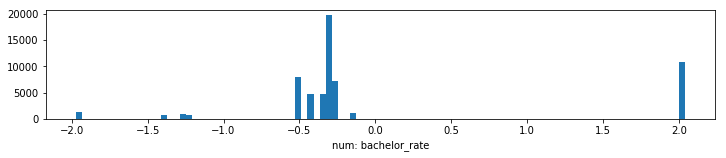

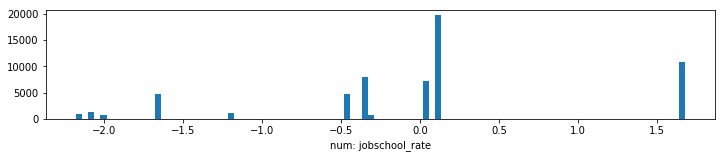

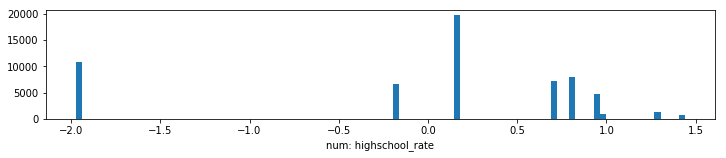

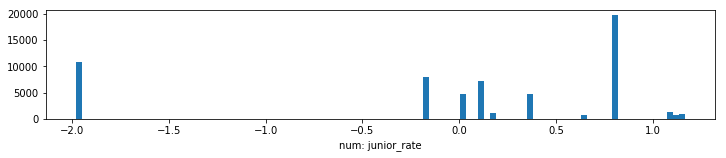

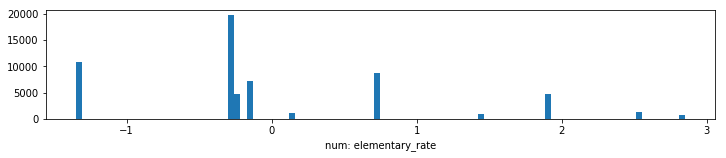

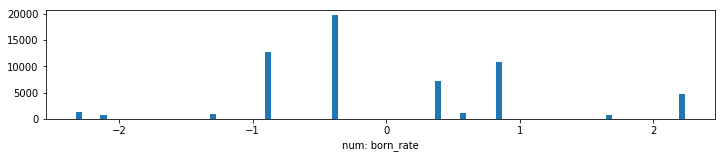

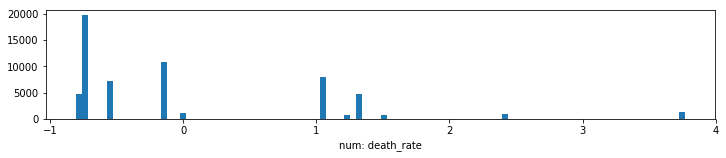

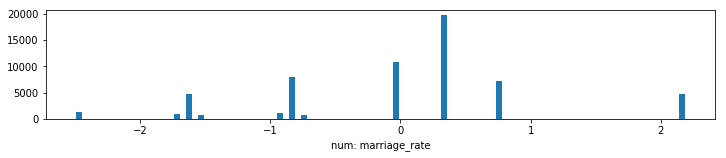

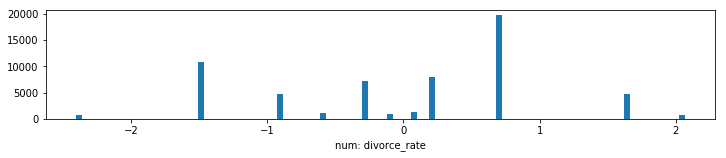

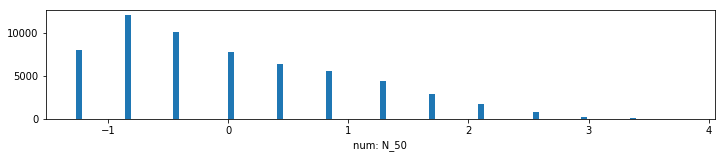

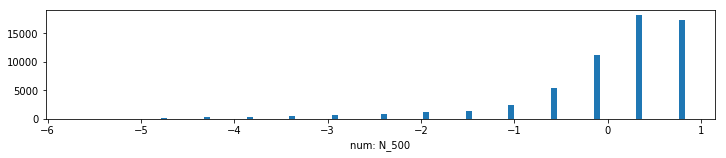

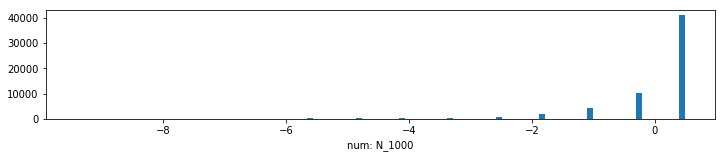

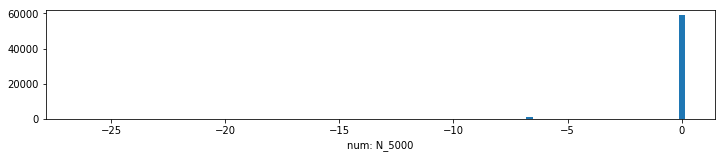

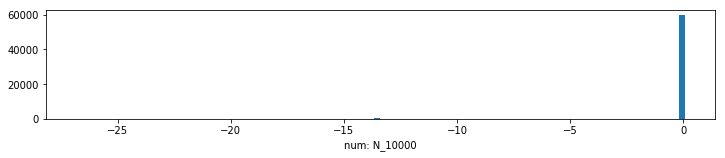

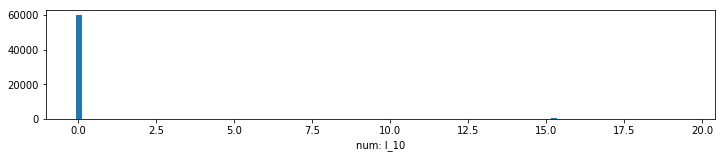

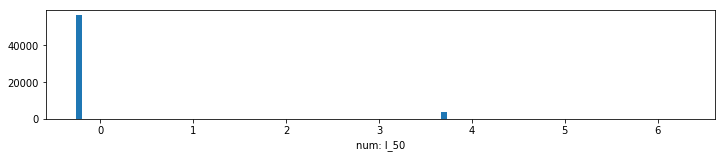

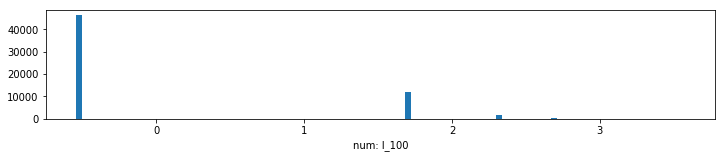

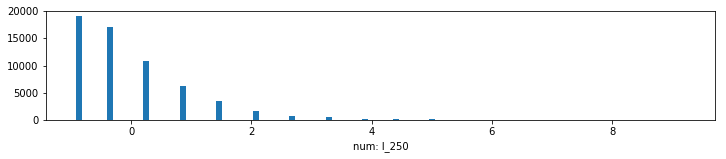

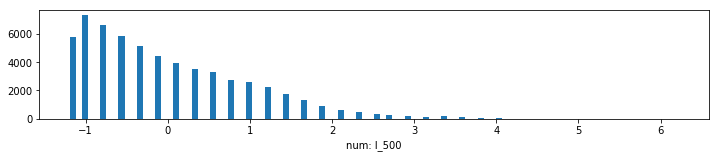

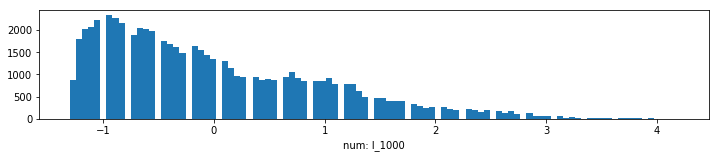

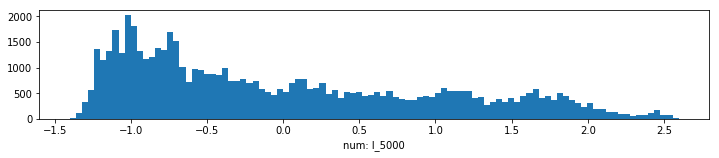

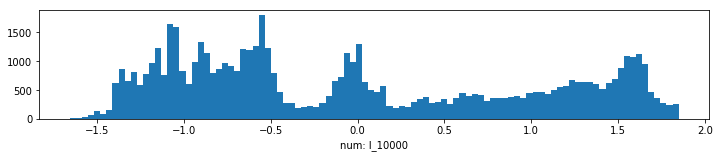

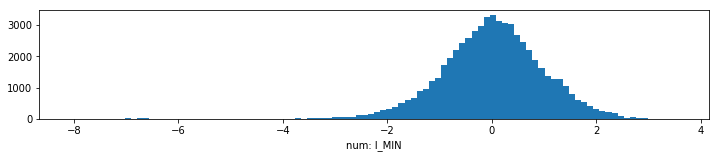

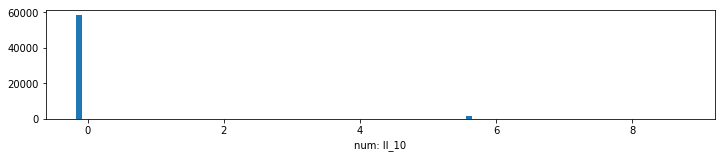

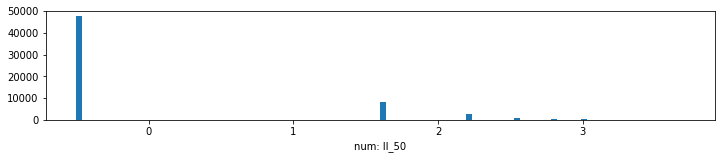

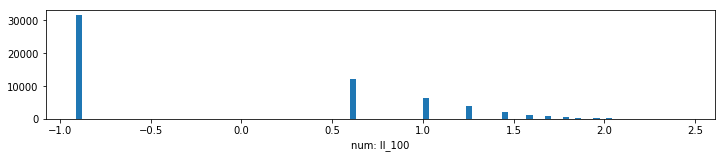

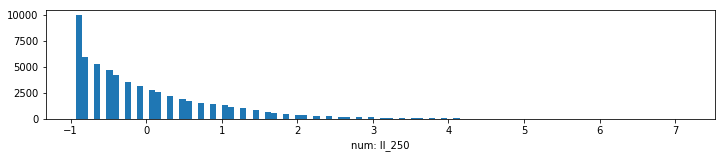

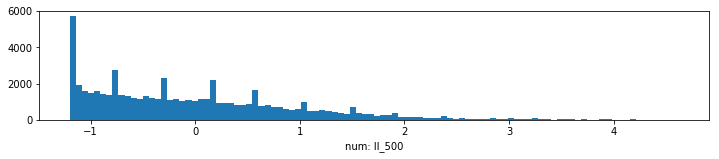

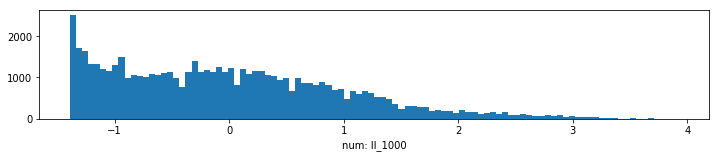

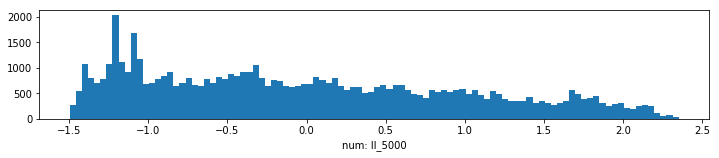

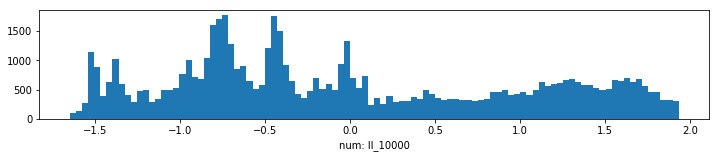

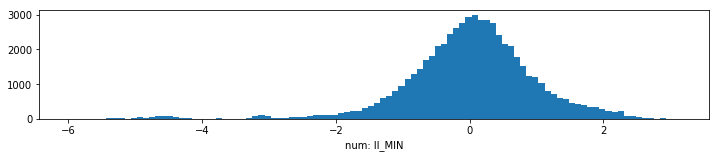

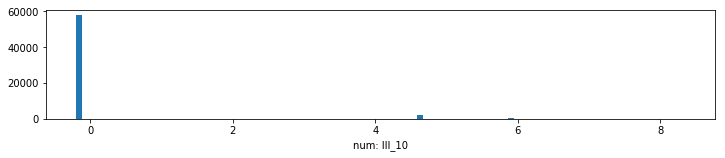

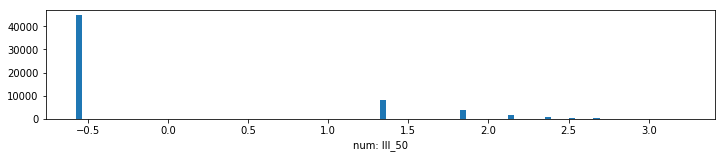

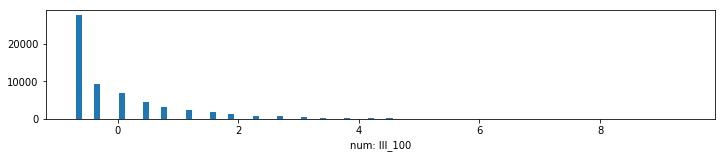

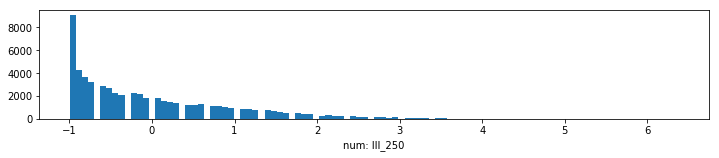

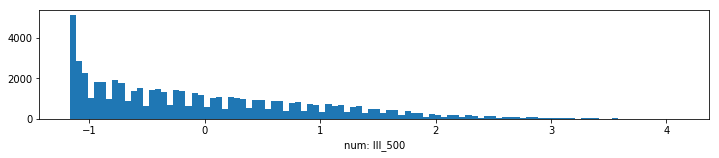

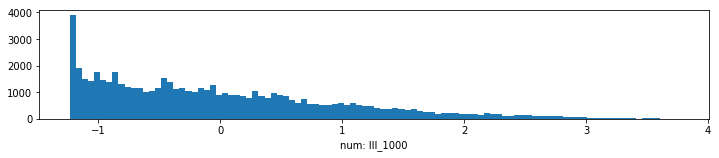

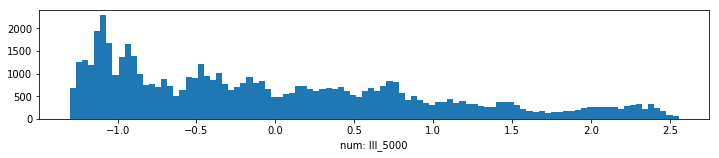

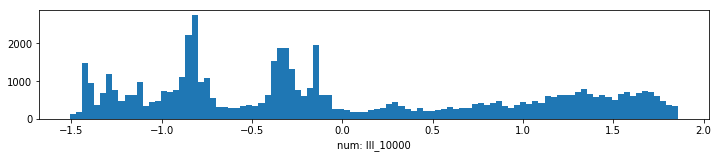

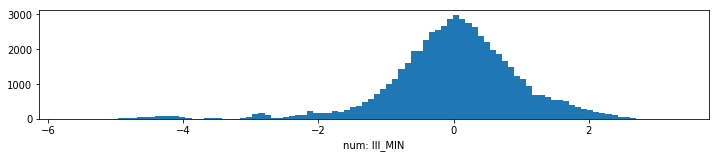

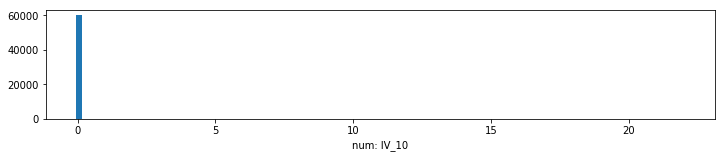

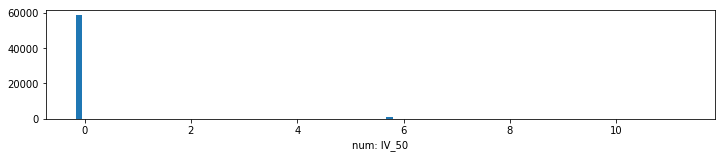

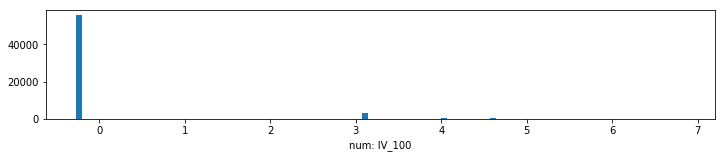

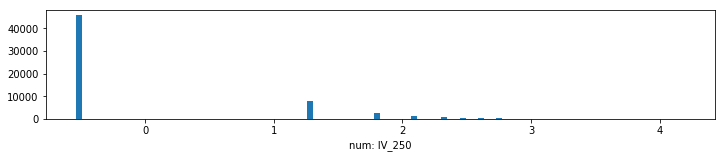

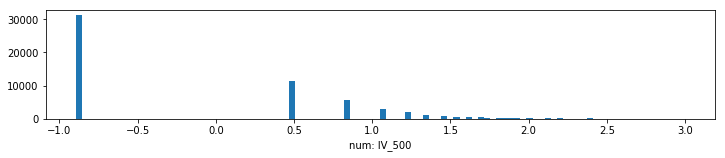

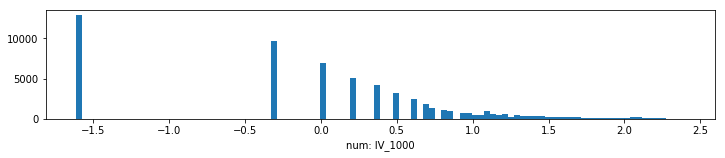

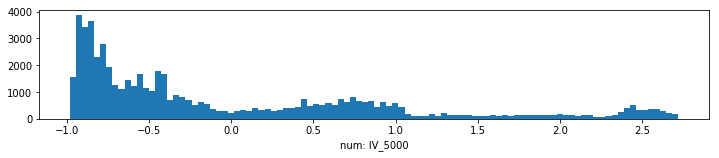

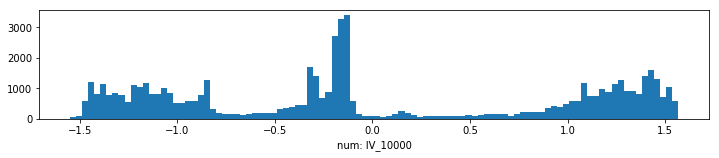

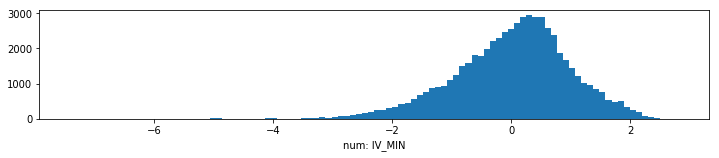

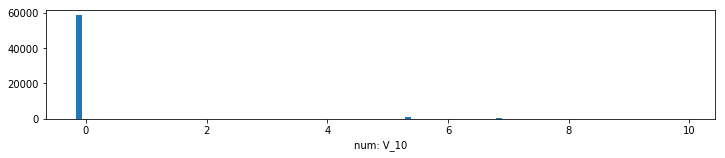

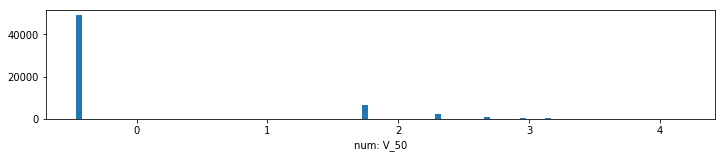

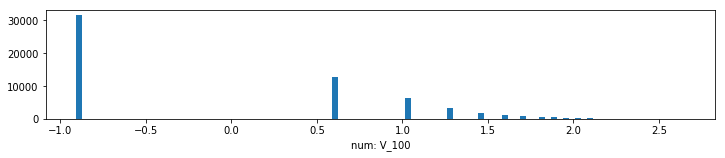

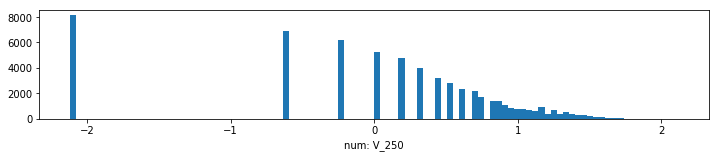

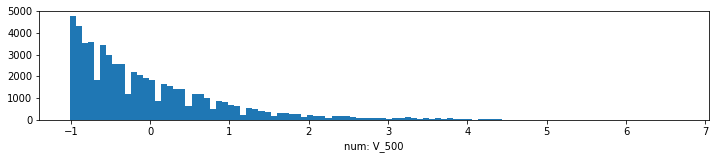

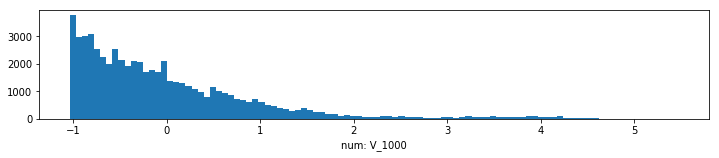

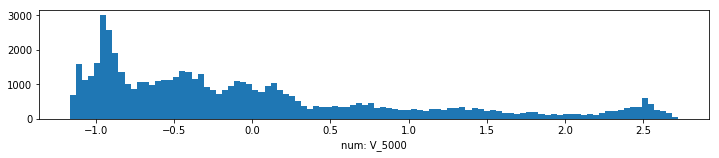

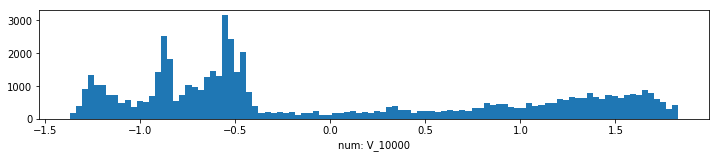

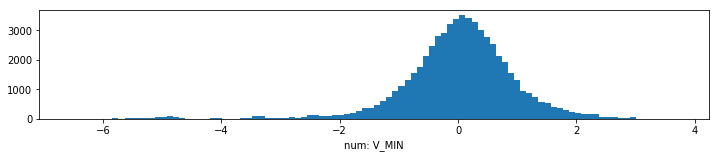

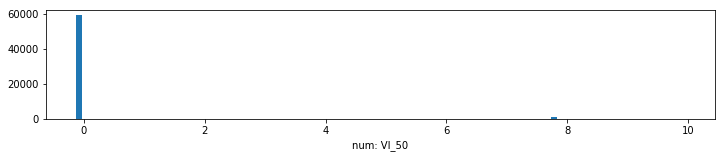

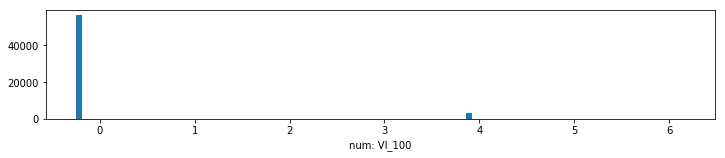

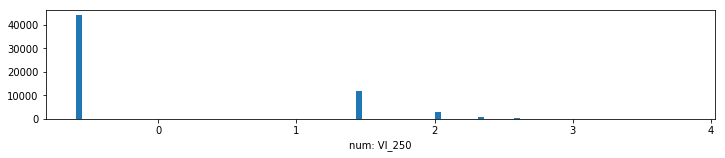

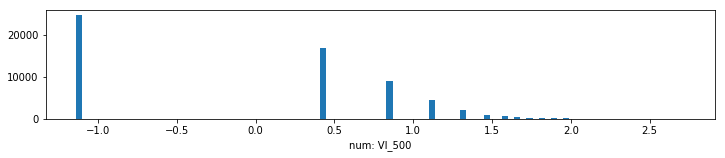

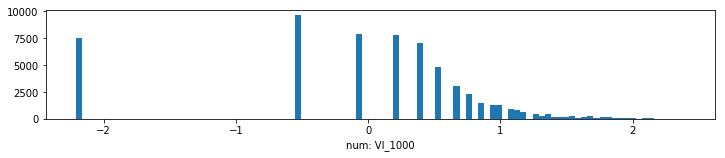

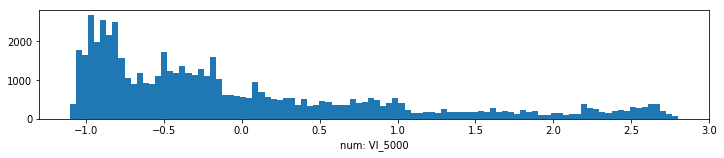

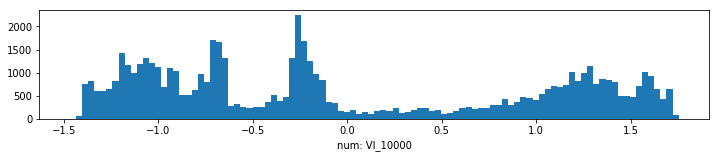

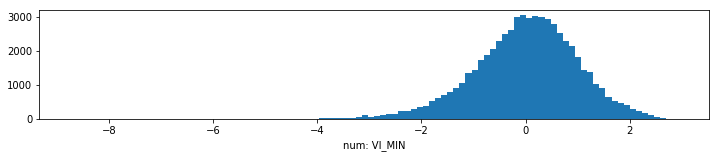

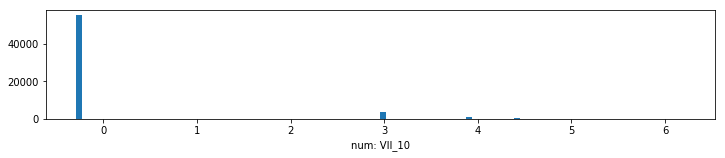

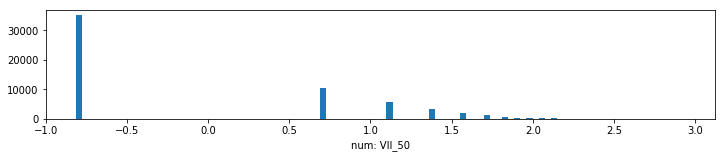

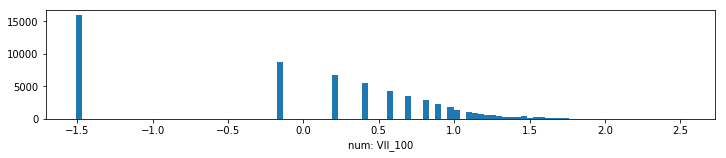

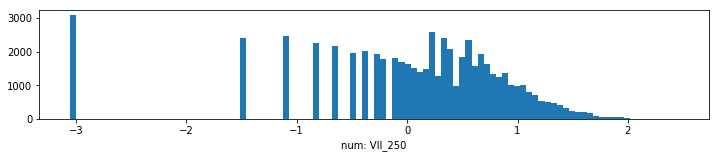

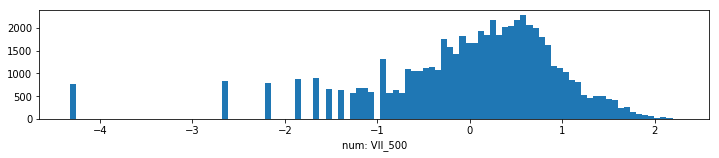

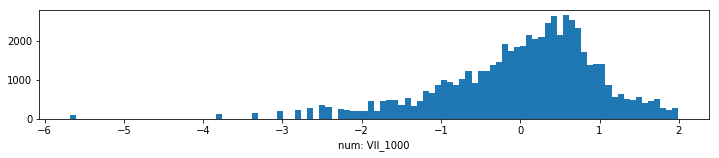

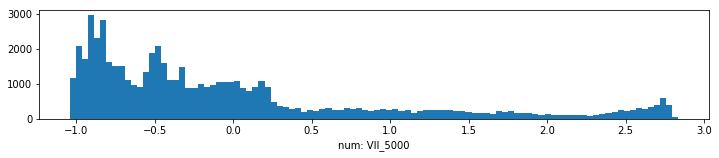

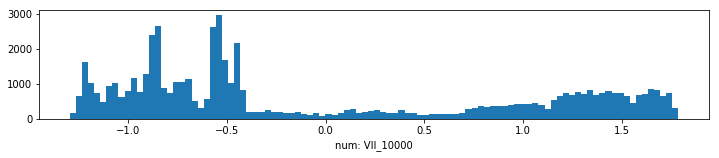

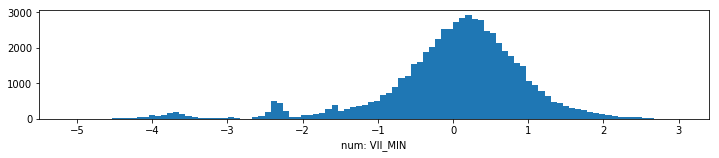

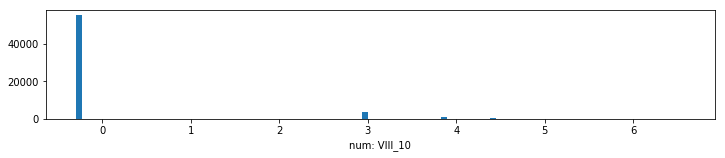

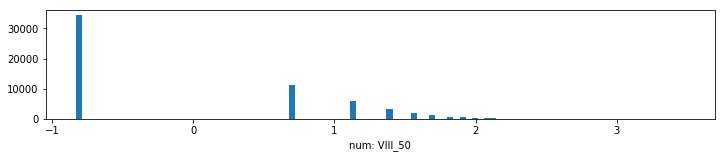

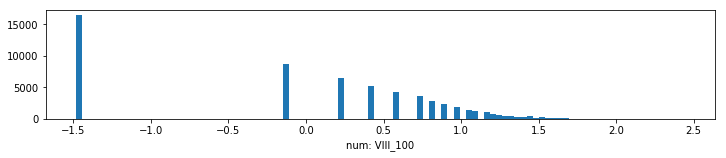

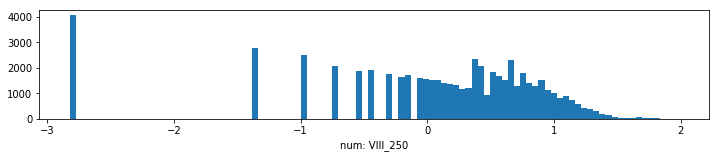

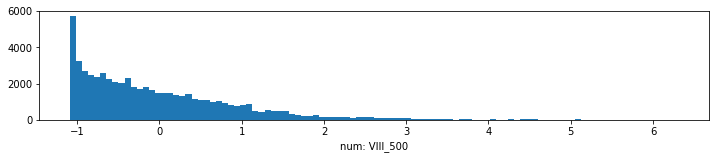

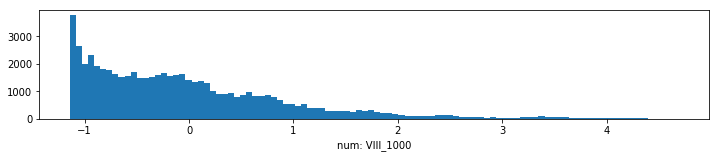

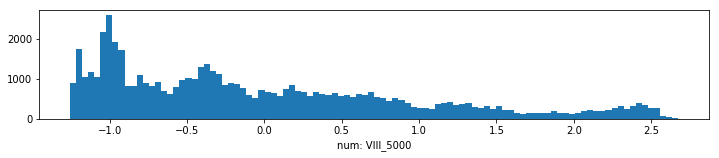

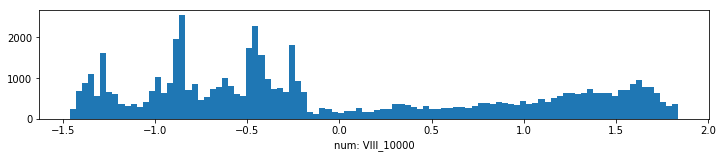

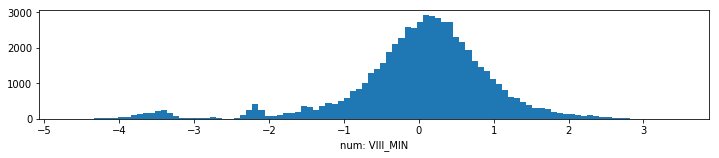

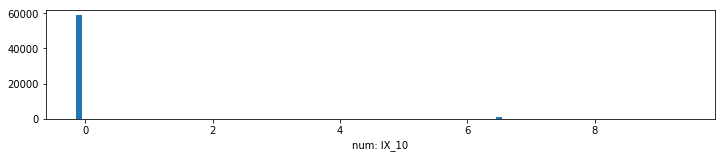

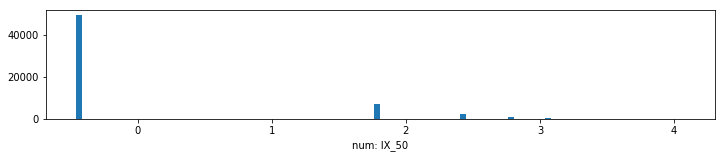

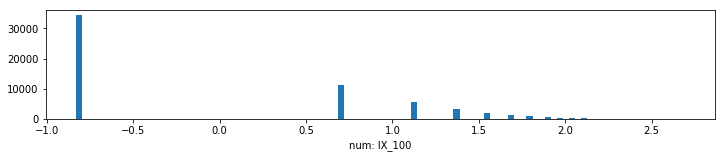

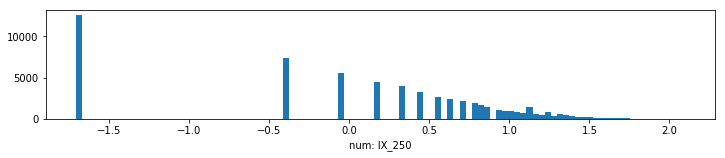

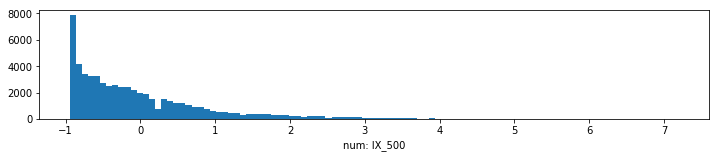

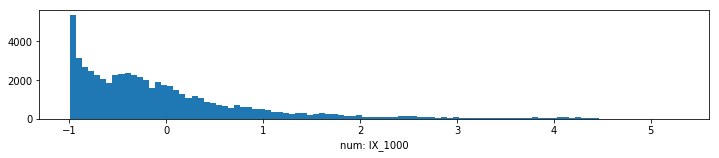

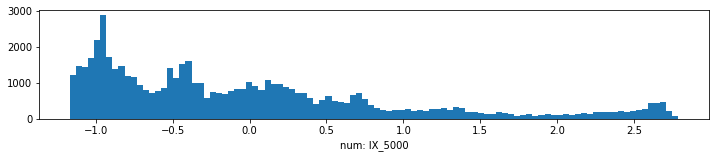

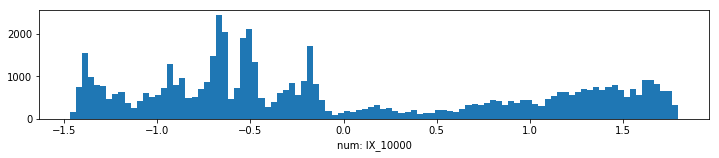

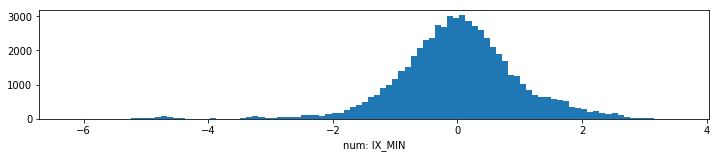

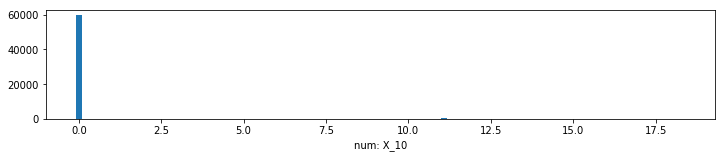

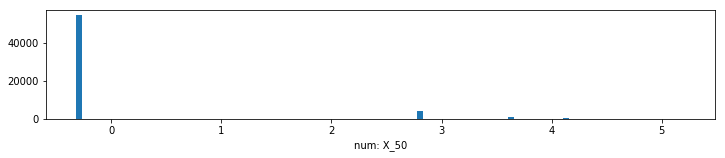

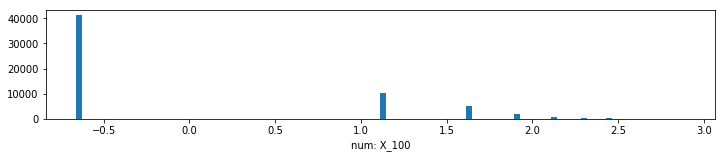

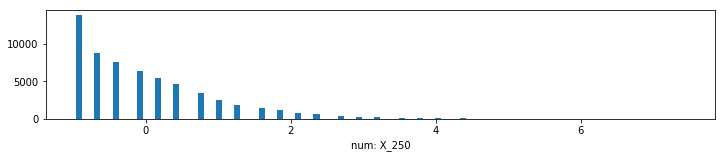

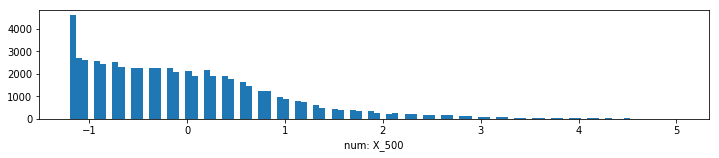

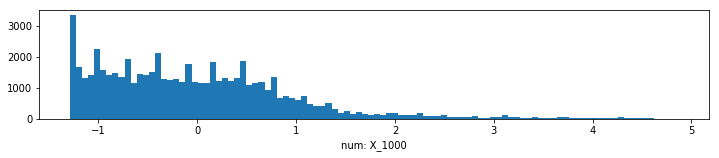

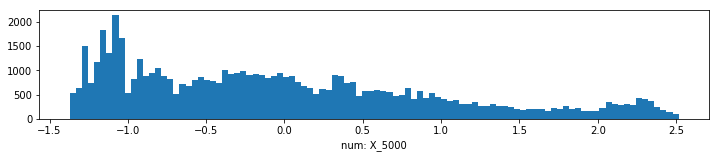

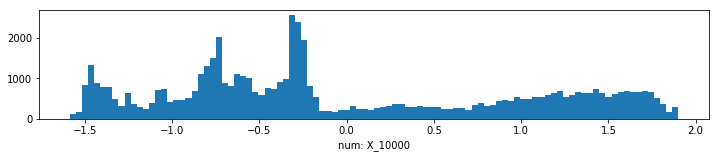

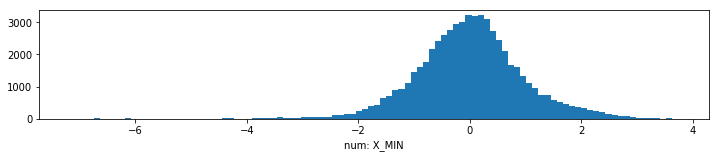

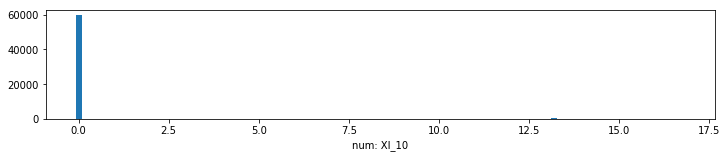

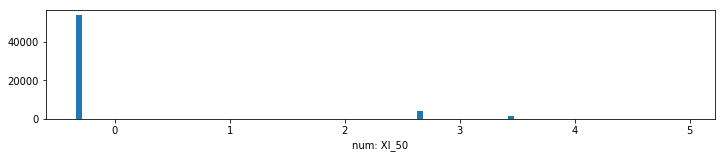

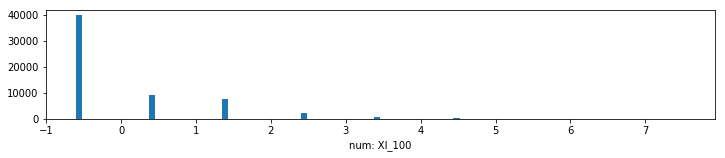

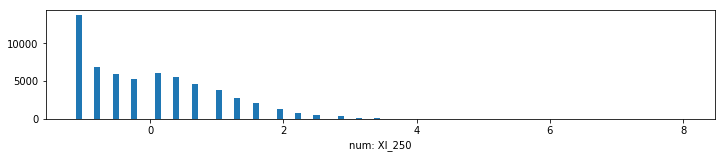

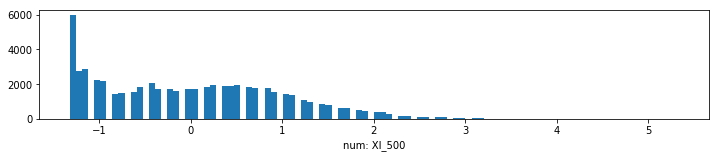

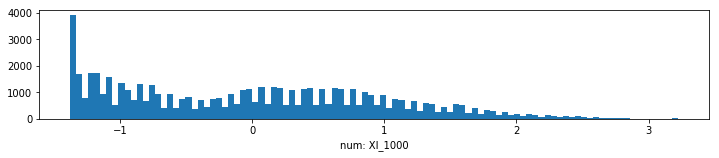

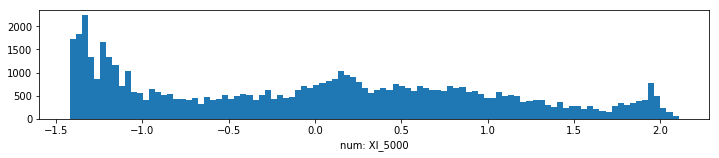

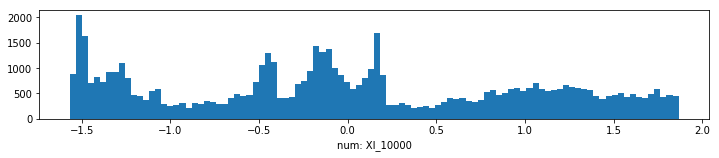

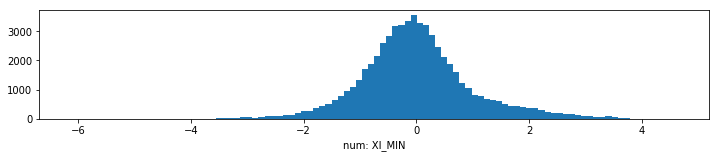

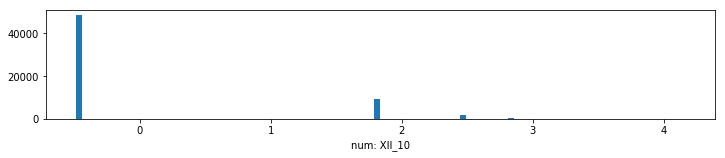

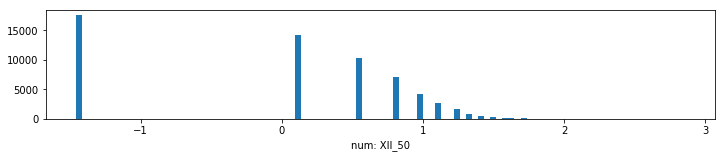

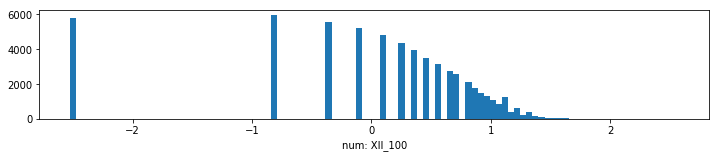

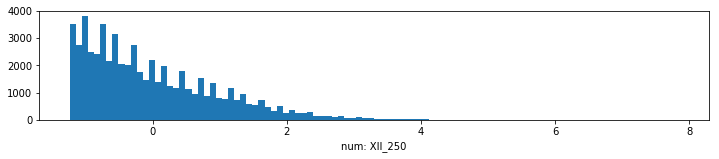

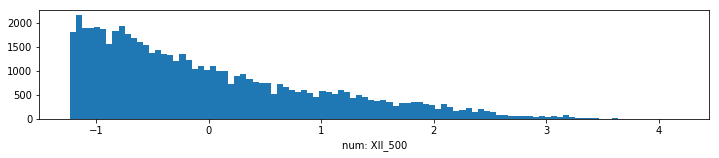

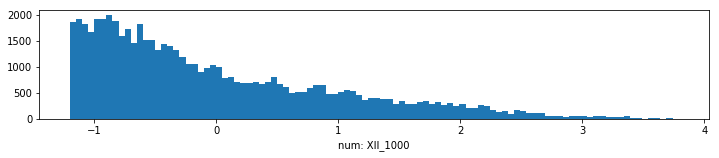

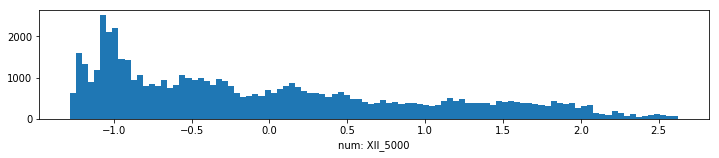

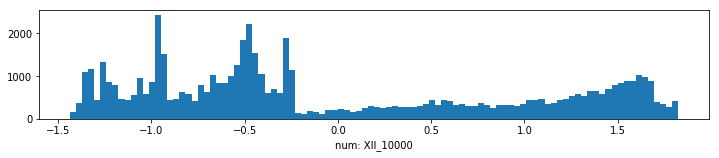

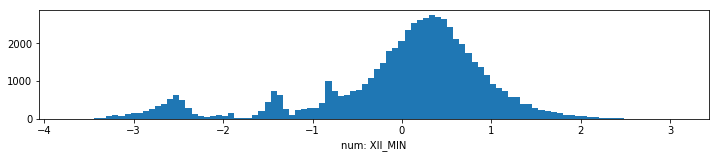

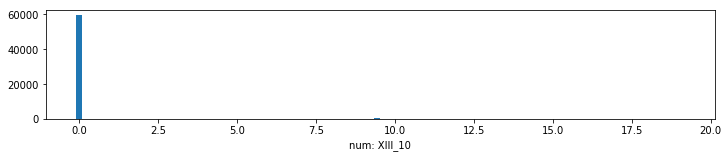

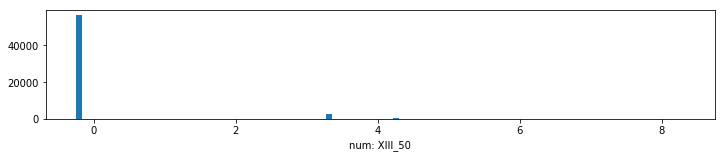

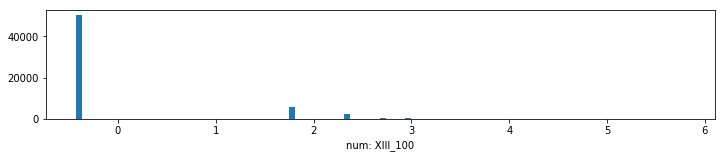

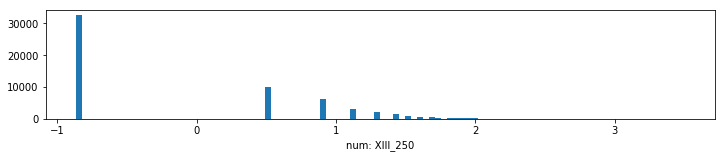

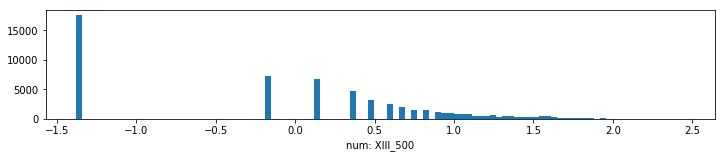

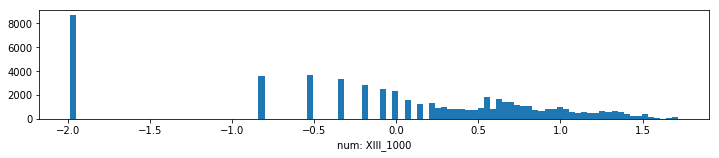

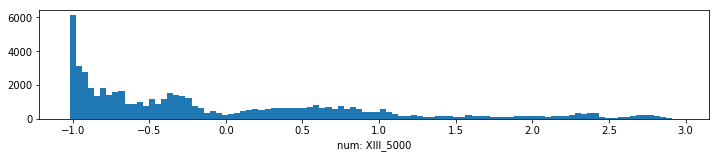

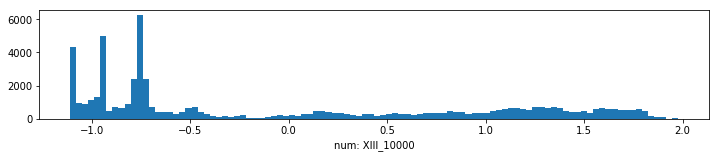

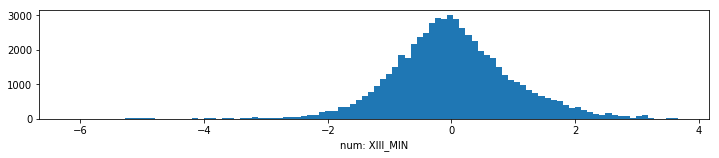

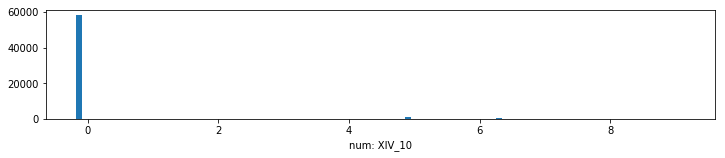

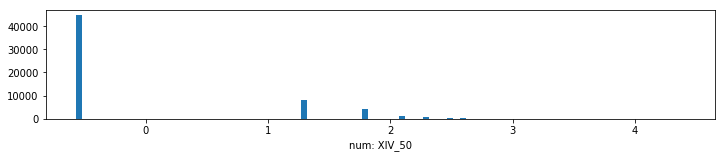

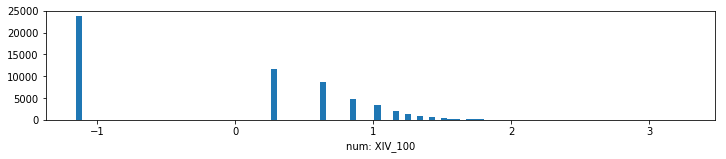

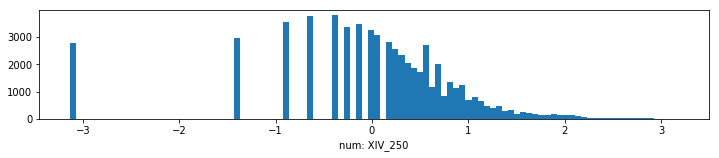

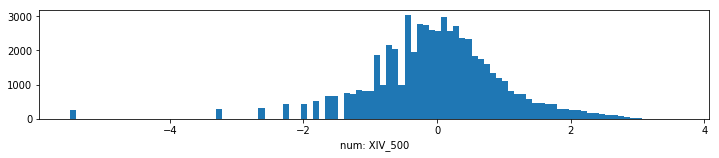

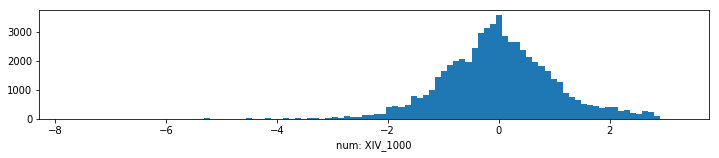

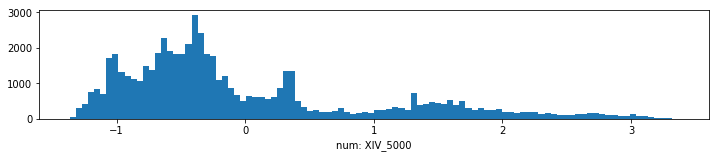

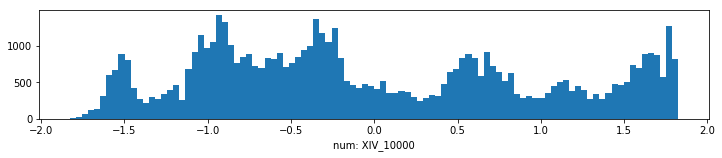

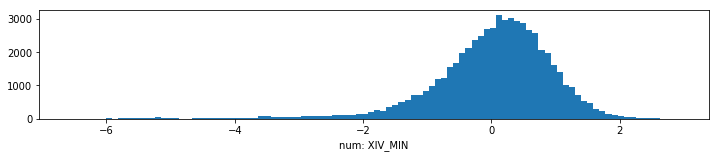

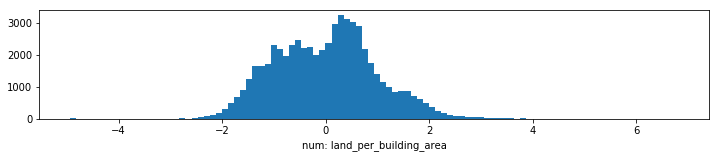

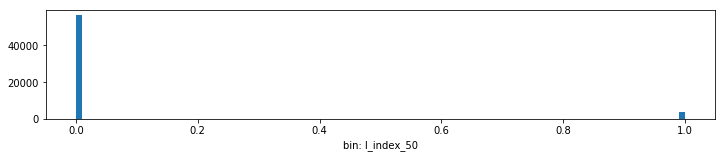

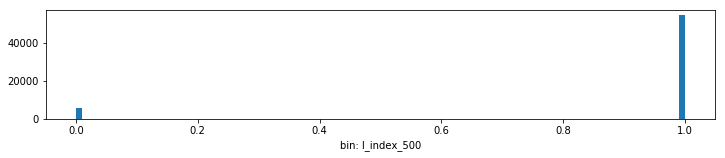

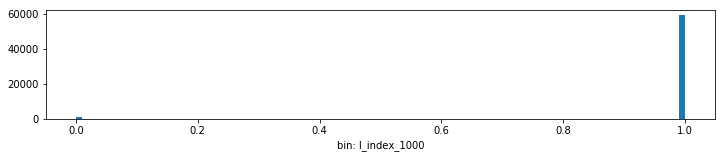

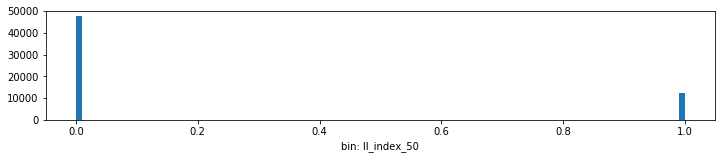

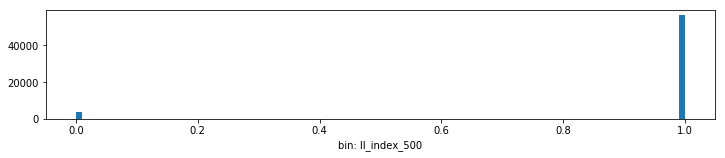

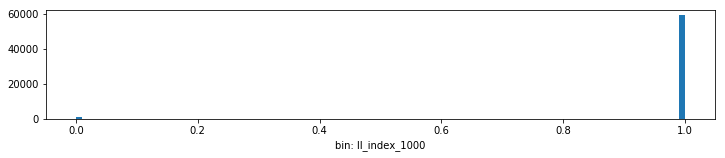

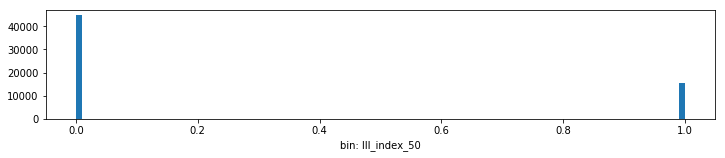

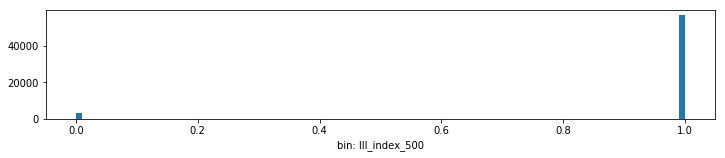

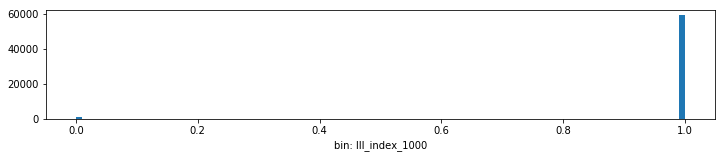

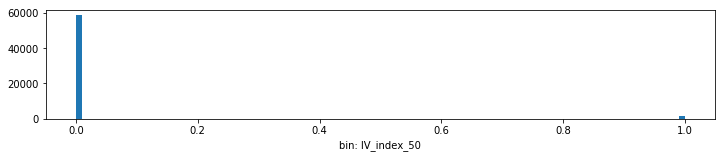

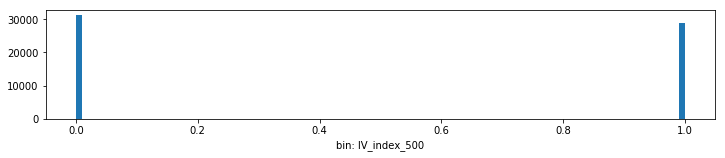

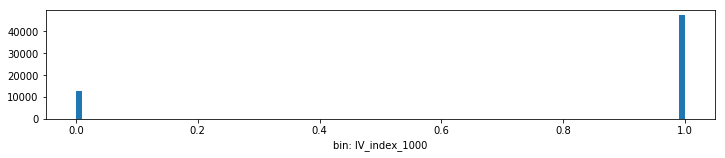

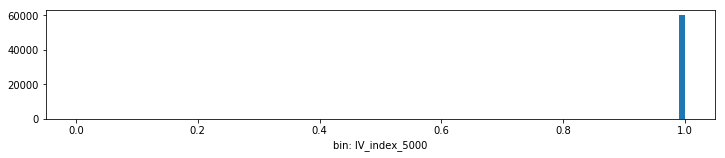

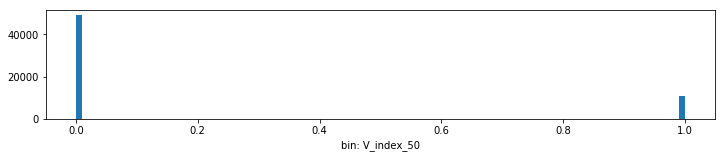

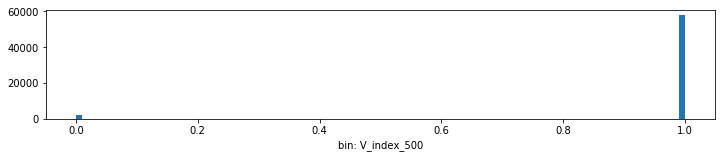

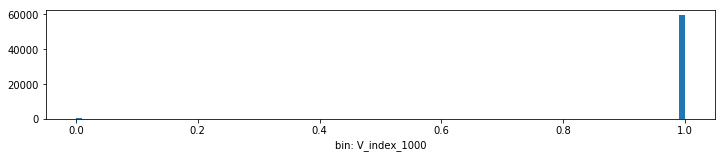

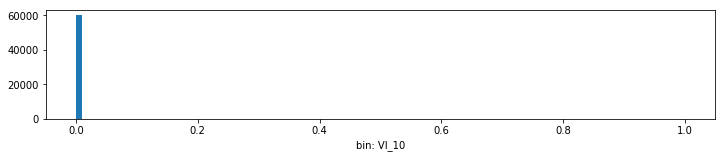

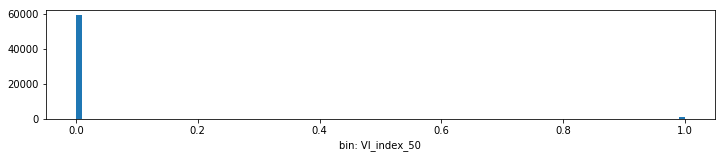

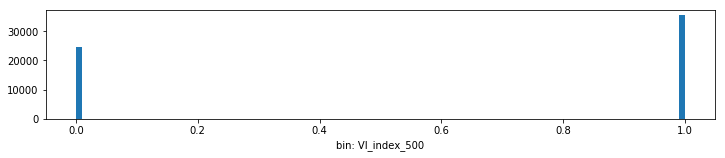

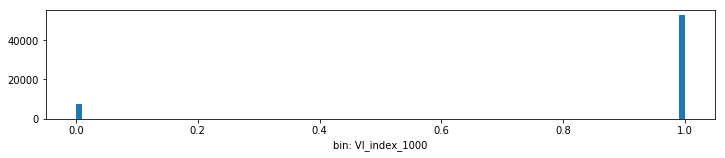

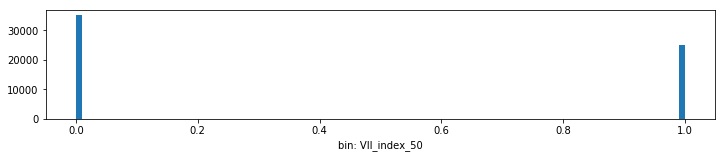

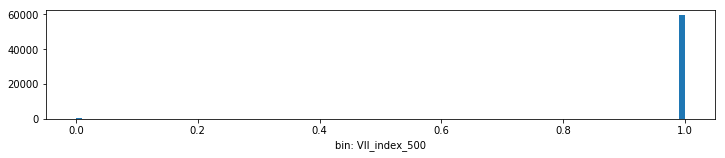

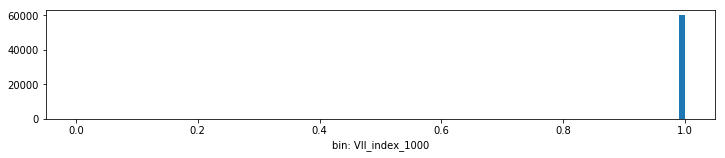

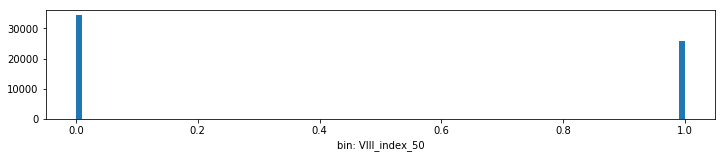

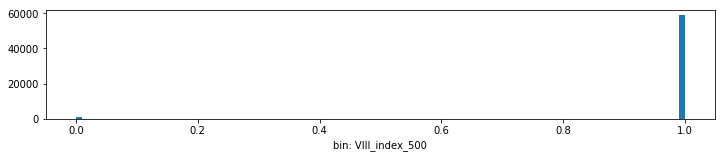

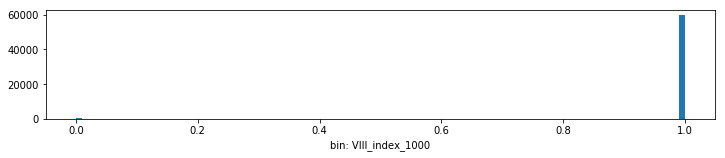

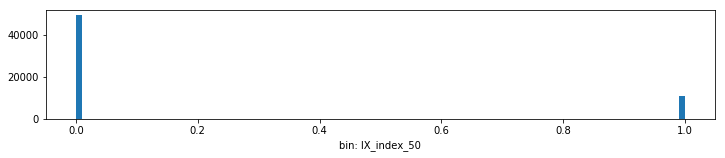

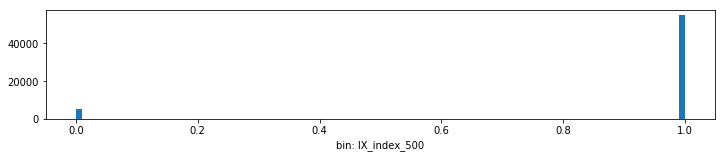

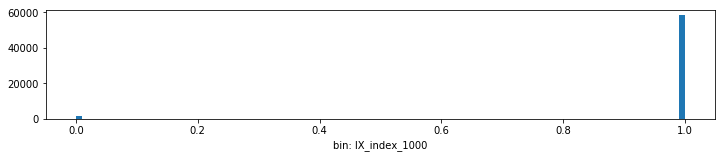

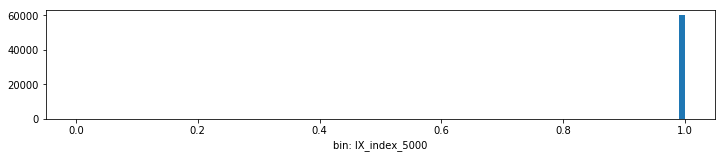

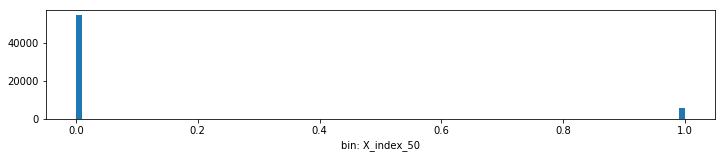

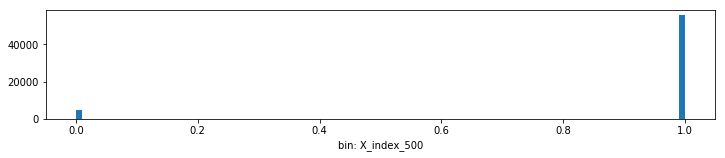

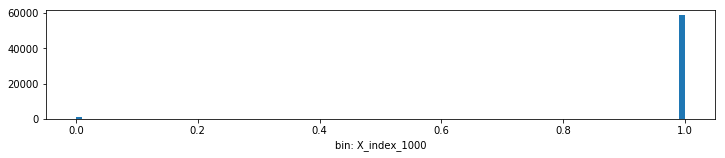

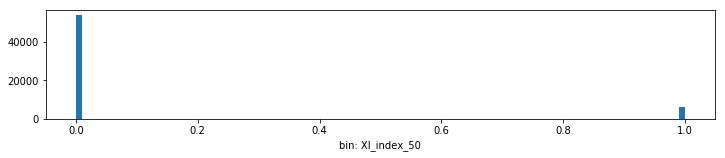

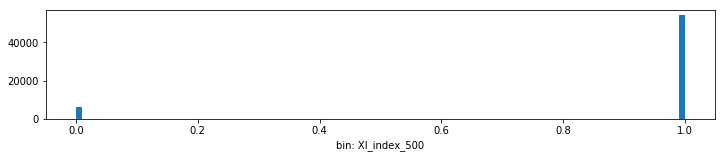

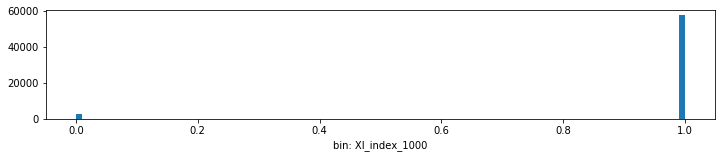

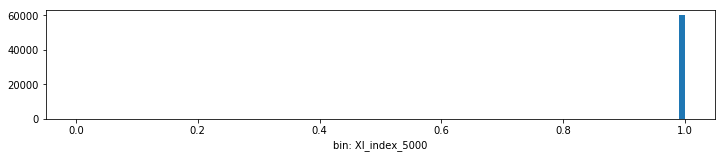

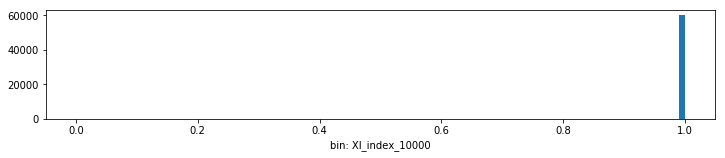

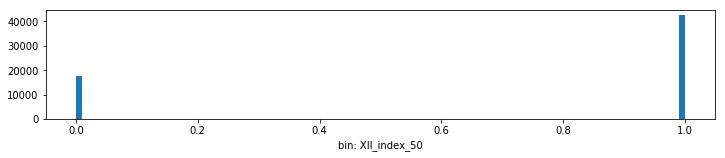

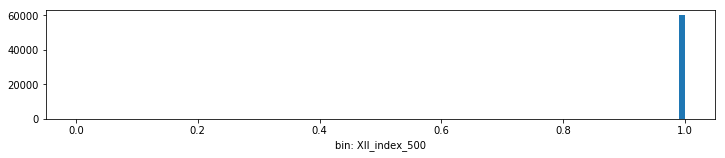

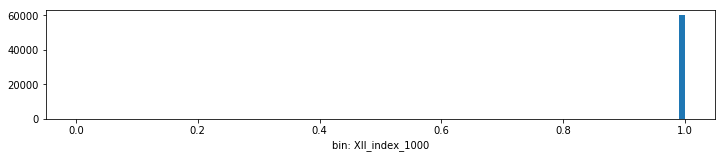

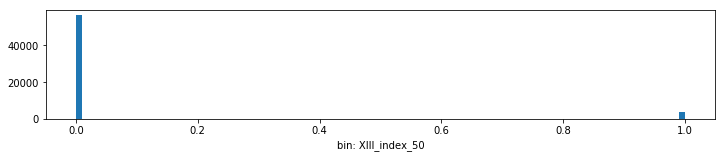

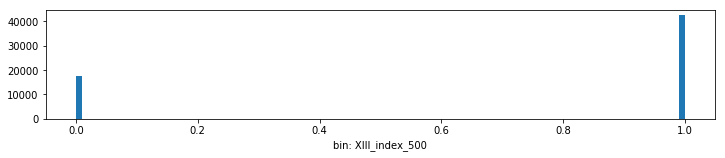

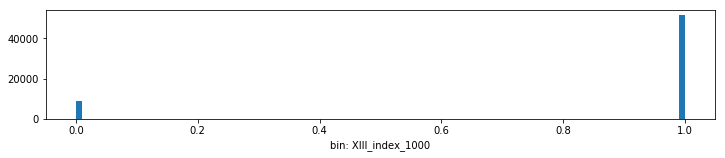

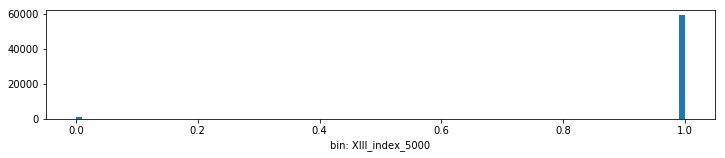

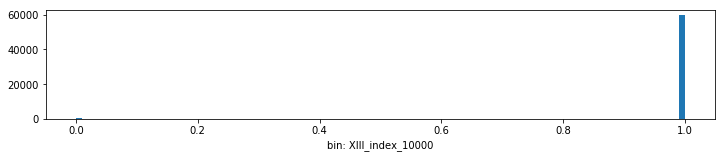

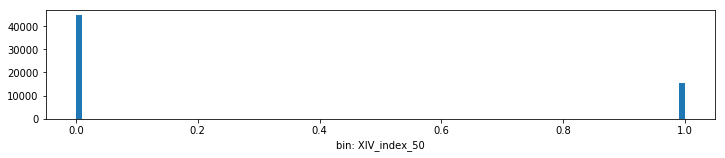

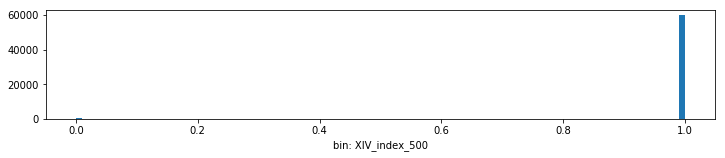

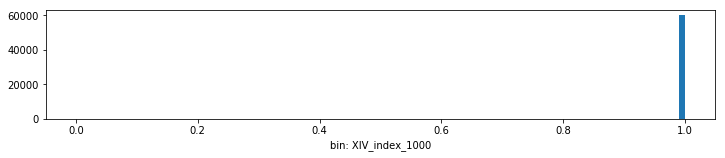

In [21]:
for c in cols_num:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('num: '+c); plt.show()
for c in cols_bin:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('bin: '+c); plt.show()

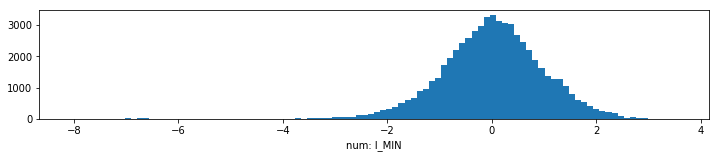

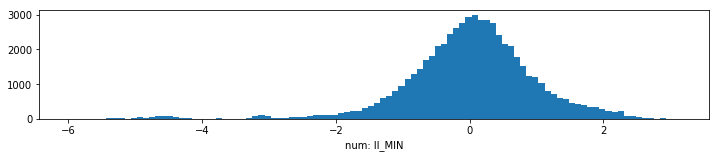

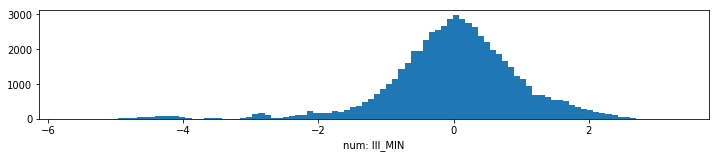

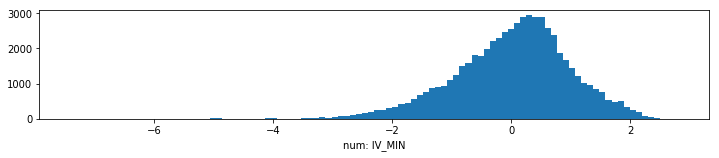

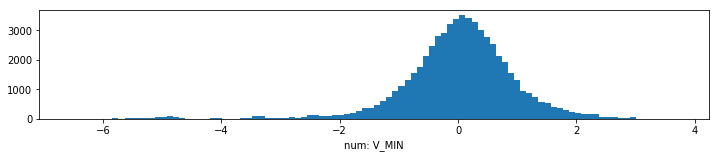

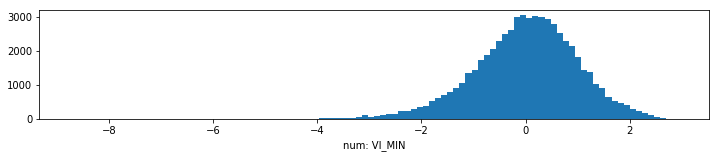

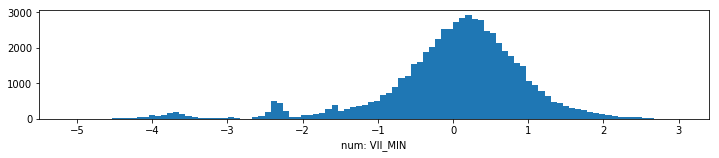

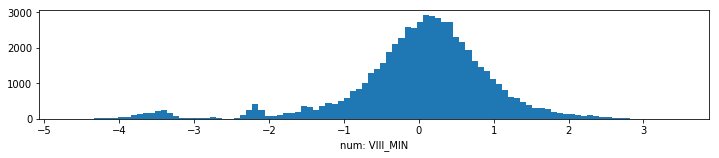

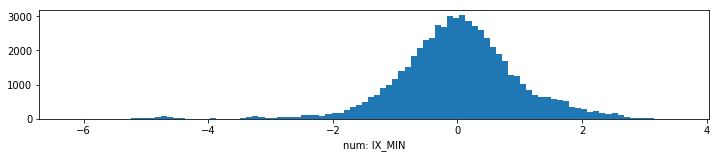

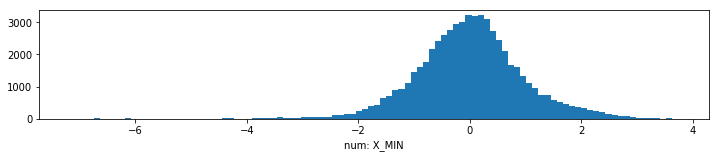

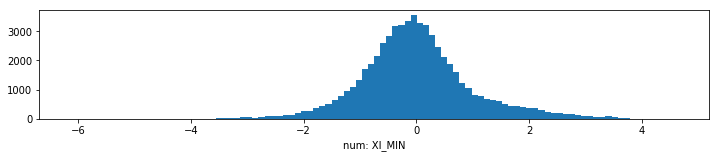

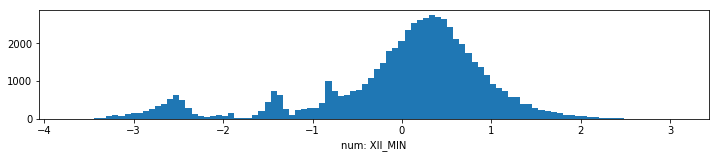

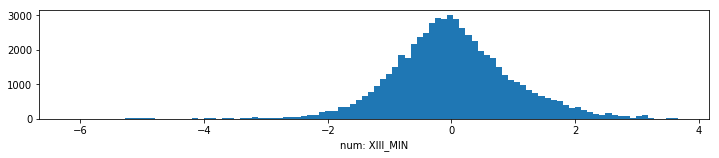

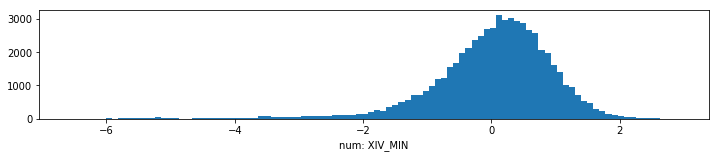

In [51]:
for c in cols_num:
    if 'MIN' in c:
        plt.figure(figsize=(12, 2))
        plt.hist(dfp2[c], bins=100)
        plt.xlabel('num: '+c); plt.show()

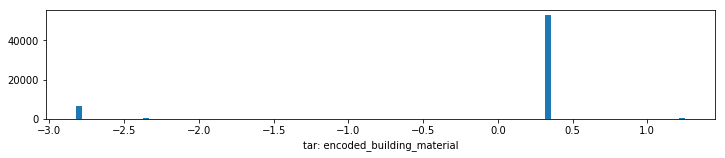

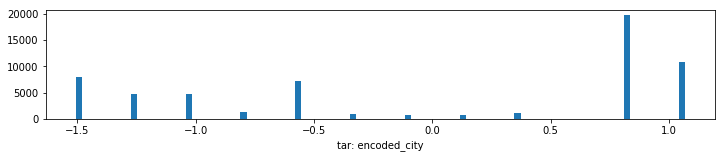

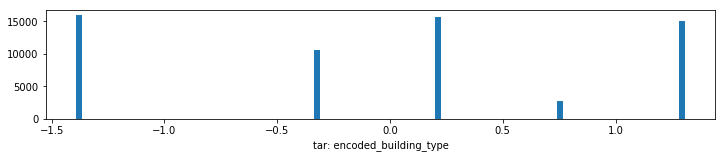

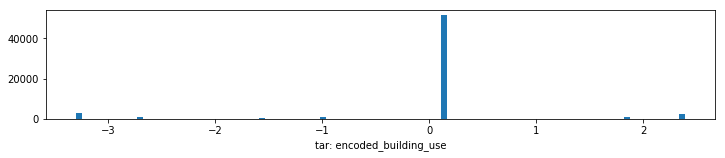

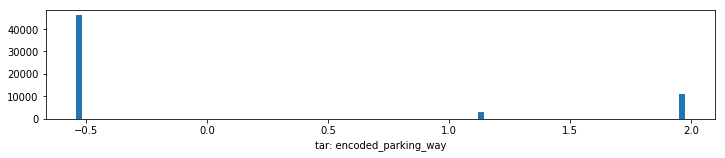

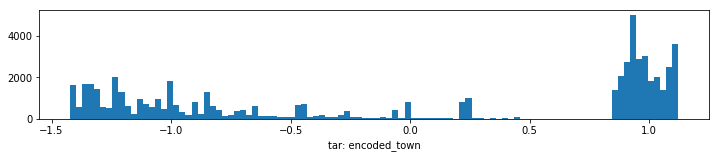

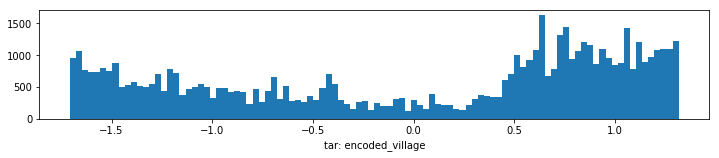

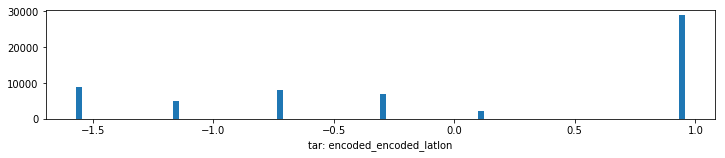

In [22]:
for c in cols_tar_encoded:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('tar: '+c); plt.show()

#### Target transformer (not in use)

In [21]:
class TargetTransformer():
    def __init__(self, is_log_target, is_per_area_target):
        self.is_log_target = is_log_target
        self.is_per_area_target = is_per_area_target

    def _log_and_per_area_transform(self, y, df):
        if self.is_per_area_target:
            y = y / df['building_area']
        if self.is_log_target:
            y = np.log1p(y)
        return y
    
    def _log_and_per_area_inverse_transform(self, y_pred, df):
        if self.is_log_target:
            y_pred = np.clip(np.expm1(y_pred), 0, None)
        if self.is_per_area_target:
            y_pred = y_pred * df['building_area']
        return y_pred

    def fit_transform(self, y, df):
        y = _log_and_per_area_transform(self, y, df)
        return y
    
    def transform(self, y, df):
        y = _log_and_per_area_transform(self, y, df)
        return y
    
    def inverse_transform(self, y_pred, df):
        y_pred = _log_and_per_area_inverse_transform(self, y_pred, df)

### Keras Model

In [135]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate
from keras.optimizers import Adam, SGD

In [12]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

keras: 2.2.2 tensorflow: 1.10.1


In [96]:
from keras_get_best import GetBest

In [136]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=[1024]*10, learning_rate=0.001, optimizer=Adam):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for n in n_neurons:
        x_layer = Dense(n, activation='relu')(x_layer)
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    model.compile(optimizer=optimizer(lr=learning_rate), loss='mae', metrics=['mse'])
    return model    

In [20]:
def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

#### One run testing

In [14]:
from sklearn.model_selection import train_test_split
itrain, ival = train_test_split(dfp.index, test_size=0.3, random_state=123)

# split train, val
df_train = dfp.loc[itrain].reset_index(drop=True)
df_val = dfp.loc[ival].reset_index(drop=True)

# feat eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew)
df_train = feat_eng.fit_transform(df_train)
df_val = feat_eng.transform(df_val)

In [19]:
df_train.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,land_per_building_area,encoded_building_material,encoded_city,encoded_building_type,encoded_building_use,encoded_parking_way,encoded_town,encoded_village,encoded_encoded_latlon,log_per_area_total_price_scaled
0,T1JoS1XWqso1c9G0,8,13,-1.291672,1.252125,0,2,0.722059,0,-0.233173,...,-0.613060,0.348629,1.069942,0.229891,-0.070888,1.977551,1.073294,1.239095,0.960003,1.491160
1,UMyDRljT7Ze4l3eJ,8,12,-1.685994,-0.519756,3,2,1.310622,2,-0.233173,...,1.100474,0.348629,-0.565800,-0.309941,-0.070888,-0.541470,-0.775437,-0.423971,-0.722017,-1.202731
2,mTdaS1xzULNW1Ubm,8,7,-1.492969,2.630255,0,2,0.932211,0,-0.233173,...,-2.214306,0.348629,0.836265,0.229891,-0.070888,1.977551,0.988155,0.955369,0.960003,0.155702
3,D1bHnOx451bxG5R7,8,7,0.572396,-0.716632,2,2,-1.288767,2,-0.233173,...,1.177113,0.348629,0.836265,0.769723,-0.070888,-0.541470,0.939505,0.678192,0.960003,0.716418
4,WyxmUEFOTLygBMgo,8,21,-0.931819,-0.716632,4,2,-0.055478,2,-0.233173,...,0.355260,0.348629,-1.500510,-1.389605,-0.070888,-0.541470,-1.395735,-1.582880,-1.563028,-2.034560
41995,QQ3yQPoujssJczPs,8,14,-1.523302,-0.519756,4,1,0.252728,2,-0.233173,...,-0.505959,0.348629,-1.266832,-1.389605,-2.384240,-0.541470,-1.213294,-1.549051,-1.142523,-0.774163
41996,rM5ZZL8I50csvris,1,10,-0.423060,-1.110384,4,2,-1.113602,2,-0.233173,...,1.290049,-2.796030,-1.033155,-1.389605,-0.070888,-0.541470,-1.030854,-1.405006,-0.301512,-1.208087
41997,A89t9bkUOCxJdj4J,8,12,-0.438227,3.024006,0,2,1.850157,0,-0.233173,...,-2.062534,0.348629,-0.565800,0.229891,-0.070888,1.977551,0.039464,-1.271873,-0.722017,0.351608
41998,EPFQhBNpBs5R9CmA,8,13,-0.838064,-0.126005,3,5,1.289676,0,-0.233173,...,-0.456998,0.348629,1.069942,-0.309941,3.399140,1.977551,1.097620,0.828784,0.960003,2.089187
41999,iOoWvOrsv16kBvsw,8,13,0.430385,-0.716632,1,2,-1.856153,2,-0.233173,...,0.593327,0.348629,1.069942,1.309555,-0.070888,-0.541470,1.012481,1.167072,0.960003,1.780517


shape = (42000, 262)


In [49]:
for c in cols_cat:
    print(c, df_train[c].min(), df_val[c].min())

building_material 1 1
city 3 3
building_type 0 0
building_use 0 0
parking_way 0 0
town 0 0
village 0 0
encoded_latlon 0 0


In [47]:
# Prepare X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)

y_train = df_train[col_target+'_scaled']
y_val = df_val[col_target+'_scaled']

In [133]:
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
else:
    cat_n_classes = {}
    cat_embed_sizes = {}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

Numerical input dims: 213
Embeding  input dims: {}
Embeding output dims: {}
Total embedding output dims: 0.0


In [118]:
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes)

In [119]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_bin (InputLayer)         (None, 213)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1024)              219136    
_________________________________________________________________
dense_72 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_73 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_74 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_75 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_76 (Dense)             (None, 1024)              1049600   
__________

In [120]:
%%time
hist = model.fit(x=X_train, y=y_train, batch_size=128, epochs=500, verbose=2, 
                 validation_data=(X_val, y_val), callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])

Train on 42000 samples, validate on 18000 samples
Epoch 1/500
 - 42s - loss: 0.2973 - mean_squared_error: 0.1887 - val_loss: 0.2975 - val_mean_squared_error: 0.1537
Epoch 2/500
 - 44s - loss: 0.2321 - mean_squared_error: 0.0995 - val_loss: 0.2215 - val_mean_squared_error: 0.0910
Epoch 3/500
 - 43s - loss: 0.2108 - mean_squared_error: 0.0847 - val_loss: 0.2093 - val_mean_squared_error: 0.0804
Epoch 4/500
 - 42s - loss: 0.2000 - mean_squared_error: 0.0777 - val_loss: 0.2112 - val_mean_squared_error: 0.0829
Epoch 5/500
 - 44s - loss: 0.1891 - mean_squared_error: 0.0709 - val_loss: 0.2225 - val_mean_squared_error: 0.0880
Epoch 6/500
 - 44s - loss: 0.1817 - mean_squared_error: 0.0660 - val_loss: 0.1952 - val_mean_squared_error: 0.0740
Epoch 7/500
 - 43s - loss: 0.1767 - mean_squared_error: 0.0627 - val_loss: 0.1936 - val_mean_squared_error: 0.0727
Epoch 8/500
 - 43s - loss: 0.1729 - mean_squared_error: 0.0608 - val_loss: 0.1953 - val_mean_squared_error: 0.0731
Epoch 9/500
 - 43s - loss: 0.1

Epoch 72/500
 - 40s - loss: 0.0519 - mean_squared_error: 0.0078 - val_loss: 0.1602 - val_mean_squared_error: 0.0555
Epoch 73/500
 - 40s - loss: 0.0495 - mean_squared_error: 0.0069 - val_loss: 0.1610 - val_mean_squared_error: 0.0559
Epoch 74/500
 - 41s - loss: 0.0524 - mean_squared_error: 0.0078 - val_loss: 0.1633 - val_mean_squared_error: 0.0566
Epoch 75/500
 - 40s - loss: 0.0512 - mean_squared_error: 0.0073 - val_loss: 0.1642 - val_mean_squared_error: 0.0573
Epoch 76/500
 - 40s - loss: 0.0495 - mean_squared_error: 0.0069 - val_loss: 0.1609 - val_mean_squared_error: 0.0554
Epoch 77/500
 - 41s - loss: 0.0490 - mean_squared_error: 0.0068 - val_loss: 0.1618 - val_mean_squared_error: 0.0566
Epoch 78/500
 - 40s - loss: 0.0479 - mean_squared_error: 0.0107 - val_loss: 0.1596 - val_mean_squared_error: 0.0550
Epoch 79/500
 - 40s - loss: 0.0462 - mean_squared_error: 0.0062 - val_loss: 0.1639 - val_mean_squared_error: 0.0571
Epoch 80/500
 - 40s - loss: 0.0471 - mean_squared_error: 0.0066 - val_lo

Epoch 143/500
 - 40s - loss: 0.0313 - mean_squared_error: 0.0030 - val_loss: 0.1578 - val_mean_squared_error: 0.0550
Epoch 144/500
 - 41s - loss: 0.0319 - mean_squared_error: 0.0030 - val_loss: 0.1590 - val_mean_squared_error: 0.0558
Epoch 145/500
 - 40s - loss: 0.0304 - mean_squared_error: 0.0029 - val_loss: 0.1579 - val_mean_squared_error: 0.0554
Epoch 146/500
 - 40s - loss: 0.0353 - mean_squared_error: 0.0038 - val_loss: 0.1594 - val_mean_squared_error: 0.0554
Epoch 147/500
 - 40s - loss: 0.0332 - mean_squared_error: 0.0035 - val_loss: 0.1603 - val_mean_squared_error: 0.0564
Epoch 148/500
 - 40s - loss: 0.0304 - mean_squared_error: 0.0030 - val_loss: 0.1591 - val_mean_squared_error: 0.0557
Epoch 149/500
 - 40s - loss: 0.0304 - mean_squared_error: 0.0029 - val_loss: 0.1586 - val_mean_squared_error: 0.0552
Epoch 150/500
 - 40s - loss: 0.0306 - mean_squared_error: 0.0029 - val_loss: 0.1591 - val_mean_squared_error: 0.0554
Epoch 151/500
 - 40s - loss: 0.0302 - mean_squared_error: 0.0029

 - 40s - loss: 0.0245 - mean_squared_error: 0.0023 - val_loss: 0.1577 - val_mean_squared_error: 0.0552
Epoch 214/500
 - 40s - loss: 0.0250 - mean_squared_error: 0.0021 - val_loss: 0.1583 - val_mean_squared_error: 0.0556
Epoch 215/500
 - 40s - loss: 0.0240 - mean_squared_error: 0.0020 - val_loss: 0.1577 - val_mean_squared_error: 0.0549
Epoch 216/500
 - 41s - loss: 0.0234 - mean_squared_error: 0.0020 - val_loss: 0.1578 - val_mean_squared_error: 0.0554
Epoch 217/500
 - 41s - loss: 0.0247 - mean_squared_error: 0.0021 - val_loss: 0.1583 - val_mean_squared_error: 0.0554
Epoch 218/500
 - 40s - loss: 0.0239 - mean_squared_error: 0.0020 - val_loss: 0.1583 - val_mean_squared_error: 0.0556
Epoch 219/500
 - 40s - loss: 0.0236 - mean_squared_error: 0.0019 - val_loss: 0.1581 - val_mean_squared_error: 0.0557
Epoch 220/500
 - 41s - loss: 0.0247 - mean_squared_error: 0.0020 - val_loss: 0.1589 - val_mean_squared_error: 0.0560
Epoch 221/500
 - 40s - loss: 0.0245 - mean_squared_error: 0.0020 - val_loss: 0

Epoch 284/500
 - 40s - loss: 0.0213 - mean_squared_error: 0.0022 - val_loss: 0.1584 - val_mean_squared_error: 0.0559
Epoch 285/500
 - 40s - loss: 0.0240 - mean_squared_error: 0.0047 - val_loss: 0.1587 - val_mean_squared_error: 0.0565
Epoch 286/500
 - 40s - loss: 0.0214 - mean_squared_error: 0.0023 - val_loss: 0.1586 - val_mean_squared_error: 0.0557
Epoch 287/500
 - 40s - loss: 0.0204 - mean_squared_error: 0.0017 - val_loss: 0.1580 - val_mean_squared_error: 0.0557
Epoch 288/500
 - 41s - loss: 0.0201 - mean_squared_error: 0.0016 - val_loss: 0.1577 - val_mean_squared_error: 0.0555
Epoch 289/500
 - 40s - loss: 0.0208 - mean_squared_error: 0.0017 - val_loss: 0.1580 - val_mean_squared_error: 0.0557
Epoch 290/500
 - 40s - loss: 0.0207 - mean_squared_error: 0.0017 - val_loss: 0.1583 - val_mean_squared_error: 0.0560
Epoch 291/500
 - 40s - loss: 0.0203 - mean_squared_error: 0.0016 - val_loss: 0.1582 - val_mean_squared_error: 0.0560
Epoch 292/500
 - 40s - loss: 0.0211 - mean_squared_error: 0.0017

 - 40s - loss: 0.0186 - mean_squared_error: 0.0014 - val_loss: 0.1586 - val_mean_squared_error: 0.0565
Epoch 355/500
 - 40s - loss: 0.0190 - mean_squared_error: 0.0021 - val_loss: 0.1585 - val_mean_squared_error: 0.0565
Epoch 356/500
 - 40s - loss: 0.0200 - mean_squared_error: 0.0017 - val_loss: 0.1584 - val_mean_squared_error: 0.0563
Epoch 357/500
 - 41s - loss: 0.0188 - mean_squared_error: 0.0017 - val_loss: 0.1586 - val_mean_squared_error: 0.0561
Epoch 358/500
 - 41s - loss: 0.0179 - mean_squared_error: 0.0015 - val_loss: 0.1583 - val_mean_squared_error: 0.0563
Epoch 359/500
 - 40s - loss: 0.0178 - mean_squared_error: 0.0013 - val_loss: 0.1583 - val_mean_squared_error: 0.0562
Epoch 360/500
 - 41s - loss: 0.0193 - mean_squared_error: 0.0015 - val_loss: 0.1590 - val_mean_squared_error: 0.0563
Epoch 361/500
 - 40s - loss: 0.0195 - mean_squared_error: 0.0015 - val_loss: 0.1596 - val_mean_squared_error: 0.0570
Epoch 362/500
 - 40s - loss: 0.0197 - mean_squared_error: 0.0015 - val_loss: 0

Epoch 425/500
 - 40s - loss: 0.0177 - mean_squared_error: 0.0016 - val_loss: 0.1586 - val_mean_squared_error: 0.0567
Epoch 426/500
 - 41s - loss: 0.0193 - mean_squared_error: 0.0016 - val_loss: 0.1596 - val_mean_squared_error: 0.0568
Epoch 427/500
 - 40s - loss: 0.0263 - mean_squared_error: 0.0038 - val_loss: 0.1619 - val_mean_squared_error: 0.0583
Epoch 428/500
 - 40s - loss: 0.0236 - mean_squared_error: 0.0025 - val_loss: 0.1600 - val_mean_squared_error: 0.0573
Epoch 429/500
 - 40s - loss: 0.0204 - mean_squared_error: 0.0018 - val_loss: 0.1584 - val_mean_squared_error: 0.0566
Epoch 430/500
 - 40s - loss: 0.0181 - mean_squared_error: 0.0017 - val_loss: 0.1598 - val_mean_squared_error: 0.0569
Epoch 431/500
 - 40s - loss: 0.0179 - mean_squared_error: 0.0016 - val_loss: 0.1582 - val_mean_squared_error: 0.0559
Epoch 432/500
 - 40s - loss: 0.0177 - mean_squared_error: 0.0015 - val_loss: 0.1603 - val_mean_squared_error: 0.0576
Epoch 433/500
 - 41s - loss: 0.0169 - mean_squared_error: 0.0014

 - 40s - loss: 0.0180 - mean_squared_error: 0.0014 - val_loss: 0.1592 - val_mean_squared_error: 0.0563
Epoch 496/500
 - 41s - loss: 0.0193 - mean_squared_error: 0.0016 - val_loss: 0.1595 - val_mean_squared_error: 0.0561
Epoch 497/500
 - 40s - loss: 0.0172 - mean_squared_error: 0.0013 - val_loss: 0.1600 - val_mean_squared_error: 0.0569
Epoch 498/500
 - 41s - loss: 0.0175 - mean_squared_error: 0.0014 - val_loss: 0.1585 - val_mean_squared_error: 0.0557
Epoch 499/500
 - 40s - loss: 0.0188 - mean_squared_error: 0.0015 - val_loss: 0.1594 - val_mean_squared_error: 0.0564
Epoch 500/500
 - 40s - loss: 0.0176 - mean_squared_error: 0.0013 - val_loss: 0.1611 - val_mean_squared_error: 0.0575
CPU times: user 1d 18h 10min 36s, sys: 10h 44min 1s, total: 2d 4h 54min 37s
Wall time: 5h 36min 47s


In [121]:
model.evaluate(X_val, y_val, batch_size=1024)

18000/18000 [==============================] - 2s 91us/step


[0.15732812456289927, 0.05505328182048268]

- loss: 0.0060 - mean_absolute_error: 0.0586 - val_loss: 0.0639 - val_mean_absolute_error: 0.1781 mse 100
- loss: 0.0031 - mean_absolute_error: 0.0404 - val_loss: 0.0600 - val_mean_absolute_error: 0.1691 256*7 mse 100
- loss: 0.0035 - mean_absolute_error: 0.0416 - val_loss: 0.0579 - val_mean_absolute_error: 0.1650 512*9 mse 100 16m
- loss: 0.0527 - mean_squared_error: 0.0076 - val_loss: 0.1677 - val_mean_squared_error: 0.0600 256*7 mae 100 3m
- loss: 0.0176 - mean_squared_error: 0.0013 - val_loss: 0.1611 - val_mean_squared_error: 0.0575 1024*10 mae 500 6h (40s/ep)

In [130]:
def plot_keras_hist(hist):
    metrics_plot = [c for c in hist.history.keys() if not c.startswith('val')]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for c in hist.history:
            if c.endswith(m):
                plt.plot(hist.history[c], label=c)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

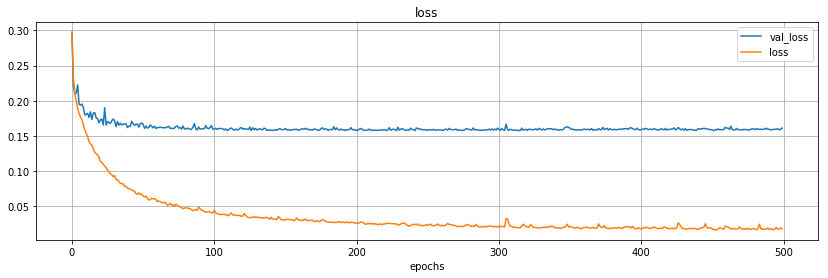

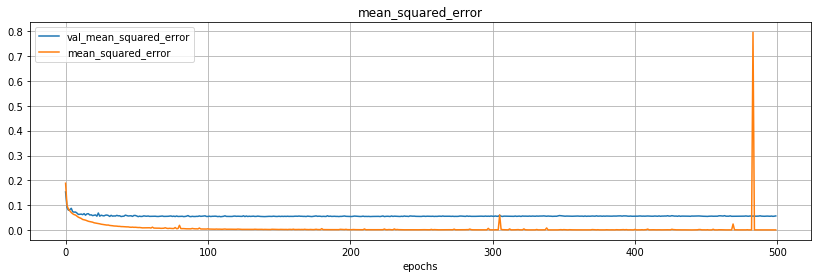

In [131]:
plot_keras_hist(hist)

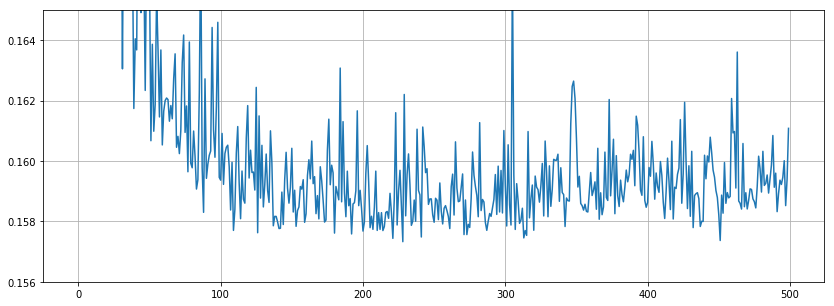

In [129]:
plt.figure(figsize=(14, 5))
plt.plot(hist.history['val_loss'])
plt.ylim(0.156, 0.165)
plt.grid(); plt.show()

In [123]:
df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred');
df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
score = cal_score(df_val['total_price'], df_val['total_price_pred'])
print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

score, mse, mae, mape: 4956.84128, 0.05138, 0.15199, 0.01140


- score, mse, mae, mape: 4551.83065, 0.05603, 0.16341, 0.01224 - 256*7 mse
- score, mse, mae, mape: 4643.83454, 0.05401, 0.15939, 0.01194 - 512*9 mse
- score, mse, mae, mape: 4659.83019, 0.05596, 0.16203, 0.01215 - 256*7 mae
- score, mse, mae, mape: 4956.84128, 0.05138, 0.15199, 0.01140 - 1024*10 mae

In [56]:
df_val.loc[:, [col_target, col_target+'_pred', col_target+'_scaled', col_target+'_scaled_pred', 'total_price', 'total_price_pred']].check()

,log_per_area_total_price,log_per_area_total_price_pred,log_per_area_total_price_scaled,log_per_area_total_price_scaled_pred,total_price,total_price_pred
0,13.959702,13.938708,0.458847,0.437116,10673093.0,10451354.0
1,15.000397,15.318747,1.536101,1.865634,41609072.0,57206552.0
2,14.075616,14.241629,0.578833,0.750677,19443270.0,22954496.0
3,14.225937,14.306396,0.734434,0.817721,5152761.0,5584485.0
4,14.565749,14.345729,1.086184,0.858435,13297622.0,10671375.0
17995,13.969596,13.626928,0.469088,0.114383,36400320.0,25839636.0
17996,14.226914,13.890934,0.735446,0.387663,7743181.5,5533565.5
17997,14.350793,13.836696,0.863676,0.331519,5152761.0,3081556.0
17998,12.829416,12.613196,-0.711145,-0.934961,4850049.0,3906995.0
17999,13.777486,13.546164,0.270230,0.030782,4725499.5,3749605.0


shape = (18000, 6)


### Grid search

In [142]:
# grid search
params_fix = {'batch_size': 128, 
              'epochs': 200,
              'n_neurons': (512,)*9,
              'learning_rate': 0.001,
              'optimizer': Adam,
             }

# prvs baseline best estimator
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

params_gsearch = {'max_depth': [1],
                 }
N_fold = 3
N_iter = 1
score_low_bound = 4600 # if score smaller than this, skip the param set

#### Round 1

In [149]:
# Round 1
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [150]:
params_rand

{'max_depth': 1}

In [151]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = dfp.loc[itrain].reset_index(drop=True)
    df_val = dfp.loc[ival].reset_index(drop=True)

    # feat eng
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Prepare X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )
        
        model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                            n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                            optimizer=params['optimizer'])

        model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=2,
                  validation_data=(X_val, y_val), callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])

        df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)

        feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
        df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        score = cal_score(df_val['total_price'], df_val['total_price_pred'])
        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(hist)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Numerical input dims: 213
Embeding  input dims: {}
Embeding output dims: {}
Total embedding output dims: 0.0
Train on 40000 samples, validate on 20000 samples
Epoch 1/200
 - 8s - loss: 0.2918 - mean_squared_error: 0.1702 - val_loss: 0.2316 - val_mean_squared_error: 0.1001
Epoch 2/200
 - 8s - loss: 0.2274 - mean_squared_error: 0.0962 - val_loss: 0.2209 - val_mean_squared_error: 0.0916
Epoch 3/200
 - 8s - loss: 0.2061 - mean_squared_error: 0.0813 - val_loss: 0.2046 - val_mean_squared_error: 0.0803
Epoch 4/200
 - 8s - loss: 0.1965 - mean_squared_error: 0.0751 - val_loss: 0.1987 - val_mean_squared_error: 0.0749
Epoch 5/200
 - 8s - loss: 0.1890 - mean_squared_error: 0.0704 - val_loss: 0.2094 - val_mean_squared_error: 0.0822
Epoch 6/200
 - 8s - loss: 0.1823 - mean_squared_error: 0.0661 - val_loss: 0.2243 - val_mean_squared_error: 0.0896
Epoch 7/200
 - 8s - loss: 0.1729 - mean_squared_error: 0.0606 - val_loss: 0.2016 - val_mean_squared_error: 0.0758
Epoch 8/200
 - 8s - loss: 

Epoch 71/200
 - 7s - loss: 0.0537 - mean_squared_error: 0.0079 - val_loss: 0.1660 - val_mean_squared_error: 0.0588
Epoch 72/200
 - 7s - loss: 0.0521 - mean_squared_error: 0.0076 - val_loss: 0.1656 - val_mean_squared_error: 0.0587
Epoch 73/200
 - 7s - loss: 0.0510 - mean_squared_error: 0.0073 - val_loss: 0.1678 - val_mean_squared_error: 0.0593
Epoch 74/200
 - 7s - loss: 0.0524 - mean_squared_error: 0.0075 - val_loss: 0.1663 - val_mean_squared_error: 0.0587
Epoch 75/200
 - 7s - loss: 0.0517 - mean_squared_error: 0.0074 - val_loss: 0.1675 - val_mean_squared_error: 0.0594
Epoch 76/200
 - 7s - loss: 0.0516 - mean_squared_error: 0.0074 - val_loss: 0.1650 - val_mean_squared_error: 0.0582
Epoch 77/200
 - 7s - loss: 0.0493 - mean_squared_error: 0.0068 - val_loss: 0.1659 - val_mean_squared_error: 0.0588
Epoch 78/200
 - 7s - loss: 0.0503 - mean_squared_error: 0.0070 - val_loss: 0.1662 - val_mean_squared_error: 0.0587
Epoch 79/200
 - 7s - loss: 0.0495 - mean_squared_error: 0.0069 - val_loss: 0.165

Epoch 142/200
 - 7s - loss: 0.0340 - mean_squared_error: 0.0035 - val_loss: 0.1640 - val_mean_squared_error: 0.0586
Epoch 143/200
 - 7s - loss: 0.0335 - mean_squared_error: 0.0034 - val_loss: 0.1649 - val_mean_squared_error: 0.0585
Epoch 144/200
 - 7s - loss: 0.0352 - mean_squared_error: 0.0036 - val_loss: 0.1645 - val_mean_squared_error: 0.0584
Epoch 145/200
 - 7s - loss: 0.0351 - mean_squared_error: 0.0037 - val_loss: 0.1642 - val_mean_squared_error: 0.0586
Epoch 146/200
 - 7s - loss: 0.0329 - mean_squared_error: 0.0033 - val_loss: 0.1642 - val_mean_squared_error: 0.0588
Epoch 147/200
 - 7s - loss: 0.0326 - mean_squared_error: 0.0033 - val_loss: 0.1639 - val_mean_squared_error: 0.0584
Epoch 148/200
 - 7s - loss: 0.0322 - mean_squared_error: 0.0032 - val_loss: 0.1642 - val_mean_squared_error: 0.0585
Epoch 149/200
 - 7s - loss: 0.0350 - mean_squared_error: 0.0039 - val_loss: 0.1652 - val_mean_squared_error: 0.0592
Epoch 150/200
 - 7s - loss: 0.0331 - mean_squared_error: 0.0034 - val_lo

 - 8s - loss: 0.1617 - mean_squared_error: 0.0541 - val_loss: 0.1910 - val_mean_squared_error: 0.0721
Epoch 10/200
 - 7s - loss: 0.1579 - mean_squared_error: 0.0514 - val_loss: 0.1855 - val_mean_squared_error: 0.0689
Epoch 11/200
 - 7s - loss: 0.1519 - mean_squared_error: 0.0482 - val_loss: 0.2105 - val_mean_squared_error: 0.0823
Epoch 12/200
 - 7s - loss: 0.1499 - mean_squared_error: 0.0468 - val_loss: 0.1929 - val_mean_squared_error: 0.0741
Epoch 13/200
 - 7s - loss: 0.1440 - mean_squared_error: 0.0439 - val_loss: 0.1849 - val_mean_squared_error: 0.0686
Epoch 14/200
 - 7s - loss: 0.1385 - mean_squared_error: 0.0413 - val_loss: 0.1789 - val_mean_squared_error: 0.0666
Epoch 15/200
 - 8s - loss: 0.1362 - mean_squared_error: 0.0397 - val_loss: 0.1806 - val_mean_squared_error: 0.0670
Epoch 16/200
 - 8s - loss: 0.1317 - mean_squared_error: 0.0374 - val_loss: 0.1753 - val_mean_squared_error: 0.0638
Epoch 17/200
 - 7s - loss: 0.1296 - mean_squared_error: 0.0364 - val_loss: 0.1725 - val_mean_

Epoch 81/200
 - 7s - loss: 0.0482 - mean_squared_error: 0.0066 - val_loss: 0.1646 - val_mean_squared_error: 0.0591
Epoch 82/200
 - 7s - loss: 0.0493 - mean_squared_error: 0.0067 - val_loss: 0.1666 - val_mean_squared_error: 0.0600
Epoch 83/200
 - 7s - loss: 0.0495 - mean_squared_error: 0.0068 - val_loss: 0.1640 - val_mean_squared_error: 0.0592
Epoch 84/200
 - 7s - loss: 0.0479 - mean_squared_error: 0.0064 - val_loss: 0.1659 - val_mean_squared_error: 0.0599
Epoch 85/200
 - 7s - loss: 0.0470 - mean_squared_error: 0.0062 - val_loss: 0.1653 - val_mean_squared_error: 0.0601
Epoch 86/200
 - 7s - loss: 0.0463 - mean_squared_error: 0.0060 - val_loss: 0.1647 - val_mean_squared_error: 0.0596
Epoch 87/200
 - 7s - loss: 0.0466 - mean_squared_error: 0.0061 - val_loss: 0.1641 - val_mean_squared_error: 0.0590
Epoch 88/200
 - 8s - loss: 0.0459 - mean_squared_error: 0.0059 - val_loss: 0.1649 - val_mean_squared_error: 0.0591
Epoch 89/200
 - 7s - loss: 0.0463 - mean_squared_error: 0.0060 - val_loss: 0.164

Epoch 152/200
 - 7s - loss: 0.0323 - mean_squared_error: 0.0033 - val_loss: 0.1626 - val_mean_squared_error: 0.0591
Epoch 153/200
 - 7s - loss: 0.0330 - mean_squared_error: 0.0033 - val_loss: 0.1643 - val_mean_squared_error: 0.0597
Epoch 154/200
 - 7s - loss: 0.0335 - mean_squared_error: 0.0035 - val_loss: 0.1636 - val_mean_squared_error: 0.0599
Epoch 155/200
 - 7s - loss: 0.0307 - mean_squared_error: 0.0031 - val_loss: 0.1623 - val_mean_squared_error: 0.0590
Epoch 156/200
 - 7s - loss: 0.0332 - mean_squared_error: 0.0036 - val_loss: 0.1624 - val_mean_squared_error: 0.0590
Epoch 157/200
 - 7s - loss: 0.0339 - mean_squared_error: 0.0036 - val_loss: 0.1631 - val_mean_squared_error: 0.0594
Epoch 158/200
 - 7s - loss: 0.0322 - mean_squared_error: 0.0033 - val_loss: 0.1632 - val_mean_squared_error: 0.0590
Epoch 159/200
 - 7s - loss: 0.0317 - mean_squared_error: 0.0032 - val_loss: 0.1650 - val_mean_squared_error: 0.0605
Epoch 160/200
 - 7s - loss: 0.0310 - mean_squared_error: 0.0031 - val_lo

Epoch 20/200
 - 7s - loss: 0.1175 - mean_squared_error: 0.0303 - val_loss: 0.1764 - val_mean_squared_error: 0.0649
Epoch 21/200
 - 7s - loss: 0.1165 - mean_squared_error: 0.0300 - val_loss: 0.1740 - val_mean_squared_error: 0.0638
Epoch 22/200
 - 7s - loss: 0.1137 - mean_squared_error: 0.0286 - val_loss: 0.1728 - val_mean_squared_error: 0.0631
Epoch 23/200
 - 7s - loss: 0.1107 - mean_squared_error: 0.0271 - val_loss: 0.1757 - val_mean_squared_error: 0.0653
Epoch 24/200
 - 7s - loss: 0.1073 - mean_squared_error: 0.0259 - val_loss: 0.1791 - val_mean_squared_error: 0.0666
Epoch 25/200
 - 8s - loss: 0.1047 - mean_squared_error: 0.0247 - val_loss: 0.1735 - val_mean_squared_error: 0.0638
Epoch 26/200
 - 7s - loss: 0.1039 - mean_squared_error: 0.0244 - val_loss: 0.1890 - val_mean_squared_error: 0.0704
Epoch 27/200
 - 7s - loss: 0.1028 - mean_squared_error: 0.0238 - val_loss: 0.1716 - val_mean_squared_error: 0.0624
Epoch 28/200
 - 7s - loss: 0.0984 - mean_squared_error: 0.0223 - val_loss: 0.169

Epoch 92/200
 - 7s - loss: 0.0466 - mean_squared_error: 0.0061 - val_loss: 0.1646 - val_mean_squared_error: 0.0603
Epoch 93/200
 - 8s - loss: 0.0474 - mean_squared_error: 0.0065 - val_loss: 0.1678 - val_mean_squared_error: 0.0624
Epoch 94/200
 - 7s - loss: 0.0526 - mean_squared_error: 0.0078 - val_loss: 0.1656 - val_mean_squared_error: 0.0605
Epoch 95/200
 - 7s - loss: 0.0458 - mean_squared_error: 0.0058 - val_loss: 0.1664 - val_mean_squared_error: 0.0622
Epoch 96/200
 - 7s - loss: 0.0459 - mean_squared_error: 0.0060 - val_loss: 0.1669 - val_mean_squared_error: 0.0620
Epoch 97/200
 - 7s - loss: 0.0426 - mean_squared_error: 0.0053 - val_loss: 0.1669 - val_mean_squared_error: 0.0622
Epoch 98/200
 - 7s - loss: 0.0441 - mean_squared_error: 0.0054 - val_loss: 0.1692 - val_mean_squared_error: 0.0626
Epoch 99/200
 - 7s - loss: 0.0435 - mean_squared_error: 0.0055 - val_loss: 0.1657 - val_mean_squared_error: 0.0616
Epoch 100/200
 - 7s - loss: 0.0423 - mean_squared_error: 0.0052 - val_loss: 0.16

Epoch 163/200
 - 7s - loss: 0.0334 - mean_squared_error: 0.0041 - val_loss: 0.1649 - val_mean_squared_error: 0.0612
Epoch 164/200
 - 7s - loss: 0.0326 - mean_squared_error: 0.0033 - val_loss: 0.1647 - val_mean_squared_error: 0.0614
Epoch 165/200
 - 8s - loss: 0.0309 - mean_squared_error: 0.0031 - val_loss: 0.1639 - val_mean_squared_error: 0.0610
Epoch 166/200
 - 8s - loss: 0.0303 - mean_squared_error: 0.0030 - val_loss: 0.1653 - val_mean_squared_error: 0.0619
Epoch 167/200
 - 7s - loss: 0.0322 - mean_squared_error: 0.0034 - val_loss: 0.1650 - val_mean_squared_error: 0.0620
Epoch 168/200
 - 8s - loss: 0.0311 - mean_squared_error: 0.0030 - val_loss: 0.1655 - val_mean_squared_error: 0.0619
Epoch 169/200
 - 7s - loss: 0.0303 - mean_squared_error: 0.0029 - val_loss: 0.1649 - val_mean_squared_error: 0.0616
Epoch 170/200
 - 8s - loss: 0.0312 - mean_squared_error: 0.0031 - val_loss: 0.1648 - val_mean_squared_error: 0.0615
Epoch 171/200
 - 7s - loss: 0.0314 - mean_squared_error: 0.0032 - val_lo

In [152]:
print('Total computing time:', t1-t0)

Total computing time: 4476.860810041428


In [153]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('batch_size', 128), ('epochs', 200), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512)), ('learning_rate', 0.001), ('optimizer', <class 'keras.optimizers.Adam'>), ('max_depth', 1)) 4826.829134146373 0.055261582 0.15730423 0.011794042 [4804.83602848649, 4824.835621774197, 4850.815752178431] [0.053850867, 0.05503125, 0.056902625] [0.1574969, 0.15656199, 0.1578538] [0.011808583, 0.011733741, 0.011839803]


In [154]:
metrics = ['score', 'mse', 'mae', 'mape']

In [155]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics]
display(df_gsearch_results)

,max_depth,score,mse,mae,mape
0,1,4826.829134,0.055262,0.157304,0.011794


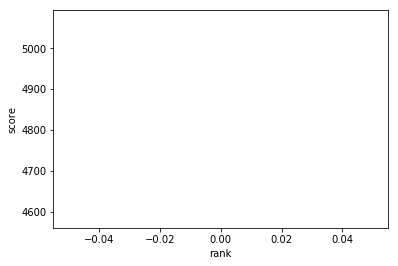

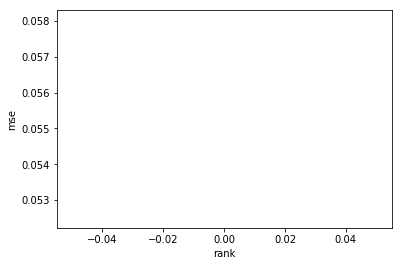

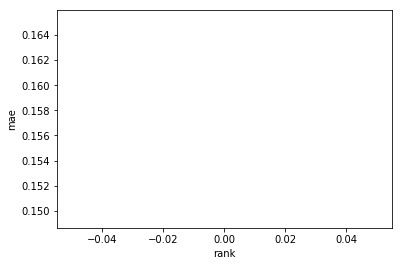

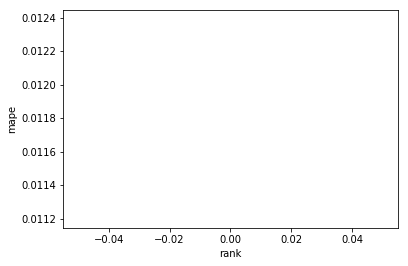

In [156]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

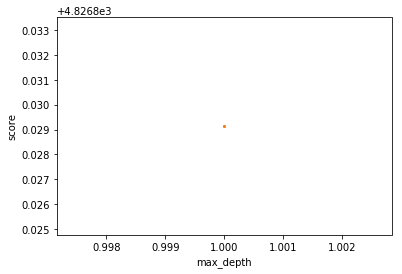

In [157]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

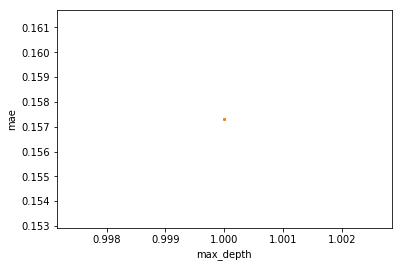

In [158]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

### Feature importance

lgb.plot_importance(gsearch_results[0][5][0], figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

lgb.plot_importance(gsearch_results[0][5][0], figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()